<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/CHFUSD/CHFUSD_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "USDCHF"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 11:51:51,671 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 11:51:51,672 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for USDCHF
2019-08-24 11:55:57,464 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 12:04:12,832 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 12:08:17,997 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 12:12:11,697 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 12:16:17,499 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 12:20:24,532 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 12:24:31,674 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 12:28:13,732 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 12:40:43,825 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_USDCHF__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-USDCHF__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-USDCHF to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close       Volume
Date                                                                
2018-01-01 22:00:00  0.97348  0.97423  0.97287  0.97336  1054.739990
2018-01-01 23:00:00  0.97337  0.97481  0.97315  0.97481  5068.129883
2018-01-02 00:00:00  0.97481  0.97481  0.97405  0.97407  1947.170044
2018-01-02 01:00:00  0.97407  0.97427  0.97355  0.97427  2419.600098
2018-01-02 02:00:00  0.97424  0.97448  0.97383  0.97390  1760.739990
...                      ...      ...      ...      ...          ...
2018-12-31 17:00:00  0.98326  0.98362  0.98271  0.98272  6557.359863
2018-12-31 18:00:00  0.98278  0.98395  0.98278  0.98387  4982.830078
2018-12-31 19:00:00  0.98387  0.98387  0.98286  0.98297  1903.670044
2018-12-31 20:00:00  0.98297  0.98304  0.98255  0.98285  1960.369995
2018-12-31 21:00:00  0.98292  0.98295  0.98082  0.98099  2597.600098

[6213 rows x 5 columns]

Open         High          Low        Close        Volume
count  6213.000000  6213.000000  6213.000000  6213.000000   6213.000000
mean      0.978397     0.978987     0.977797     0.978399   4186.974609
std       0.021900     0.021849     0.021954     0.021902   2588.500000
min       0.919300     0.919660     0.918720     0.919290     39.470001
25%       0.962400     0.962930     0.961910     0.962400   2002.719971
50%       0.987760     0.988390     0.987250     0.987760   3903.679932
75%       0.994950     0.995500     0.994340     0.994960   5808.970215
max       1.011020     1.012810     1.010700     1.011020  27827.939453

25

In [7]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [8]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  0.97710  0.97754  0.97709  0.97725  1541.000000    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.976680  0.962772  0.976590  0.977353  0.976788  0.976190    0.976680    0.977195  0.976590  0.976805  0.977183  0.976810  0.976947  0.976805  0.977103  0.975487                0.977476                 0.976805                0.976134                0.977812                 0.976805                0.975798                0.978148                 0.976805                0.975462                0.978483                 0.976805                0.975127  0.976788  0.977112  0.975736                0.977459                 0.976788                0.976116                0.977795                 0.976788                0.975781                0.978130                 0.976788                0.975445                0.978466                 0.976788   
2018-01-04 01:00:00  0.97725  0.97799  0.97718  0.97788  2007.750000    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.977280  0.966399  0.976830  0.977659  0.977030  0.976460    0.976995    0.977195  0.976830  0.976977  0.977576  0.976952  0.977186  0.976977  0.977565  0.975690                0.977906                 0.976977                0.976049                0.978371                 0.976977                0.975584                0.978835                 0.976977                0.975120                0.979300                 0.976977                0.974655  0.977030  0.977645  0.975931                0.977959                 0.977030                0.976101                0.978424                 0.977030                0.975637                0.978888                 0.977030                0.975172                0.979353                 0.977030   
2018-01-04 02:00:00  0.97788  0.97791  0.977

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000    6163.000000  6163.000000   6163.000000     6163.000000     6163.000000       6163.000000  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000   
mean      0.978436     0.979027     0.977835     0.978439   4193.271484    15.896966     2.051436   183.817946      30.440532    11.489048      0.034237        0.972416        0.003894          0.995132     6.547461     2.519714    26.646601     2.051436      2.029044    26.646601     0.978431     0.978395    -0.009902     0.978440     0.978435     0.978448     0.978431     0.978399     0.978374     0.978436     0.978439     0.978436     0.978437     0.978436     0.978439     0.978426                0.979996                 0.978436                0.976875                0.980776                 0.978436                0.976095                0.981556                 0.978436                0.975315                0.982337                 0.978436                0.974535     0.978435     0.978438     0.978427                0.979996                 0.978435                0.976875                0.980776                 0.978435                0.976095                0.981556   
std       0.021984     0.021932     0.022038     0.021986   2593.048584     8.724363     1.509716   104.043084       0.843764     6.925861      0.181851        0.163791        0.062287          0.069605     3.410726     1.113077    14.862751     1.509716      1.457490    14.862751     0.021977     0.021945     0.978706     0.021993     0.021957     0.021952     0.021960     0.021951     0.021972     0.021966     0.021990     0.021970     0.021969     0.021966     0.021978     0.021931                0.021849                 0.021966                0.022129                0.021808                 0.021966                0.022228                0.021779                 0.021966                0.022338                0.021761                 0.021966                0.022458     0.021957     0.021977     0.021936                0.021839                 0.021957                0.022120                0.021798                 0.021957                0.022219                0.021769   
min       0.919300     0.919660     0.

36

In [9]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.630179  0.621364  0.634595  0.631854  0.054034    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.627260  0.464199  0.983775  0.634240  0.626375  0.623833    0.626672    0.625220  0.615049  0.628138  0.632589  0.628781  0.629140  0.628138  0.632354  0.609698                0.624135                 0.628138                0.636146                0.614722                 0.628138                0.642014                0.596399                 0.628138                0.647883                0.579005                 0.628138                0.653791  0.626375  0.631054  0.613037                0.621316                 0.626375                0.632643                0.613687                 0.626375                0.638413                0.601052                 0.626375                0.644662                0.583310                 0.626375   
2018-01-04 01:00:00  0.631814  0.626194  0.635573  0.638723  0.070831    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.633916  0.505591  0.983893  0.637586  0.629066  0.626864    0.630154    0.625220  0.617600  0.630045  0.636877  0.630348  0.631775  0.630045  0.637415  0.611992                0.628896                 0.630045                0.635223                0.620839                 0.630045                0.639731                0.603731                 0.630045                0.644286                0.587489                 0.630045                0.648932  0.629066  0.636901  0.615228                0.626861                 0.629066                0.632481                0.620601                 0.629066                0.636867                0.609241                 0.629066                0.641780                0.592645                 0.629066   
2018-01-04 02:00:00  0.638683  0.625335  

52

In [11]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpor5346ft
  JVM stdout: /tmp/tmpor5346ft/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpor5346ft/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_nx7m2f
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.527624  0.755270              0.482037  0.520709  0.271138
1  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.520206  0.714083              0.473721  0.508418  0.258489
2  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.518483  0.699474              0.500000  0.503112  0.253122
3  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.500000  0.694034              0.500000  0.500443  0.250443
4  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.500000  0.693551              0.500000  0.500202  0.250202
5              DeepLearning_1_AutoML_20190824_125519  0.498566  0.717953              0.495114  0.505911  0.255946
6  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.498492  0.716304              0.498371  0.511037  0.261159
7  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.496911  0.693954              0.500000  0.500410  0.250410
8  DeepLearning_grid_1_AutoML_20190824_125519_mod...  0.481596  0.730366              0.500000  0.517054  0.267345

variable  relative_importance  scaled_importance  percentage
0            CDLSTICKSANDWICH             1.000000           1.000000    0.004548
1                 CDLPIERCING             0.991963           0.991963    0.004512
2                   CDL2CROWS             0.986902           0.986902    0.004489
3         CDLGAPSIDESIDEWHITE             0.978903           0.978903    0.004453
4             CDLLADDERBOTTOM             0.972056           0.972056    0.004421
...                       ...                  ...                ...         ...
1033  BBANDS_upperband_30_2_5             0.176111           0.176111    0.000801
1034   LINEARREG_INTERCEPT_30             0.174792           0.174792    0.000795
1035                MAVP_12_5             0.172857           0.172857    0.000786
1036                     SINH             0.170506           0.170506    0.000776
1037  BBANDS_middleband_8_6_5             0.170443           0.170443    0.000775

[1038 rows x 4 columns]

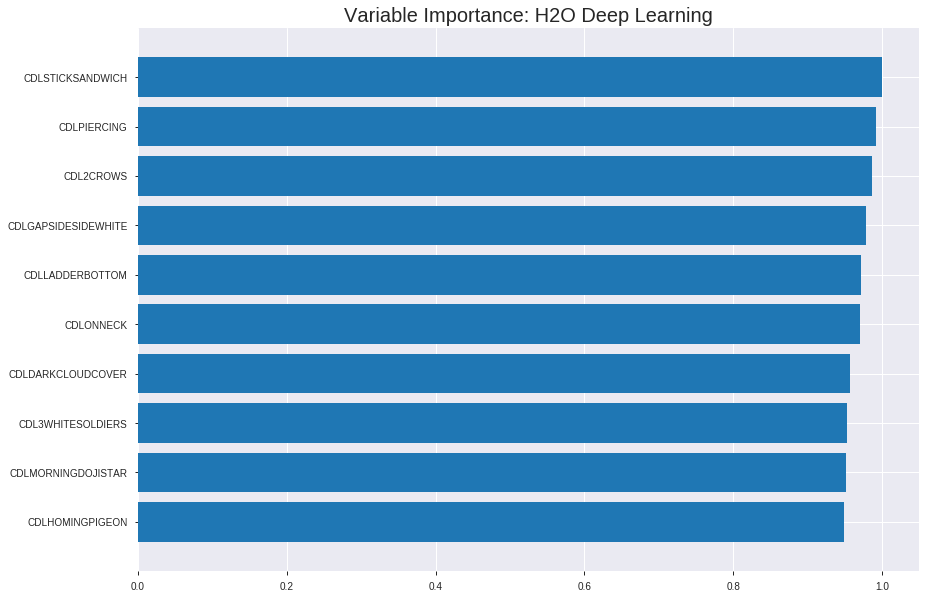

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_125519_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2650279738785837
RMSE: 0.5148086769651262
LogLoss: 0.7382962364800796
Mean Per-Class Error: 0.4386395424427463
AUC: 0.5768131037458757
pr_auc: 0.5854252956198307
Gini: 0.15362620749175138
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0877815739972547: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      53   2061  0.9749   (2061.0/2114.0)
1      19   2180  0.0086   (19.0/2199.0)
Total  72   4241  0.4823   (2080.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0877816    0.677019  385
max f2                       0.0515787    0.838998  395
max f0point5                 0.460143     0.571861  238
max accuracy                 0.571721     0.560631  174
max precision                0.99123      1         0
max recall                   0.0261596    1         399
max specificity              0.99123      1         0
max absolute_mcc             0.661164     0.124728  123
max min_per_class_accuracy   0.553443     0.557526  187
max mean_per_class_accuracy  0.571721     0.56136   174

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 53.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.91733            1.56016   1.56016            0.795455         0.945247  0.795455                    0.945247            0.0159163       0.0159163                  56.0162   56.0162
    2        0.0201716                   0.890029           1.23154   1.39774            0.627907         0.901135  0.712644                    0.923445            0.0122783       0.0281946                  23.1543   39.7741
    3        0.0301414                   0.871531           1.32277   1.37294            0.674419         0.880374  0.7                         0.909199            0.0131878       0.0413824                  32.2768   37.2942
    4        0.0401113                   0.855208           1.36838   1.37181            0.697674         0.864317  0.699422                    0.898043            0.0136426       0.055025                   36.8381   37.1809
    5        0.0500812                   0.84266            1.36838   1.37113            0.697674         0.849361  0.699074                    0.888352            0.0136426       0.0686676                  36.8381   37.1126
    6        0.100162                    0.784356           1.18952   1.28032            0.606481         0.811419  0.652778                    0.849885            0.0595725       0.12824                    18.952    28.0323
    7        0.150012                    0.741784           1.20418   1.25502            0.613953         0.763036  0.639876                    0.821025            0.0600273       0.188267                   20.4175   25.5019
    8        0.200093                    0.707659           1.05332   1.20453            0.537037         0.723598  0.614137                    0.79664             0.0527513       0.241019                   5.33155   20.4535
    9        0.300023                    0.65327            1.13312   1.18075            0.577726         0.679242  0.602009                    0.757538            0.113233        0.354252                   13.3121   18.0749
    10       0.399954                    0.601561           1.01025   1.13815            0.515081         0.627619  0.58029                     0.725077            0.100955        0.455207                   1.02525   13.8149
    11       0.500116                    0.553903           1.01699   1.11388            0.518519         0.577875  0.567918                    0.695596            0.101864        0.557071                   1.69943   11.3885
    12       0.600046                    0.503038           0.869181  1.07313            0.443155         0.528572  0.547141                    0.66778             0.0868577       0.643929                   -13.0819  7.31322
    13       0.699977                    0.446053           0.978398  1.05961            0.49884          0.475065  0.540245                    0.640267            0.0977717       0.741701                   -2.16023  5.96076
    14       0.799907                    0.359485           0.864631  1.03525            0.440835         0.405866  0.527826                    0.610984            0.0864029       0.828104                   -13.5369  3.52496
    15       0.899838                    0.223603           0.919239  1.02237            0.468677         0.291886  0.521257                    0.575547            0.0918599       0.919964                   -8.07612  2.23662
    16       1                           0.0254383          0.799067  1                  0.407407         0.14331   0.509854                    0.532253         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26632416041685236
RMSE: 0.5160660426891623
LogLoss: 0.7368992342352494
Mean Per-Class Error: 0.4593714568130941
AUC: 0.5313610859297984
pr_auc: 0.5466361427903353
Gini: 0.06272217185959672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14102372932871146: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    583   1        (583.0/583.0)
1      0    649   0        (0.0/649.0)
Total  0    1232  0.4732   (583.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.141024     0.690058   399
max f2                       0.141024     0.847701   399
max f0point5                 0.42177      0.588044   309
max accuracy                 0.461988     0.551948   277
max precision                0.966914     1          0
max recall                   0.141024     1          399
max specificity              0.966914     1          0
max absolute_mcc             0.461988     0.0897297  277
max min_per_class_accuracy   0.542634     0.520801   212
max mean_per_class_accuracy  0.461988     0.540629   277

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 55.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105519                   0.922723           1.02216   1.02216            0.538462         0.938506  0.538462                    0.938506            0.0107858       0.0107858                  2.21643    2.21643
    2        0.0202922                   0.889774           1.10734   1.06305            0.583333         0.903653  0.56                        0.921777            0.0107858       0.0215716                  10.7345    6.30508
    3        0.0300325                   0.862051           0.79096   0.974805           0.416667         0.87674   0.513514                    0.90717             0.00770416      0.0292758                  -20.904    -2.51947
    4        0.0405844                   0.843669           1.31421   1.06305            0.692308         0.85153   0.56                        0.892704            0.0138675       0.0431433                  31.4211    6.30508
    5        0.0503247                   0.831989           0.949153  1.04101            0.5              0.839344  0.548387                    0.882376            0.00924499      0.0523883                  -5.08475   4.1006
    6        0.100649                    0.778137           1.04101   1.04101            0.548387         0.80266   0.548387                    0.842518            0.0523883       0.104777                   4.1006     4.1006
    7        0.150162                    0.72153            0.995832  1.02611            0.52459          0.749323  0.540541                    0.811789            0.0493066       0.154083                   -0.416782  2.61109
    8        0.200487                    0.688239           1.01039   1.02216            0.532258         0.703673  0.538462                    0.784651            0.0508475       0.204931                   1.03882    2.21643
    9        0.300325                    0.627958           1.00317   1.01585            0.528455         0.655711  0.535135                    0.741787            0.100154        0.305085                   0.316935   1.58497
    10       0.400162                    0.579982           1.09577   1.03579            0.577236         0.602266  0.545639                    0.706977            0.109399        0.414484                   9.57696    3.57892
    11       0.5                         0.541976           1.0649    1.0416             0.560976         0.561336  0.548701                    0.677896            0.106317        0.520801                   6.49029    4.16025
    12       0.599838                    0.505281           1.08034   1.04805            0.569106         0.523601  0.552097                    0.652215            0.107858        0.628659                   8.03362    4.80494
    13       0.699675                    0.46801            1.0186    1.04385            0.536585         0.48895   0.549884                    0.628919            0.101695        0.730354                   1.86027    4.38476
    14       0.799513                    0.423377           1.00317   1.03877            0.528455         0.447377  0.547208                    0.606249            0.100154        0.830508                   0.316935   3.8768
    15       0.899351                    0.372039           0.787102  1.01083            0.414634         0.398417  0.532491                    0.583177            0.0785824       0.909091                   -21.2898   1.08303
    16       1                           0.141024           0.903226  1                  0.475806         0.313826  0.526786                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:14:08  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:14:13  10.275 sec        157 obs/sec       0.187804  1             810        0.659803         2.28468             -0.742035      0.507993        0.498094           1.06983          0.490146                         0.658567           2.3283                -0.739837        0.530944          0.548903             1.02216            0.473214
    2019-08-24 13:15:06  1 min  3.227 sec  169 obs/sec       2.09228   11            9024       0.638002         1.74173             -0.628818      0.517159        0.494163           1.02525          0.48945                          0.643935           1.46946               -0.663385        0.525157          0.543766             0.730117           0.473214
    2019-08-24 13:15:59  1 min 56.141 sec  187 obs/sec       4.39439   23            18953      0.655797         1.70806             -0.720946      0.547142        0.555337           1.42643          0.490146                         0.66343            1.84983               -0.765623        0.526473          0.544921             0.730117           0.473214
    2019-08-24 13:16:51  2 min 47.815 sec  200 obs/sec       6.87967   36            29672      0.555329         0.890558            -0.234039      0.555698        0.54773            1.24813          0.468815                         0.540751           0.828829              -0.173011        0.521188          0.540243             1.02216            0.470779
    2019-08-24 13:17:43  3 min 39.545 sec  210 obs/sec       9.49502   50            40952      0.514809         0.738296            -0.0605238     0.576813        0.585425           1.56016          0.482263                         0.516066           0.736899              -0.0683627       0.531361          0.546636             1.02216            0.473214
    2019-08-24 13:18:36  4 min 33.027 sec  219 obs/sec       12.3441   65            53240      0.513586         0.733116            -0.0554941     0.588774        0.579856           1.33728          0.466728                         0.548395           0.825951              -0.206409        0.507679          0.538627             1.02216            0.473214
    2019-08-24 13:19:29  5 min 25.462 sec  225 obs/sec       15.1927   80            65526      0.515397         0.758562            -0.0629497     0.58164         0.577986           1.15898          0.471366                         0.551562           0.903846              -0.220386        0.496758          0.521042             1.02216            0.469156
    2019-08-24 13:20:20  6 min 16.987 sec  231 obs/sec       18.0485   95            77843      0.520382         0.75854             -0.0836121     0.612519        0.604482           1.51559          0.444006                         0.536532           0.80818               -0.154782        0.508412          0.527652             1.16819            0.469156
    2019-08-24 13:21:13

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLSTICKSANDWICH         1.0                    1.0                  0.004548469925030672
CDLPIERCING              0.9919633865356445     0.9919633865356445   0.004511915630388955
CDL2CROWS                0.9869015216827393     0.9869015216827393   0.004488891890340945
CDLGAPSIDESIDEWHITE      0.9789026379585266     0.9789026379585266   0.004452509208287546
CDLLADDERBOTTOM          0.9720556139945984     0.9720556139945984   0.004421365725711655
---                      ---                    ---                  ---
BBANDS_upperband_30_2_5  0.17611052095890045    0.17611052095890045  0.0008010334080630425
LINEARREG_INTERCEPT_30   0.17479194700717926    0.17479194700717926  0.0007950359140997098
MAVP_12_5                0.1728568822145462     0.1728568822145462   0.0007862343300874327
SINH                     0.17050601541996002    0.17050601541996002  0.0007755414831745041
BBANDS_middleband_8_6_5  0.1704433113336563     0.1704433113336563   0.0007752562755237752


See the whole table with table.as_data_frame()


('accuracy', 0.5348460291734197)

('F1', 0.6747252747252749)

('auc', 0.5276242513397078)

('logloss', 0.755270486315825)

('mean_per_class_error', 0.4661815698224231)

('rmse', 0.5207090596726597)

('mse', 0.2711379248251855)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


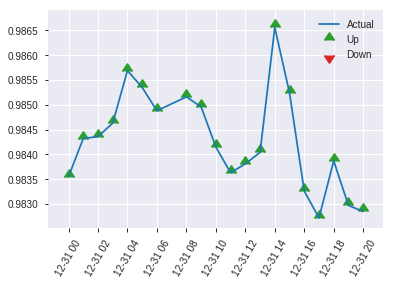


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2711379248251855
RMSE: 0.5207090596726597
LogLoss: 0.755270486315825
Mean Per-Class Error: 0.4661815698224231
AUC: 0.5276242513397078
pr_auc: 0.5196670338807711
Gini: 0.05524850267941561
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3744896374544611: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   293  0.9544   (293.0/307.0)
1      3    307  0.0097   (3.0/310.0)
Total  17   600  0.4797   (296.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37449      0.674725  385
max f2                       0.36948      0.835594  387
max f0point5                 0.421583     0.568095  365
max accuracy                 0.499862     0.534846  287
max precision                0.972638     1         0
max recall                   0.309335     1         397
max specificity              0.972638     1         0
max absolute_mcc             0.37449      0.109736  385
max min_per_class_accuracy   0.577828     0.512903  207
max mean_per_class_accuracy  0.499862     0.533818  287

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 59.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.9592             1.42166   1.42166            0.714286         0.965834  0.714286                    0.965834            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.928637           0.33172   0.91861            0.166667         0.951149  0.461538                    0.959056            0.00322581      0.0193548                  -66.828    -8.13896
    3        0.0307942                   0.892234           1.32688   1.04754            0.666667         0.906114  0.526316                    0.942338            0.0129032       0.0322581                  32.6882    4.75382
    4        0.0405186                   0.877946           0.663441  0.955355           0.333333         0.884758  0.48                        0.928519            0.00645161      0.0387097                  -33.6559   -4.46452
    5        0.0502431                   0.84622            0.995161  0.963059           0.5              0.861229  0.483871                    0.915495            0.00967742      0.0483871                  -0.483871  -3.69407
    6        0.100486                    0.776187           1.02726   0.995161           0.516129         0.806408  0.5                         0.860951            0.0516129       0.1                        2.72633    -0.483871
    7        0.150729                    0.740124           1.34828   1.11287            0.677419         0.759067  0.55914                     0.82699             0.0677419       0.167742                   34.8283    11.2869
    8        0.200972                    0.715202           0.834651  1.04331            0.419355         0.726745  0.524194                    0.801929            0.0419355       0.209677                   -16.5349   4.33143
    9        0.299838                    0.659903           1.07673   1.05433            0.540984         0.685868  0.52973                     0.76366             0.106452        0.316129                   7.67319    5.4333
    10       0.400324                    0.613839           0.834651  0.99919            0.419355         0.637598  0.502024                    0.732017            0.083871        0.4                        -16.5349   -0.0809717
    11       0.50081                     0.577517           1.15567   1.03059            0.580645         0.594432  0.517799                    0.704411            0.116129        0.516129                   15.5671    3.05877
    12       0.599676                    0.539154           1.01148   1.02744            0.508197         0.557674  0.516216                    0.680219            0.1             0.616129                   1.14754    2.74368
    13       0.700162                    0.503708           1.09147   1.03663            0.548387         0.519048  0.520833                    0.657088            0.109677        0.725806                   9.14672    3.66263
    14       0.799028                    0.471734           0.946219  1.02544            0.47541          0.487531  0.515213                    0.636108            0.0935484       0.819355                   -5.37811   2.544
    15       0.899514                    0.441073           1.02726   1.02564            0.516129         0.457705  0.515315                    0.616179            0.103226        0.922581                   2.72633    2.56437
    16       1                           0.273951           0.770447  1                  0.387097         0.395059  0.502431               

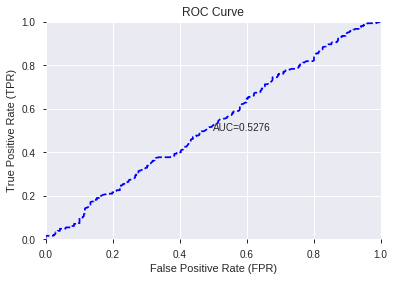

This function is available for GLM models only


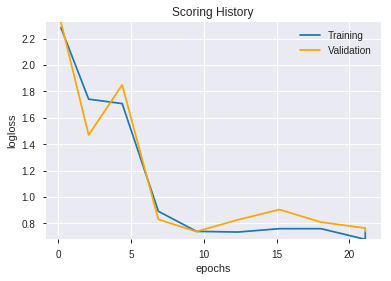

--2019-08-24 13:55:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  85.7MB/s    in 4.3s    

2019-08-24 13:55:38 (81.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_125519_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_125519_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [13]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190824_135633  0.534612  0.728214              0.496743  0.513404  0.263584
1  DeepLearning_grid_1_AutoML_20190824_135633_model_2  0.531643  0.793222              0.491794  0.509767  0.259863
2  DeepLearning_grid_1_AutoML_20190824_135633_model_1  0.521346  0.990993              0.500000  0.543092  0.294949
3  DeepLearning_grid_1_AutoML_20190824_135633_model_6  0.506641  0.702914              0.495114  0.504711  0.254733
4  DeepLearning_grid_1_AutoML_20190824_135633_model_8  0.506031  0.698064              0.495114  0.502374  0.252379
5  DeepLearning_grid_1_AutoML_20190824_135633_model_9  0.504534  0.694864              0.500000  0.500851  0.250851
6  DeepLearning_grid_1_AutoML_20190824_135633_model_4  0.502238  0.745595              0.496743  0.519843  0.270237
7  DeepLearning_grid_1_AutoML_20190824_135633_model_5  0.498870  0.694031              0.496727  0.500437  0.250437
8  DeepLearning_grid_1_AutoML_20190824_135633_model_3  0.493301  0.736956              0.498356  0.514757  0.264975
9  DeepLearning_grid_1_AutoML_20190824_135633_model_7  0.486745  0.745414              0.496743  0.520992  0.271433

variable  relative_importance  scaled_importance  percentage
0        STOCHRSI_fastk             1.000000           1.000000    0.030865
1      CDLSTICKSANDWICH             0.901233           0.901233    0.027817
2             CORREL_12             0.839797           0.839797    0.025920
3          is_month_end             0.828014           0.828014    0.025557
4     CDLDARKCLOUDCOVER             0.806232           0.806232    0.024884
5    CDLSEPARATINGLINES             0.752563           0.752563    0.023228
6   CDLGAPSIDESIDEWHITE             0.749945           0.749945    0.023147
7                 FLOOR             0.743920           0.743920    0.022961
8      is_quarter_start             0.740659           0.740659    0.022860
9     CDLLONGLEGGEDDOJI             0.735475           0.735475    0.022700
10   CDLIDENTICAL3CROWS             0.726067           0.726067    0.022410
11    CDLGRAVESTONEDOJI             0.723422           0.723422    0.022328
12             CORREL_8             0.720321           0.720321    0.022233
13      CDLHOMINGPIGEON             0.720040           0.720040    0.022224
14              CDLDOJI             0.712539           0.712539    0.021993
15            CORREL_20             0.698853           0.698853    0.021570
16                 CEIL             0.682906           0.682906    0.021078
17      CDLSHOOTINGSTAR             0.680004           0.680004    0.020988
18       CDLMATCHINGLOW             0.677854           0.677854    0.020922
19        CDLHIKKAKEMOD             0.677400           0.677400    0.020908
20    CDL3WHITESOLDIERS             0.673941           0.673941    0.020801
21            CDL2CROWS             0.670724           0.670724    0.020702
22          CDLPIERCING             0.669993           0.669993    0.020679
23     CDLDRAGONFLYDOJI             0.668744           0.668744    0.020641
24        CDLHANGINGMAN             0.668332           0.668332    0.020628
25            CORREL_14             0.652820           0.652820    0.020149
26                  BOP             0.648218           0.648218    0.020007
27       CDLRICKSHAWMAN             0.646925           0.646925    0.019967
28            CORREL_24             0.643978           0.643978    0.019876
29   CDLEVENINGDOJISTAR             0.642664           0.642664    0.019836
30       is_month_start             0.620983           0.620983    0.019167
31  CDLXSIDEGAP3METHODS             0.605521           0.605521    0.018689
32            CDLHAMMER             0.595042           0.595042    0.018366
33       CDLEVENINGSTAR             0.592670           0.592670    0.018293
34                  SUB             0.592529           0.592529    0.018288
35            CDLTAKURI             0.584843           0.584843    0.018051
36    CDLSTALLEDPATTERN             0.568111           0.568111    0.017535
37          CDLDOJISTAR             0.565855           0.565855    0.017465
38                 DX_8             0.553501           0.553501    0.017084
39       CDLHARAMICROSS             0.551973           0.551973    0.017037
40            CDLONNECK             0.546655           0.546655    0.016873
41                VAR_8             0.528945           0.528945    0.016326
42       CDLMORNINGSTAR             0.524790           0.524790    0.016198
43      CDLADVANCEBLOCK             0.512708           0.512708    0.015825
44       CDL3LINESTRIKE             0.503506           0.503506    0.015541
45         CDLTHRUSTING             0.490698           0.490698    0.015145
46        days_in_month             0.460439           0.460439    0.014211
47   CDLMORNINGDOJISTAR             0.442946           0.442946    0.013672
48      CDLLADDERBOTTOM             0.441478           0.441478    0.013626
49    CDLINVERTEDHAMMER             0.412368           0.412368    0.012728

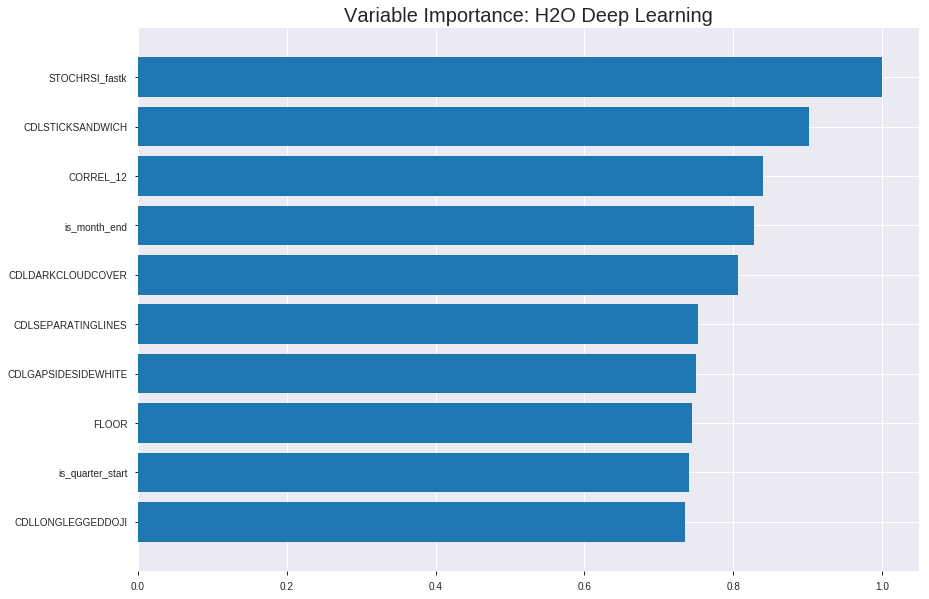

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190824_135633


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2523443290667068
RMSE: 0.5023388588061914
LogLoss: 0.6987525787034771
Mean Per-Class Error: 0.447200778886765
AUC: 0.5786265194078499
pr_auc: 0.583100946522263
Gini: 0.15725303881569985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42879302911366424: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      67   2047  0.9683   (2047.0/2114.0)
1      20   2179  0.0091   (20.0/2199.0)
Total  87   4226  0.4792   (2067.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428793     0.678288  350
max f2                       0.256336     0.83938   387
max f0point5                 0.527206     0.580154  289
max accuracy                 0.574618     0.554602  235
max precision                0.999262     1         0
max recall                   0.128057     1         394
max specificity              0.999262     1         0
max absolute_mcc             0.523289     0.116031  293
max min_per_class_accuracy   0.597352     0.548431  203
max mean_per_class_accuracy  0.613172     0.552799  182

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 60.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.844412           1.38186   1.38186            0.704545         0.905973  0.704545                    0.905973            0.0140973       0.0140973                  38.1857   38.1857
    2        0.0201716                   0.790864           1.45961   1.42029            0.744186         0.812448  0.724138                    0.859748            0.0145521       0.0286494                  45.9606   42.0285
    3        0.0301414                   0.769974           1.55083   1.46347            0.790698         0.778801  0.746154                    0.832973            0.0154616       0.044111                   55.0832   46.3466
    4        0.0401113                   0.756435           1.04909   1.36047            0.534884         0.76266   0.693642                    0.815497            0.0104593       0.0545703                  4.90921   36.0471
    5        0.0500812                   0.736403           1.32277   1.35297            0.674419         0.746451  0.689815                    0.801751            0.0131878       0.0677581                  32.2768   35.2966
    6        0.100162                    0.686777           1.13504   1.244              0.578704         0.705739  0.634259                    0.753745            0.056844        0.124602                   13.5038   24.4002
    7        0.150012                    0.667962           1.18593   1.2247             0.604651         0.67647   0.62442                     0.728066            0.0591178       0.18372                    18.593    22.4704
    8        0.200093                    0.653649           1.05332   1.18181            0.537037         0.66017   0.602549                    0.711073            0.0527513       0.236471                   5.33155   18.1808
    9        0.300023                    0.631456           1.13767   1.16711            0.580046         0.641904  0.595054                    0.688034            0.113688        0.350159                   13.7672   16.7107
    10       0.399954                    0.611782           1.01025   1.12792            0.515081         0.620625  0.575072                    0.671192            0.100955        0.451114                   1.02525   12.7916
    11       0.500116                    0.596439           0.976133  1.09752            0.497685         0.604171  0.559573                    0.657769            0.0977717       0.548886                   -2.38671  9.75172
    12       0.600046                    0.583068           0.982948  1.07844            0.50116          0.590043  0.549845                    0.64649             0.0982265       0.647112                   -1.70516  7.84372
    13       0.699977                    0.56777            1.0239    1.07065            0.522042         0.575916  0.545876                    0.636415            0.102319        0.749432                   2.39046   7.0652
    14       0.799907                    0.546741           0.882833  1.04719            0.450116         0.557214  0.533913                    0.62652             0.0882219       0.837653                   -11.7167  4.71882
    15       0.899838                    0.517556           0.946543  1.03601            0.482599         0.533974  0.528214                    0.616243            0.0945884       0.932242                   -5.34571  3.60112
    16       1                           0.0244702          0.676483  1                  0.344907         0.454915  0.509854                    0.600084          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2596611844077976
RMSE: 0.5095696070291061
LogLoss: 0.7307805030030351
Mean Per-Class Error: 0.46541849579905226
AUC: 0.5299814730142957
pr_auc: 0.5472333576485889
Gini: 0.05996294602859131
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15093919005419132: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    579   0.9931   (579.0/583.0)
1      1    648   0.0015   (1.0/649.0)
Total  5    1227  0.4708   (580.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.150939     0.690832  394
max f2                       0.104996     0.847923  398
max f0point5                 0.500299     0.593731  315
max accuracy                 0.501711     0.554383  314
max precision                0.99864      1         0
max recall                   0.104996     1         398
max specificity              0.99864      1         0
max absolute_mcc             0.500299     0.104492  315
max min_per_class_accuracy   0.584774     0.516179  210
max mean_per_class_accuracy  0.507745     0.534582  306

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 59.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.984613           1.02216   1.02216            0.538462         0.989706  0.538462                    0.989706            0.0107858       0.0107858                  2.21643   2.21643
    2        0.0202922                   0.950926           1.10734   1.06305            0.583333         0.971119  0.56                        0.980785            0.0107858       0.0215716                  10.7345   6.30508
    3        0.0300325                   0.857798           1.42373   1.18003            0.75             0.902338  0.621622                    0.955342            0.0138675       0.0354391                  42.3729   18.0027
    4        0.0405844                   0.817764           1.02216   1.13898            0.538462         0.839293  0.6                         0.92517             0.0107858       0.046225                   2.21643   13.8983
    5        0.0503247                   0.782765           0.79096   1.07162            0.416667         0.803781  0.564516                    0.901675            0.00770416      0.0539291                  -20.904   7.16238
    6        0.100649                    0.694876           0.949153  1.01039            0.5              0.733063  0.532258                    0.817369            0.0477658       0.101695                   -5.08475  1.03882
    7        0.150162                    0.664204           0.933593  0.985066           0.491803         0.677505  0.518919                    0.771252            0.046225        0.14792                    -6.64073  -1.49336
    8        0.200487                    0.645883           1.28595   1.06059            0.677419         0.655088  0.558704                    0.742093            0.0647149       0.212635                   28.5949   6.05915
    9        0.300325                    0.619991           1.00317   1.0415             0.528455         0.631581  0.548649                    0.705355            0.100154        0.312789                   0.316935  4.15025
    10       0.400162                    0.600659           1.09577   1.05504            0.577236         0.609437  0.555781                    0.681424            0.109399        0.422188                   9.57696   5.50418
    11       0.5                         0.584411           0.941436  1.03236            0.495935         0.592652  0.543831                    0.663699            0.0939908       0.516179                   -5.85641  3.23575
    12       0.599838                    0.568611           1.00317   1.0275             0.528455         0.576768  0.541272                    0.64923             0.100154        0.616333                   0.316935  2.74994
    13       0.699675                    0.546799           1.00317   1.02403            0.528455         0.557913  0.539443                    0.6362              0.100154        0.716487                   0.316935  2.40277
    14       0.799513                    0.522417           1.04947   1.0272             0.552846         0.534705  0.541117                    0.623526            0.104777        0.821263                   4.94695   2.72047
    15       0.899351                    0.490083           0.987736  1.02282            0.520325         0.508316  0.538809                    0.610736            0.0986133       0.919877                   -1.2264   2.28232
    16       1                           0.0582107          0.796063  1                  0.419355         0.419885  0.526786                    0.591527        


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:56:33  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:56:33  0.144 sec   58283 obs/sec     1         1             4313       0.52146          0.772852            -0.0881038     0.521635        0.522474           1.06983          0.490146                         0.52557            0.783472              -0.108076        0.4981            0.516495             1.31421            0.471591
    2019-08-24 13:56:34  0.700 sec   73852 obs/sec     10        10            43130      0.502339         0.698753            -0.00976951    0.578627        0.583101           1.38186          0.479249                         0.50957            0.730781              -0.0416341       0.529981          0.547233             1.02216            0.470779

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
STOCHRSI_fastk      1.0                    1.0                  0.030865014061604405
CDLSTICKSANDWICH    0.9012325406074524     0.9012325406074524   0.027816555038624482
CORREL_12           0.83979731798172       0.83979731798172     0.025920356028403455
is_month_end        0.8280138969421387     0.8280138969421387   0.025556660572322972
CDLDARKCLOUDCOVER   0.806231677532196      0.806231677532196    0.02488435206394214
---                 ---                    ---                  ---
CDLTHRUSTING        0.4906978905200958     0.4906978905200958   0.015145397290902377
days_in_month       0.46043896675109863    0.46043896675109863  0.014211455183283263
CDLMORNINGDOJISTAR  0.4429461359977722     0.4429461359977722   0.013671538716104577
CDLLADDERBOTTOM     0.4414783716201782     0.4414783716201782   0.013626236147951016
CDLINVERTEDHAMMER   0.4123675525188446     0.4123675525188446   0.012727730307043533


See the whole table with table.as_data_frame()


('accuracy', 0.5429497568881686)

('F1', 0.6702702702702703)

('auc', 0.5346117473993905)

('logloss', 0.7282140397389861)

('mean_per_class_error', 0.4571083324577072)

('rmse', 0.5134044437552204)

('mse', 0.26358412286760735)

deeplearning prediction progress: |███████████████████████████████████████| 100%


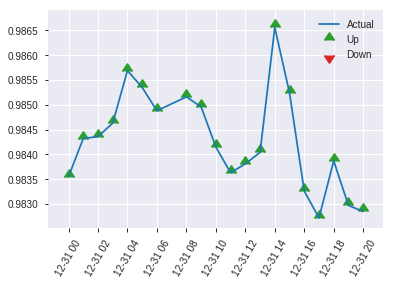


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26358412286760735
RMSE: 0.5134044437552204
LogLoss: 0.7282140397389861
Mean Per-Class Error: 0.4571083324577072
AUC: 0.5346117473993905
pr_auc: 0.5230902109177482
Gini: 0.0692234947987811
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27884704640237895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    305  0.9935   (305.0/307.0)
1      0    310  0        (0.0/310.0)
Total  2    615  0.4943   (305.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.278847     0.67027    397
max f2                       0.278847     0.83558    397
max f0point5                 0.278847     0.559567   397
max accuracy                 0.596235     0.54295    205
max precision                0.778045     0.6        19
max recall                   0.278847     1          397
max specificity              0.978833     0.996743   0
max absolute_mcc             0.596235     0.0858077  205
max min_per_class_accuracy   0.598074     0.540717   202
max mean_per_class_accuracy  0.596235     0.542892   205

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 60.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.834167           0.852995  0.852995           0.428571         0.897073  0.428571                    0.897073            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.791041           1.32688   1.07171            0.666667         0.806411  0.538462                    0.855229            0.0129032       0.0225806                  32.6882    7.17122
    3        0.0307942                   0.779151           1.32688   1.15229            0.666667         0.783054  0.578947                    0.832437            0.0129032       0.0354839                  32.6882    15.2292
    4        0.0405186                   0.765469           0.995161  1.11458            0.5              0.774491  0.56                        0.81853             0.00967742      0.0451613                  -0.483871  11.4581
    5        0.0502431                   0.745281           0.663441  1.02726            0.333333         0.754677  0.516129                    0.806171            0.00645161      0.0516129                  -33.6559   2.72633
    6        0.100486                    0.692663           1.02726   1.02726            0.516129         0.713008  0.516129                    0.75959             0.0516129       0.103226                   2.72633    2.72633
    7        0.150729                    0.670346           0.963059  1.00586            0.483871         0.68146   0.505376                    0.733547            0.0483871       0.151613                   -3.69407   0.586195
    8        0.200972                    0.653773           1.21988   1.05937            0.612903         0.661901  0.532258                    0.715635            0.0612903       0.212903                   21.9875    5.93652
    9        0.299838                    0.639823           1.17462   1.09737            0.590164         0.646948  0.551351                    0.692987            0.116129        0.329032                   17.4617    9.7367
    10       0.400324                    0.61684            1.05937   1.08783            0.532258         0.628307  0.546559                    0.676752            0.106452        0.435484                   5.93652    8.78281
    11       0.50081                     0.598074           1.05937   1.08212            0.532258         0.607275  0.543689                    0.662811            0.106452        0.541935                   5.93652    8.21171
    12       0.599676                    0.582907           0.880962  1.04895            0.442623         0.590721  0.527027                    0.650926            0.0870968       0.629032                   -11.9038   4.89538
    13       0.700162                    0.566454           0.963059  1.03663            0.483871         0.575033  0.520833                    0.640034            0.0967742       0.725806                   -3.69407   3.66263
    14       0.799028                    0.543431           0.783078  1.00525            0.393443         0.556906  0.505071                    0.629748            0.0774194       0.803226                   -21.6922   0.52542
    15       0.899514                    0.513557           0.930957  0.996954           0.467742         0.527833  0.500901                    0.618363            0.0935484       0.896774                   -6.90427   -0.304563
    16       1                           0.119271           1.02726   1                  0.516129         0.446937  0.502431                 

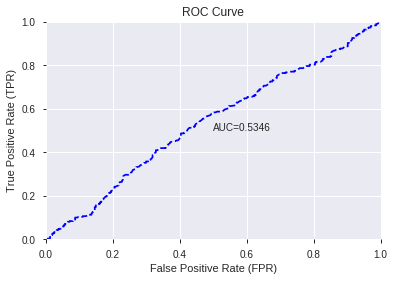

This function is available for GLM models only


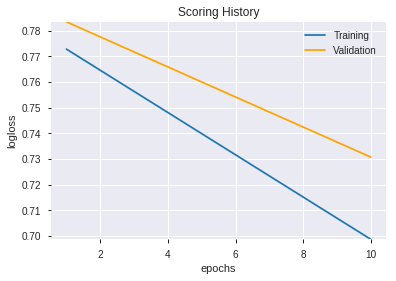

--2019-08-24 14:17:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.115.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.115.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190824_135633',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190824_135633',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_a66a'

['STOCHRSI_fastk',
 'CDLSTICKSANDWICH',
 'CORREL_12',
 'is_month_end',
 'CDLDARKCLOUDCOVER',
 'CDLSEPARATINGLINES',
 'CDLGAPSIDESIDEWHITE',
 'FLOOR',
 'is_quarter_start',
 'CDLLONGLEGGEDDOJI',
 'CDLIDENTICAL3CROWS',
 'CDLGRAVESTONEDOJI',
 'CORREL_8',
 'CDLHOMINGPIGEON',
 'CDLDOJI',
 'CORREL_20',
 'CEIL',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLHIKKAKEMOD',
 'CDL3WHITESOLDIERS',
 'CDL2CROWS',
 'CDLPIERCING',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CORREL_14',
 'BOP',
 'CDLRICKSHAWMAN',
 'CORREL_24',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLEVENINGSTAR',
 'SUB',
 'CDLTAKURI',
 'CDLSTALLEDPATTERN',
 'CDLDOJISTAR',
 'DX_8',
 'CDLHARAMICROSS',
 'CDLONNECK',
 'VAR_8',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'days_in_month',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLINVERTEDHAMMER']

In [14]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_141805_model_1  0.508028  0.69496              0.495098  0.500836  0.250837

variable  relative_importance  scaled_importance  percentage
0        STOCHRSI_fastk             0.044142           1.000000    0.068195
1                   BOP             0.039460           0.893930    0.060962
2     CDLDARKCLOUDCOVER             0.033135           0.750651    0.051191
3             CDLHAMMER             0.027492           0.622815    0.042473
4           CDLPIERCING             0.026995           0.611548    0.041705
5          is_month_end             0.024216           0.548602    0.037412
6        is_month_start             0.023833           0.539931    0.036821
7          CDLTHRUSTING             0.022989           0.520794    0.035516
8        CDLEVENINGSTAR             0.021896           0.496050    0.033828
9      CDLSTICKSANDWICH             0.021262           0.481680    0.032848
10       CDLRICKSHAWMAN             0.021027           0.476344    0.032484
11                VAR_8             0.019561           0.443152    0.030221
12            CDL2CROWS             0.016907           0.383006    0.026119
13  CDLGAPSIDESIDEWHITE             0.016766           0.379822    0.025902
14      CDLADVANCEBLOCK             0.016222           0.367495    0.025061
15      CDLLADDERBOTTOM             0.015566           0.352638    0.024048
16    CDLSTALLEDPATTERN             0.015344           0.347598    0.023705
17  CDLXSIDEGAP3METHODS             0.015222           0.344838    0.023516
18        days_in_month             0.015182           0.343945    0.023455
19        CDLHANGINGMAN             0.013636           0.308906    0.021066
20            CDLTAKURI             0.013476           0.305288    0.020819
21       CDL3LINESTRIKE             0.013382           0.303165    0.020674
22   CDLMORNINGDOJISTAR             0.012986           0.294183    0.020062
23    CDLGRAVESTONEDOJI             0.012182           0.275986    0.018821
24    CDLINVERTEDHAMMER             0.012069           0.273407    0.018645
25            CORREL_12             0.010718           0.242814    0.016559
26     is_quarter_start             0.009890           0.224041    0.015278
27            CORREL_24             0.009779           0.221535    0.015108
28                 DX_8             0.009747           0.220807    0.015058
29                 CEIL             0.009559           0.216562    0.014768
30      CDLHOMINGPIGEON             0.009064           0.205334    0.014003
31    CDL3WHITESOLDIERS             0.008835           0.200141    0.013649
32   CDLIDENTICAL3CROWS             0.008784           0.199005    0.013571
33   CDLSEPARATINGLINES             0.007583           0.171795    0.011716
34                FLOOR             0.007509           0.170117    0.011601
35     CDLDRAGONFLYDOJI             0.006494           0.147114    0.010032
36        CDLHIKKAKEMOD             0.005013           0.113575    0.007745
37                  SUB             0.004693           0.106311    0.007250
38       CDLMATCHINGLOW             0.004291           0.097200    0.006629
39       CDLMORNINGSTAR             0.004227           0.095751    0.006530
40          CDLDOJISTAR             0.003690           0.083592    0.005701
41      CDLSHOOTINGSTAR             0.003556           0.080550    0.005493
42   CDLEVENINGDOJISTAR             0.002955           0.066937    0.004565
43       CDLHARAMICROSS             0.002100           0.047580    0.003245
44            CDLONNECK             0.001728           0.039155    0.002670
45              CDLDOJI             0.000804           0.018214    0.001242
46             CORREL_8             0.000630           0.014282    0.000974
47            CORREL_20             0.000254           0.005749    0.000392
48    CDLLONGLEGGEDDOJI             0.000249           0.005633    0.000384
49            CORREL_14             0.000188           0.004251    0.000290

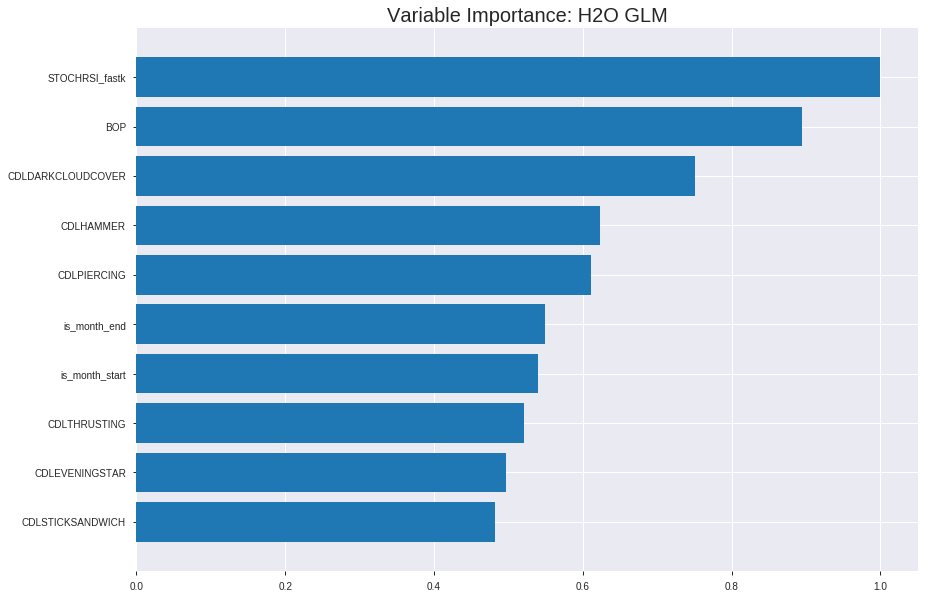

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_141805_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247289876077791
RMSE: 0.4972824912238425
LogLoss: 0.6876365313306579
Null degrees of freedom: 4312
Residual degrees of freedom: 4262
Null deviance: 5977.4123029576585
Residual deviance: 5931.552719258255
AIC: 6033.552719258255
AUC: 0.5603996484167785
pr_auc: 0.563025039633479
Gini: 0.12079929683355695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4141273683144649: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      28   2086  0.9868   (2086.0/2114.0)
1      7    2192  0.0032   (7.0/2199.0)
Total  35   4278  0.4853   (2093.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.414127     0.676857   372
max f2                       0.384511     0.839316   386
max f0point5                 0.483211     0.572563   282
max accuracy                 0.507188     0.543937   200
max precision                0.756906     1          0
max recall                   0.366243     1          390
max specificity              0.756906     1          0
max absolute_mcc             0.531616     0.0962358  122
max min_per_class_accuracy   0.509583     0.541627   193
max mean_per_class_accuracy  0.507188     0.543426   200

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.578467           1.20355   1.20355            0.613636         0.605237  0.613636                    0.605237            0.0122783       0.0122783                  20.3553    20.3553
    2        0.0201716                   0.568862           1.32277   1.26248            0.674419         0.573239  0.643678                    0.589422            0.0131878       0.0254661                  32.2768    26.2476
    3        0.0301414                   0.555886           1.27716   1.26733            0.651163         0.561626  0.646154                    0.580228            0.0127331       0.0381992                  27.7156    26.7331
    4        0.0401113                   0.551754           1.32277   1.28111            0.674419         0.553506  0.653179                    0.573586            0.0131878       0.051387                   32.2768    28.111
    5        0.0500812                   0.549702           0.912254  1.20768            0.465116         0.550488  0.615741                    0.568988            0.00909504      0.060482                   -8.7746    20.7681
    6        0.100162                    0.543212           1.18044   1.19406            0.601852         0.545923  0.608796                    0.557455            0.0591178       0.1196                     18.044     19.406
    7        0.150012                    0.53901            1.12207   1.17014            0.572093         0.541     0.5966                      0.551987            0.0559345       0.175534                   12.2072    17.0138
    8        0.200093                    0.535549           1.1078    1.15454            0.564815         0.537212  0.588644                    0.548289            0.0554798       0.231014                   10.7797    15.4535
    9        0.300023                    0.526604           1.07851   1.12921            0.549884         0.531301  0.575734                    0.542631            0.107776        0.33879                    7.85128    12.9214
    10       0.399954                    0.517844           0.99205   1.09494            0.5058           0.522366  0.558261                    0.537568            0.099136        0.437926                   -0.795025  9.49428
    11       0.500116                    0.509494           1.03061   1.08206            0.525463         0.51379   0.551692                    0.532806            0.103229        0.541155                   3.06147    8.20593
    12       0.600046                    0.501168           0.973847  1.06404            0.49652          0.505259  0.542504                    0.528218            0.097317        0.638472                   -2.6153    6.40378
    13       0.699977                    0.494795           0.960195  1.04921            0.489559         0.497843  0.534945                    0.523882            0.0959527       0.734425                   -3.98051   4.9213
    14       0.799907                    0.488556           0.937442  1.03525            0.477958         0.491671  0.527826                    0.519858            0.0936789       0.828104                   -6.25585   3.52496
    15       0.899838                    0.479572           0.923789  1.02287            0.470998         0.484746  0.521515                    0.515958            0.0923147       0.920418                   -7.62106   2.28715
    16       1                           0.254286           0.794527  1                  0.405093         0.455012  0.509854                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24840574842546398
RMSE: 0.49840319865091554
LogLoss: 0.6898551326273112
Null degrees of freedom: 1231
Residual degrees of freedom: 1181
Null deviance: 1705.7914799426171
Residual deviance: 1699.8030467936949
AIC: 1801.8030467936949
AUC: 0.5322200403312128
pr_auc: 0.55718953708063
Gini: 0.06444008066242568
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4121931074765939: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    576   0.988    (576.0/583.0)
1      0    649   0        (0.0/649.0)
Total  7    1225  0.4675   (576.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412193     0.692636  392
max f2                       0.412193     0.849254  392
max f0point5                 0.412193     0.58479   392
max accuracy                 0.500981     0.535714  225
max precision                0.753077     1         0
max recall                   0.412193     1         392
max specificity              0.753077     1         0
max absolute_mcc             0.412193     0.079757  392
max min_per_class_accuracy   0.505978     0.525424  206
max mean_per_class_accuracy  0.515125     0.534073  169

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.615622           1.46023   1.46023            0.769231         0.653685  0.769231                    0.653685            0.0154083       0.0154083                  46.0235   46.0235
    2        0.0202922                   0.585574           0.949153  1.21492            0.5              0.599192  0.64                        0.627528            0.00924499      0.0246533                  -5.08475  21.4915
    3        0.0300325                   0.5682             0.79096   1.07742            0.416667         0.574501  0.567568                    0.61033             0.00770416      0.0323575                  -20.904   7.74164
    4        0.0405844                   0.559389           1.16819   1.10102            0.615385         0.562827  0.58                        0.597979            0.0123267       0.0446841                  16.8188   10.1017
    5        0.0503247                   0.549145           0.79096   1.04101            0.416667         0.553183  0.548387                    0.589309            0.00770416      0.0523883                  -20.904   4.1006
    6        0.100649                    0.541698           1.13286   1.08693            0.596774         0.544122  0.572581                    0.566716            0.0570108       0.109399                   13.2859   8.69328
    7        0.150162                    0.537565           1.15143   1.1082             0.606557         0.539732  0.583784                    0.557818            0.0570108       0.16641                    15.1431   10.82
    8        0.200487                    0.533622           0.887917  1.05291            0.467742         0.535618  0.554656                    0.552246            0.0446841       0.211094                   -11.2083  5.29061
    9        0.300325                    0.524076           1.09577   1.06716            0.577236         0.528759  0.562162                    0.544438            0.109399        0.320493                   9.57696   6.71553
    10       0.400162                    0.514493           1.09577   1.07429            0.577236         0.519202  0.565923                    0.538142            0.109399        0.429892                   9.57696   7.42944
    11       0.5                         0.505948           0.941436  1.04777            0.495935         0.510379  0.551948                    0.532598            0.0939908       0.523883                   -5.85641  4.77658
    12       0.599838                    0.49785            0.956869  1.03264            0.504065         0.501947  0.543978                    0.527497            0.0955316       0.619414                   -4.31308  3.26369
    13       0.699675                    0.491114           0.895136  1.01302            0.471545         0.494407  0.533643                    0.522775            0.0893683       0.708783                   -10.4864  1.30166
    14       0.799513                    0.485375           1.0186    1.01371            0.536585         0.488247  0.53401                     0.518464            0.101695        0.810478                   1.86027   1.37142
    15       0.899351                    0.473859           0.941436  1.00569            0.495935         0.480137  0.529783                    0.514209            0.0939908       0.904468                   -5.85641  0.569051
    16       1                           0.240805           0.949153  1                  0.5              0.455594  0.526786                    0.508309           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:18:06  0.000 sec   2            2.7       51            1.38327           1.38281
    2019-08-24 14:18:06  0.054 sec   4            1.7       51            1.38208           1.3821
    2019-08-24 14:18:06  0.104 sec   6            1         51            1.38057           1.38128
    2019-08-24 14:18:06  0.137 sec   8            0.65      51            1.37882           1.3805
    2019-08-24 14:18:06  0.171 sec   10           0.4       51            1.37699           1.37993
    2019-08-24 14:18:06  0.203 sec   12           0.25      51            1.37527           1.37971
    2019-08-24 14:18:06  0.229 sec   14           0.16      51            1.37382           1.37991
    2019-08-24 14:18:06  0.253 sec   16           0.097     51            1.37269           1.38046
    2019-08-24 14:18:06  0.271 sec   18           0.06      51            1.37187           1.38125
    2019-08-24 14:18:06  0.285 sec   19           0.037     51            1.37132           1.38216
    2019-08-24 14:18:06  0.300 sec   20           0.023     51            1.37094           1.38304

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6702819956616052)

('auc', 0.5080277398339813)

('logloss', 0.6949600854373283)

('mean_per_class_error', 0.48151728485867396)

('rmse', 0.5008364761630884)

('mse', 0.2508371758554598)

glm prediction progress: |████████████████████████████████████████████████| 100%


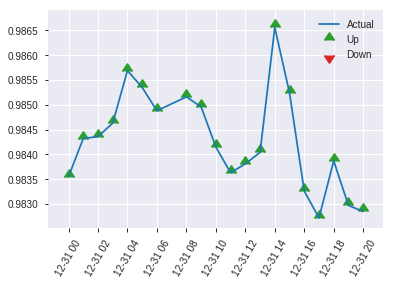


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2508371758554598
RMSE: 0.5008364761630884
LogLoss: 0.6949600854373283
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.4650475313558
Residual deviance: 857.580745429663
AIC: 959.580745429663
AUC: 0.5080277398339813
pr_auc: 0.505748949807053
Gini: 0.016055479667962613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4204468251392232: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    303  0.987    (303.0/307.0)
1      1    309  0.0032   (1.0/310.0)
Total  5    612  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.420447     0.670282   394
max f2                       0.379389     0.83558    397
max f0point5                 0.47955      0.56031    328
max accuracy                 0.480049     0.520259   326
max precision                0.545606     0.6        31
max recall                   0.379389     1          397
max specificity              0.741155     0.996743   0
max absolute_mcc             0.732357     0.0573045  1
max min_per_class_accuracy   0.508156     0.512903   196
max mean_per_class_accuracy  0.480049     0.518483   326

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.57657            0.852995  0.852995           0.428571         0.623855  0.428571                    0.623855            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.565925           1.32688   1.07171            0.666667         0.570389  0.538462                    0.599178            0.0129032       0.0225806                  32.6882    7.17122
    3        0.0307942                   0.55186            0.663441  0.942784           0.333333         0.557562  0.473684                    0.586036            0.00645161      0.0290323                  -33.6559   -5.72156
    4        0.0405186                   0.549307           0.995161  0.955355           0.5              0.550357  0.48                        0.577473            0.00967742      0.0387097                  -0.483871  -4.46452
    5        0.0502431                   0.546616           1.6586    1.09147            0.833333         0.548043  0.548387                    0.571777            0.016129        0.0548387                  65.8602    9.14672
    6        0.100486                    0.540757           0.898855  0.995161           0.451613         0.543677  0.5                         0.557727            0.0451613       0.1                        -10.1145   -0.483871
    7        0.150729                    0.538038           1.21988   1.07007            0.612903         0.539378  0.537634                    0.551611            0.0612903       0.16129                    21.9875    7.00659
    8        0.200972                    0.535031           0.64204   0.963059           0.322581         0.536331  0.483871                    0.547791            0.0322581       0.193548                   -35.796    -3.69407
    9        0.299838                    0.52812            1.17462   1.03282            0.590164         0.531813  0.518919                    0.542522            0.116129        0.309677                   17.4617    3.2816
    10       0.400324                    0.51778            0.995161  1.02336            0.5              0.522526  0.51417                     0.537503            0.1             0.409677                   -0.483871  2.33642
    11       0.50081                     0.507685           1.02726   1.02415            0.516129         0.512587  0.514563                    0.532504            0.103226        0.512903                   2.72633    2.41466
    12       0.599676                    0.499243           0.783078  0.984403           0.393443         0.503796  0.494595                    0.527771            0.0774194       0.590323                   -21.6922   -1.55972
    13       0.700162                    0.492556           1.21988   1.0182             0.612903         0.495733  0.511574                    0.523173            0.122581        0.712903                   21.9875    1.81974
    14       0.799028                    0.486085           0.880962  1.00122            0.442623         0.489235  0.503043                    0.518974            0.0870968       0.8                        -11.9038   0.121704
    15       0.899514                    0.475608           1.09147   1.0113             0.548387         0.481341  0.508108                    0.514769            0.109677        0.909677                   9.14672    1.1299
    16       1                           0.263385           0.898855  1                  0.451613         0.451476  0.502431              

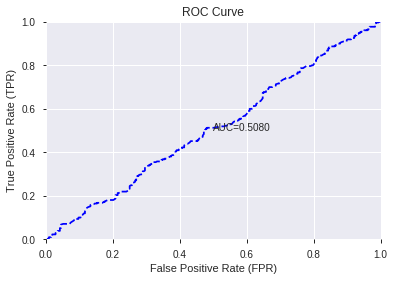

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


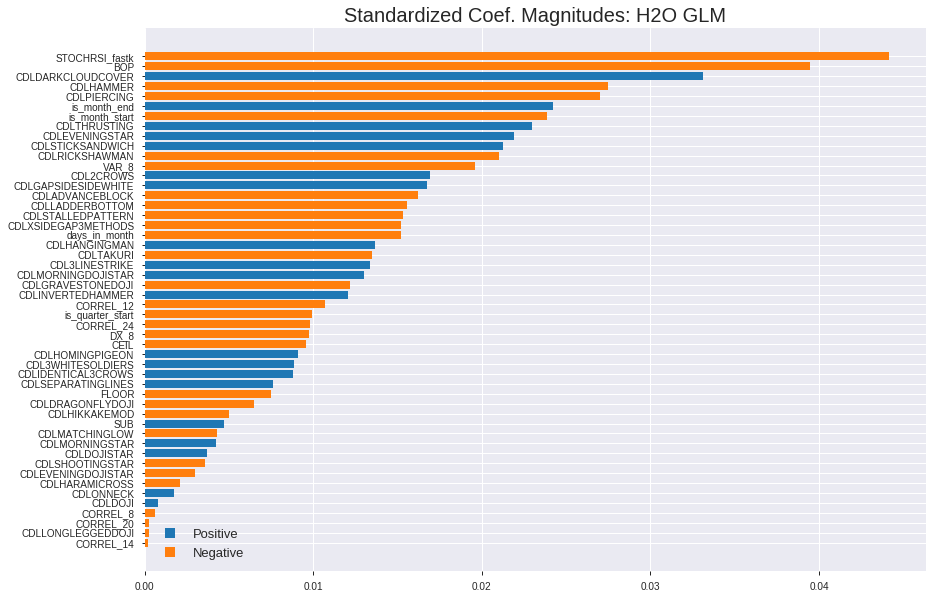

'log_likelihood'
--2019-08-24 14:18:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_141805_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_141805_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['STOCHRSI_fastk',
 'BOP',
 'CDLDARKCLOUDCOVER',
 'CDLHAMMER',
 'CDLPIERCING',
 'is_month_end',
 'is_month_start',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'VAR_8',
 'CDL2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'CDLXSIDEGAP3METHODS',
 'days_in_month',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CORREL_12',
 'is_quarter_start',
 'CORREL_24',
 'DX_8',
 'CEIL',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLSEPARATINGLINES',
 'FLOOR',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKEMOD',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLMORNINGSTAR',
 'CDLDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLHARAMICROSS',
 'CDLONNECK',
 'CDLDOJI',
 'CORREL_8',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'CORREL_14']

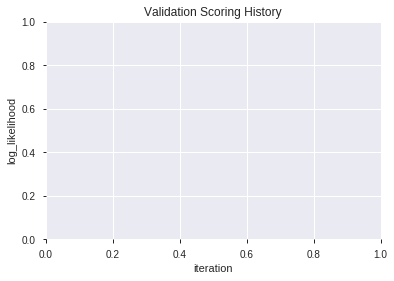

In [15]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_141913_model_4  0.496422  0.701540              0.498371  0.504104  0.254120
1  XGBoost_grid_1_AutoML_20190824_141913_model_3  0.492335  0.702665              0.500000  0.504625  0.254647
2  XGBoost_grid_1_AutoML_20190824_141913_model_7  0.490328  0.711821              0.498371  0.508886  0.258965
3               XGBoost_2_AutoML_20190824_141913  0.489908  0.710462              0.500000  0.508334  0.258403
4  XGBoost_grid_1_AutoML_20190824_141913_model_6  0.488426  0.702902              0.498371  0.504746  0.254769
5               XGBoost_1_AutoML_20190824_141913  0.485846  0.712598              0.500000  0.509250  0.259335
6  XGBoost_grid_1_AutoML_20190824_141913_model_5  0.481953  0.734728              0.500000  0.518473  0.268815
7  XGBoost_grid_1_AutoML_20190824_141913_model_2  0.478980  0.704758              0.498371  0.505687  0.255719
8               XGBoost_3_AutoML_20190824_141913  0.469996  0.705836              0.498356  0.506173  0.256211
9  XGBoost_grid_1_AutoML_20190824_141913_model_1  0.468950  0.707351              0.498356  0.506828  0.256875

variable  relative_importance  scaled_importance  percentage
0             BOP           720.208008           1.000000    0.250062
1            DX_8           589.487549           0.818496    0.204675
2           VAR_8           475.938599           0.660835    0.165250
3  STOCHRSI_fastk           459.283173           0.637709    0.159467
4             SUB           411.436584           0.571275    0.142854
5       CORREL_24           121.291519           0.168412    0.042113
6   days_in_month            51.138550           0.071005    0.017756
7       CORREL_20            27.665525           0.038413    0.009606
8  CDLRICKSHAWMAN            23.670292           0.032866    0.008219

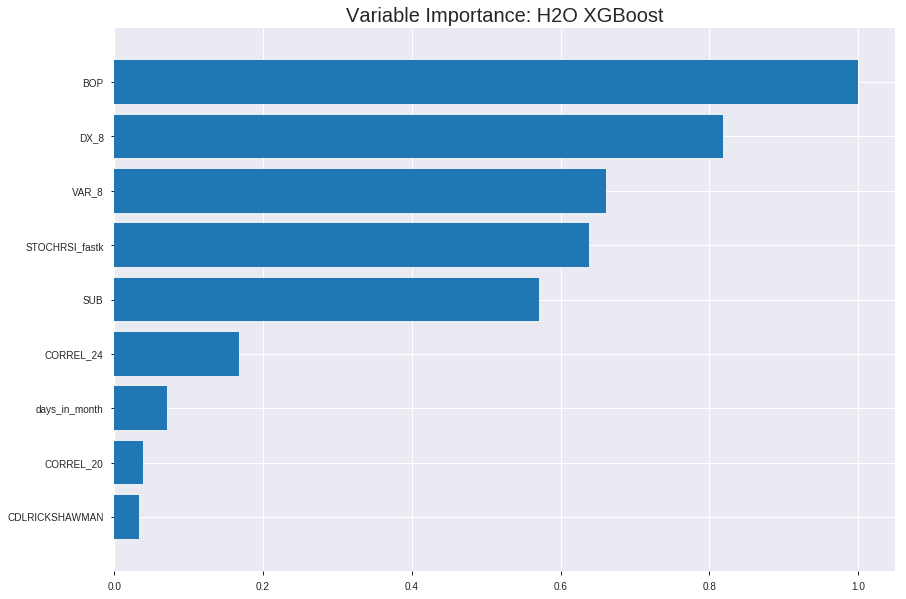

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_141913_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23724789295281362
RMSE: 0.48708099219001927
LogLoss: 0.6673967846322453
Mean Per-Class Error: 0.38309137248676295
AUC: 0.6636150516511548
pr_auc: 0.6587919295372072
Gini: 0.3272301033023095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44814756283393276: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      439  1675  0.7923   (1675.0/2114.0)
1      144  2055  0.0655   (144.0/2199.0)
Total  583  3730  0.4217   (1819.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448148     0.693203  302
max f2                       0.392897     0.839794  367
max f0point5                 0.498511     0.625471  209
max accuracy                 0.498511     0.618131  209
max precision                0.664715     1         0
max recall                   0.361835     1         390
max specificity              0.664715     1         0
max absolute_mcc             0.497964     0.235763  210
max min_per_class_accuracy   0.508197     0.612551  192
max mean_per_class_accuracy  0.498511     0.616909  209

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.62378            1.78304   1.78304            0.909091         0.634856  0.909091                    0.634856            0.0181901       0.0181901                  78.3042   78.3042
    2        0.0201716                   0.611356           1.55083   1.66827            0.790698         0.616748  0.850575                    0.625906            0.0154616       0.0336517                  55.0832   66.8271
    3        0.0301414                   0.604391           1.41399   1.58416            0.72093          0.607645  0.807692                    0.619866            0.0140973       0.047749                   41.3994   58.4164
    4        0.0401113                   0.597683           1.50522   1.56454            0.767442         0.601115  0.797688                    0.615205            0.0150068       0.0627558                  50.5219   56.4542
    5        0.0500812                   0.593291           1.55083   1.56181            0.790698         0.595562  0.796296                    0.611295            0.0154616       0.0782174                  55.0832   56.1813
    6        0.100162                    0.57717            1.40745   1.48463            0.717593         0.58437   0.756944                    0.597833            0.0704866       0.148704                   40.7447   48.463
    7        0.150012                    0.565075           1.31365   1.42781            0.669767         0.571224  0.727975                    0.58899             0.0654843       0.214188                   31.3646   42.7811
    8        0.200093                    0.554387           1.23492   1.37953            0.62963          0.559613  0.70336                     0.581638            0.0618463       0.276035                   23.4922   37.9533
    9        0.300023                    0.537306           1.19228   1.31716            0.607889         0.545687  0.671561                    0.569663            0.119145        0.39518                    19.228    31.7164
    10       0.399954                    0.523272           1.13767   1.27232            0.580046         0.530308  0.648696                    0.55983             0.113688        0.508868                   13.7672   27.2317
    11       0.500116                    0.508014           1.03515   1.22482            0.527778         0.515503  0.624478                    0.550953            0.103683        0.612551                   3.51549   22.4818
    12       0.600046                    0.492709           0.969296  1.18226            0.4942           0.500191  0.602782                    0.542499            0.0968622       0.709413                   -3.07037  18.2264
    13       0.699977                    0.478225           0.919239  1.14471            0.468677         0.48527   0.583637                    0.534329            0.0918599       0.801273                   -8.07612  14.4714
    14       0.799907                    0.461432           0.891935  1.11313            0.454756         0.469852  0.567536                    0.526274            0.0891314       0.890405                   -10.8065  11.3135
    15       0.899838                    0.438836           0.641647  1.06077            0.327146         0.450898  0.54084                     0.517903            0.0641201       0.954525                   -35.8353  6.07744
    16       1                           0.324488           0.454015  1                  0.231481         0.412293  0.509854                    0.507325          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24859310653753897
RMSE: 0.4985911215991907
LogLoss: 0.6904126217980819
Mean Per-Class Error: 0.4393987847777423
AUC: 0.5491903363665436
pr_auc: 0.5543244506037005
Gini: 0.09838067273308715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3415650427341461: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    583   1        (583.0/583.0)
1      0    649   0        (0.0/649.0)
Total  0    1232  0.4732   (583.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341565     0.690058  399
max f2                       0.341565     0.847701  399
max f0point5                 0.504153     0.583658  222
max accuracy                 0.508151     0.560877  213
max precision                0.524882     0.598441  176
max recall                   0.341565     1         399
max specificity              0.651075     0.998285  0
max absolute_mcc             0.522437     0.122142  182
max min_per_class_accuracy   0.509747     0.554031  209
max mean_per_class_accuracy  0.522437     0.560601  182

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.625661           0.730117  0.730117           0.384615         0.635826  0.384615                    0.635826            0.00770416      0.00770416                 -26.9883  -26.9883
    2        0.0202922                   0.613497           1.42373   1.06305            0.75             0.618628  0.56                        0.627571            0.0138675       0.0215716                  42.3729   6.30508
    3        0.0300325                   0.609919           0.949153  1.02611            0.5              0.611864  0.540541                    0.622477            0.00924499      0.0308166                  -5.08475  2.61109
    4        0.0405844                   0.602478           1.02216   1.02508            0.538462         0.606075  0.54                        0.618212            0.0107858       0.0416025                  2.21643   2.50847
    5        0.0503247                   0.597526           0.949153  1.01039            0.5              0.599553  0.532258                    0.614601            0.00924499      0.0508475                  -5.08475  1.03882
    6        0.100649                    0.578815           0.949153  0.97977            0.5              0.586427  0.516129                    0.600514            0.0477658       0.0986133                  -5.08475  -2.02296
    7        0.150162                    0.567534           1.12031   1.02611            0.590164         0.573525  0.540541                    0.591615            0.05547         0.154083                   12.0311   2.61109
    8        0.200487                    0.557922           1.28595   1.09133            0.677419         0.562699  0.574899                    0.584357            0.0647149       0.218798                   28.5949   9.13333
    9        0.300325                    0.542696           1.04947   1.07742            0.552846         0.54983   0.567568                    0.572879            0.104777        0.323575                   4.94695   7.74164
    10       0.400162                    0.526902           1.2501    1.1205             0.658537         0.535353  0.590264                    0.563516            0.124807        0.448382                   25.0103   12.0501
    11       0.5                         0.51012            1.04947   1.10632            0.552846         0.518459  0.582792                    0.554519            0.104777        0.553159                   4.94695   10.6317
    12       0.599838                    0.495789           0.848836  1.06346            0.447154         0.503285  0.560217                    0.545992            0.0847458       0.637904                   -15.1164  6.34618
    13       0.699675                    0.47893            0.879702  1.03724            0.463415         0.4877    0.546404                    0.537674            0.0878274       0.725732                   -12.0298  3.72409
    14       0.799513                    0.460569           0.987736  1.03106            0.520325         0.470778  0.543147                    0.529321            0.0986133       0.824345                   -1.2264   3.10591
    15       0.899351                    0.439474           0.771669  1.00226            0.406504         0.450329  0.527978                    0.520552            0.0770416       0.901387                   -22.8331  0.226397
    16       1                           0.341565           0.97977   1                  0.516129         0.415322  0.526786                    0.50996       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:19:31  3.104 sec   0                  0.5              0.693147            0.5             0                  1                0.490146                         0.5                0.693147              0.5               0                    1                  0.473214
    2019-08-24 14:19:31  3.182 sec   5                  0.497849         0.688851            0.607706        0.602834           1.50231          0.474843                         0.49904            0.691228              0.550073          0.553508             1.00499            0.473214
    2019-08-24 14:19:31  3.243 sec   10                 0.496301         0.685766            0.617495        0.615049           1.51559          0.46696                          0.498996           0.691142              0.542599          0.547764             0.876141           0.473214
    2019-08-24 14:19:31  3.333 sec   15                 0.494511         0.682203            0.628229        0.625949           1.56016          0.452585                         0.498283           0.68972               0.553308          0.556921             1.02216            0.473214
    2019-08-24 14:19:32  3.411 sec   20                 0.493084         0.679365            0.639219        0.632896           1.47101          0.423371                         0.498126           0.68941               0.553107          0.560674             1.02216            0.473214
    2019-08-24 14:19:32  3.486 sec   25                 0.492114         0.67743             0.641337        0.635779           1.60474          0.425922                         0.498234           0.689626              0.548519          0.560212             0.876141           0.473214
    2019-08-24 14:19:32  3.581 sec   30                 0.490793         0.674799            0.646804        0.639704           1.56016          0.413633                         0.498161           0.689499              0.550738          0.55582              0.730117           0.473214
    2019-08-24 14:19:32  3.718 sec   35                 0.489781         0.672784            0.652023        0.643626           1.60474          0.42198                          0.498297           0.689783              0.550742          0.556697             0.876141           0.473214
    2019-08-24 14:19:32  3.806 sec   40                 0.488944         0.671114            0.656225        0.650009           1.69389          0.422907                         0.498594           0.690394              0.548359          0.553988             0.876141           0.473214
    2019-08-24 14:19:32  3.905 sec   45                 0.487813         0.668856            0.660444        0.656036           1.78304          0.402272                         0.498393           0.690003              0.551885          0.556471             0.730117           0.473214
    2019-08-24 14:19:32  4.002 sec   50                 0.487081         0.667397            0.663615        0.658792           1.78304          0.421748                         0.498591           0.690413              0.54919           0.554324             0.730117           0.473214

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             720.208                1                    0.250062
DX_8            589.488                0.818496             0.204675
VAR_8           475.939                0.660835             0.16525
STOCHRSI_fastk  459.283                0.637709             0.159467
SUB             411.437                0.571275             0.142854
CORREL_24       121.292                0.168412             0.0421134
days_in_month   51.1385                0.0710053            0.0177557
CORREL_20       27.6655                0.0384132            0.00960569
CDLRICKSHAWMAN  23.6703                0.0328659            0.00821851

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5170178282009724)

('F1', 0.6695464362850972)

('auc', 0.49642219186718506)

('logloss', 0.7015395624094499)

('mean_per_class_error', 0.48357675738152783)

('rmse', 0.50410351393626)

('mse', 0.2541203527628851)

xgboost prediction progress: |████████████████████████████████████████████| 100%


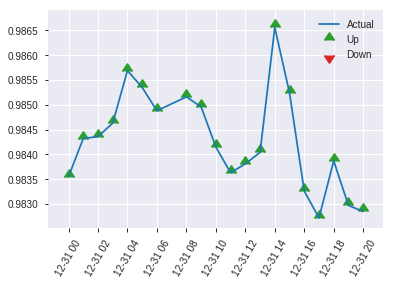


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541203527628851
RMSE: 0.50410351393626
LogLoss: 0.7015395624094499
Mean Per-Class Error: 0.48357675738152783
AUC: 0.49642219186718506
pr_auc: 0.5110303078753867
Gini: -0.007155616265629883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3571642339229584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    306  0.9967   (306.0/307.0)
1      0    310  0        (0.0/310.0)
Total  1    616  0.4959   (306.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357164     0.669546  398
max f2                       0.357164     0.835129  398
max f0point5                 0.357164     0.55876   398
max accuracy                 0.485614     0.517018  241
max precision                0.645316     1         0
max recall                   0.357164     1         398
max specificity              0.645316     1         0
max absolute_mcc             0.429017     0.12467   354
max min_per_class_accuracy   0.506342     0.504886  195
max mean_per_class_accuracy  0.485614     0.516423  241

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.614913           1.42166   1.42166            0.714286         0.626456  0.714286                    0.626456            0.016129        0.016129                   42.1659   42.1659
    2        0.0210697                   0.605027           0.663441  1.07171            0.333333         0.608443  0.538462                    0.618142            0.00645161      0.0225806                  -33.6559  7.17122
    3        0.0307942                   0.602566           1.32688   1.15229            0.666667         0.603477  0.578947                    0.613511            0.0129032       0.0354839                  32.6882   15.2292
    4        0.0405186                   0.599759           1.32688   1.19419            0.666667         0.60152   0.6                         0.610633            0.0129032       0.0483871                  32.6882   19.4194
    5        0.0502431                   0.597526           1.32688   1.21988            0.666667         0.59851   0.612903                    0.608287            0.0129032       0.0612903                  32.6882   21.9875
    6        0.100486                    0.578751           0.706243  0.963059           0.354839         0.587344  0.483871                    0.597815            0.0354839       0.0967742                  -29.3757  -3.69407
    7        0.150729                    0.563245           1.28408   1.07007            0.645161         0.570779  0.537634                    0.588803            0.0645161       0.16129                    28.4079   7.00659
    8        0.200972                    0.554531           0.963059  1.04331            0.483871         0.557461  0.524194                    0.580968            0.0483871       0.209677                   -3.69407  4.33143
    9        0.299838                    0.538178           0.880962  0.989782           0.442623         0.546671  0.497297                    0.569659            0.0870968       0.296774                   -11.9038  -1.0218
    10       0.400324                    0.521192           1.02726   0.99919            0.516129         0.529634  0.502024                    0.559612            0.103226        0.4                        2.72633   -0.0809717
    11       0.50081                     0.506342           1.05937   1.01126            0.532258         0.513575  0.508091                    0.550375            0.106452        0.506452                   5.93652   1.12642
    12       0.599676                    0.490456           0.978847  1.00592            0.491803         0.498189  0.505405                    0.541771            0.0967742       0.603226                   -2.11528  0.591979
    13       0.700162                    0.469738           0.963059  0.999769           0.483871         0.479936  0.502315                    0.532897            0.0967742       0.7                        -3.69407  -0.0231481
    14       0.799028                    0.454118           0.880962  0.985068           0.442623         0.461715  0.494929                    0.524089            0.0870968       0.787097                   -11.9038  -1.49316
    15       0.899514                    0.432873           0.834651  0.968265           0.419355         0.44533   0.486486                    0.515291            0.083871        0.870968                   -16.5349  -3.1735
    16       1                           0.319501           1.28408   1                  0.645161         0.404979  0.502431                    0.504206

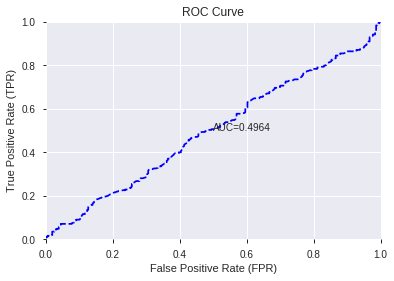

This function is available for GLM models only


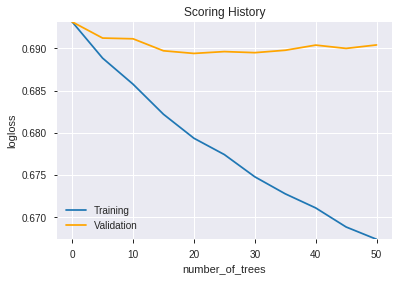

--2019-08-24 14:19:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_141913_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_141913_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DX_8',
 'VAR_8',
 'STOCHRSI_fastk',
 'SUB',
 'CORREL_24',
 'days_in_month',
 'CORREL_20',
 'CDLRICKSHAWMAN']

In [16]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_142045_model_1  0.498419  0.694098              0.495067  0.500475  0.250475

variable  relative_importance  scaled_importance  percentage
0               STOCHRSI_fastk             0.009363           1.000000    0.015115
1                          BOP             0.008705           0.929676    0.014052
2               CDLSPINNINGTOP             0.007856           0.839044    0.012682
3            CDLDARKCLOUDCOVER             0.006929           0.740060    0.011186
4                 CDLSHORTLINE             0.006792           0.725436    0.010965
...                        ...                  ...                ...         ...
1033                   MA_14_1             0.000000           0.000000    0.000000
1034  BBANDS_middleband_14_1_2             0.000000           0.000000    0.000000
1035                   MA_14_2             0.000000           0.000000    0.000000
1036  BBANDS_middleband_30_5_3             0.000000           0.000000    0.000000
1037  BBANDS_middleband_30_5_4             0.000000           0.000000    0.000000

[1038 rows x 4 columns]

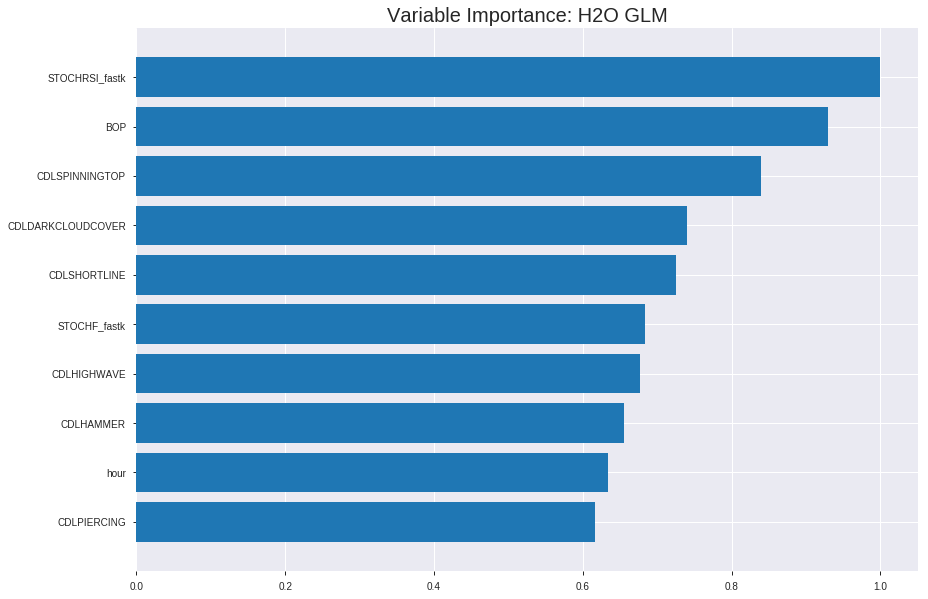

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_142045_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24778917866880512
RMSE: 0.497784269205853
LogLoss: 0.6887150663290209
Null degrees of freedom: 4312
Residual degrees of freedom: 3282
Null deviance: 5977.4123029576585
Residual deviance: 5940.856162154133
AIC: 8002.856162154133
AUC: 0.5712485205496779
pr_auc: 0.5707556257790918
Gini: 0.1424970410993558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4382638445421154: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      18   2096  0.9915   (2096.0/2114.0)
1      5    2194  0.0023   (5.0/2199.0)
Total  23   4290  0.4871   (2101.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438264     0.676221  381
max f2                       0.398919     0.838993  395
max f0point5                 0.503256     0.575526  221
max accuracy                 0.507828     0.55553   199
max precision                0.578844     1         0
max recall                   0.398919     1         395
max specificity              0.578844     1         0
max absolute_mcc             0.516594     0.111596  151
max min_per_class_accuracy   0.511134     0.554798  181
max mean_per_class_accuracy  0.511829     0.5553    177

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.549572           1.33728   1.33728            0.681818         0.555754  0.681818                    0.555754            0.0136426       0.0136426                  33.7281    33.7281
    2        0.0201716                   0.546446           1.36838   1.35265            0.697674         0.547672  0.689655                    0.55176             0.0136426       0.0272851                  36.8381    35.2652
    3        0.0301414                   0.544516           1.0947    1.26733            0.55814          0.545439  0.646154                    0.549669            0.0109141       0.0381992                  9.47048    26.7331
    4        0.0401113                   0.542237           0.957867  1.19041            0.488372         0.543541  0.606936                    0.548146            0.0095498       0.047749                   -4.21333   19.0412
    5        0.0500812                   0.539742           1.27716   1.20768            0.651163         0.540983  0.615741                    0.54672             0.0127331       0.060482                   27.7156    20.7681
    6        0.100162                    0.534608           1.13504   1.17136            0.578704         0.53694   0.597222                    0.54183             0.056844        0.117326                   13.5038    17.1359
    7        0.150012                    0.530543           1.23154   1.19136            0.627907         0.532446  0.607419                    0.538712            0.0613915       0.178718                   23.1543    19.1359
    8        0.200093                    0.527022           1.17136   1.18635            0.597222         0.528889  0.604867                    0.536253            0.058663        0.237381                   17.1359    18.6353
    9        0.300023                    0.520853           1.09672   1.1565             0.559165         0.523688  0.589645                    0.532068            0.109595        0.346976                   9.67155    15.6497
    10       0.399954                    0.516058           1.05121   1.13019            0.535963         0.518351  0.576232                    0.528641            0.105048        0.452024                   5.12087    13.019
    11       0.500116                    0.511116           1.01245   1.10661            0.516204         0.513554  0.56421                     0.525619            0.10141         0.553433                   1.24541    10.661
    12       0.600046                    0.506269           0.923789  1.07616            0.470998         0.508812  0.548686                    0.52282             0.0923147       0.645748                   -7.62106   7.61636
    13       0.699977                    0.501076           0.9966    1.0648             0.508121         0.503794  0.542895                    0.520104            0.0995907       0.745339                   -0.339956  6.4805
    14       0.799907                    0.494798           0.869181  1.04037            0.443155         0.498086  0.530435                    0.517353            0.0868577       0.832196                   -13.0819   4.03662
    15       0.899838                    0.484582           0.869181  1.02136            0.443155         0.490384  0.520742                    0.514358            0.0868577       0.919054                   -13.0819   2.13554
    16       1                           0.377778           0.808147  1                  0.412037         0.469388  0.509854                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24905459135946756
RMSE: 0.4990536958679572
LogLoss: 0.6912547772697669
Null degrees of freedom: 1231
Residual degrees of freedom: 201
Null deviance: 1705.7914799426171
Residual deviance: 1703.2517711927057
AIC: 3765.2517711927057
AUC: 0.5326085520143141
pr_auc: 0.5468294414573177
Gini: 0.06521710402862824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4485647679607355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    578   0.9914   (578.0/583.0)
1      0    649   0        (0.0/649.0)
Total  5    1227  0.4692   (578.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.448565     0.691898   395
max f2                       0.448565     0.84881    395
max f0point5                 0.453509     0.584133   389
max accuracy                 0.491333     0.539773   277
max precision                0.562639     1          0
max recall                   0.448565     1          395
max specificity              0.562639     1          0
max absolute_mcc             0.544341     0.0715337  10
max min_per_class_accuracy   0.506652     0.528505   188
max mean_per_class_accuracy  0.507053     0.532096   186

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 50.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.543753           0.43807   0.43807            0.230769         0.549981  0.230769                    0.549981            0.0046225       0.0046225                  -56.193   -56.193
    2        0.0202922                   0.541065           1.42373   0.911186           0.75             0.542348  0.48                        0.546317            0.0138675       0.01849                    42.3729   -8.88136
    3        0.0300325                   0.539544           1.42373   1.07742            0.75             0.540314  0.567568                    0.54437             0.0138675       0.0323575                  42.3729   7.74164
    4        0.0405844                   0.538194           0.876141  1.02508            0.461538         0.538978  0.54                        0.542968            0.00924499      0.0416025                  -12.3859  2.50847
    5        0.0503247                   0.53675            0.949153  1.01039            0.5              0.537304  0.532258                    0.541872            0.00924499      0.0508475                  -5.08475  1.03882
    6        0.100649                    0.530008           1.31657   1.16348            0.693548         0.533252  0.612903                    0.537562            0.0662558       0.117103                   31.6566   16.3477
    7        0.150162                    0.526365           0.964712  1.09794            0.508197         0.528275  0.578378                    0.5345              0.0477658       0.164869                   -3.52876  9.79386
    8        0.200487                    0.522726           1.07162   1.09133            0.564516         0.524528  0.574899                    0.531997            0.0539291       0.218798                   7.16238   9.13333
    9        0.300325                    0.516255           0.910569  1.03124            0.479675         0.519491  0.543243                    0.527839            0.0909091       0.309707                   -8.94309  3.12414
    10       0.400162                    0.511248           1.12664   1.05504            0.593496         0.513461  0.555781                    0.524252            0.112481        0.422188                   12.6636   5.50418
    11       0.5                         0.50661            1.0649    1.05701            0.560976         0.508804  0.556818                    0.521167            0.106317        0.528505                   6.49029   5.70108
    12       0.599838                    0.501645           0.956869  1.04034            0.504065         0.504097  0.548038                    0.518326            0.0955316       0.624037                   -4.31308  4.03431
    13       0.699675                    0.495147           0.956869  1.02843            0.504065         0.498573  0.541763                    0.515508            0.0955316       0.719569                   -4.31308  2.84321
    14       0.799513                    0.489188           0.941436  1.01757            0.495935         0.492442  0.536041                    0.512627            0.0939908       0.813559                   -5.85641  1.75686
    15       0.899351                    0.479334           0.956869  1.01083            0.504065         0.484363  0.532491                    0.50949             0.0955316       0.909091                   -4.31308  1.08303
    16       1                           0.44138            0.903226  1                  0.475806         0.46811   0.526786                    0.505325        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:20:54  0.000 sec   2            2.7       1030          1.37894           1.38256
    2019-08-24 14:20:58  4.607 sec   4            2         1031          1.37743           1.38251
    2019-08-24 14:21:03  9.172 sec   6            1.4       1032          1.37566           1.3826
    2019-08-24 14:21:07  13.973 sec  8            1         1033          1.37365           1.38293
    2019-08-24 14:21:12  18.609 sec  10           0.76      1035          1.37141           1.38356
    2019-08-24 14:21:17  23.239 sec  12           0.56      1039          1.36899           1.38456
    2019-08-24 14:21:21  27.837 sec  14           0.4       1039          1.36643           1.38596

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.513776337115073)

('F1', 0.6688453159041394)

('auc', 0.4984186193128086)

('logloss', 0.6940978858640193)

('mean_per_class_error', 0.48432804455185463)

('rmse', 0.5004746399619295)

('mse', 0.250474865245023)

glm prediction progress: |████████████████████████████████████████████████| 100%


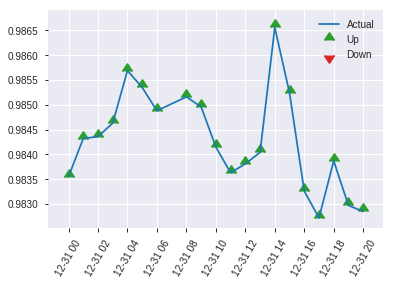


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.250474865245023
RMSE: 0.5004746399619295
LogLoss: 0.6940978858640193
Null degrees of freedom: 616
Residual degrees of freedom: -414
Null deviance: 855.4650475313558
Residual deviance: 856.5167911561998
AIC: 2918.5167911562
AUC: 0.4984186193128086
pr_auc: 0.5126763573991836
Gini: -0.003162761374382761
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44188315999179956: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    301  0.9805   (301.0/307.0)
1      3    307  0.0097   (3.0/310.0)
Total  9    608  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.441883     0.668845   390
max f2                       0.419453     0.83468    399
max f0point5                 0.461262     0.560641   362
max accuracy                 0.526316     0.513776   48
max precision                0.558742     1          0
max recall                   0.419453     1          399
max specificity              0.558742     1          0
max absolute_mcc             0.5508       0.0695608  2
max min_per_class_accuracy   0.501227     0.488599   185
max mean_per_class_accuracy  0.526316     0.515672   48

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.542736           1.42166   1.42166            0.714286         0.549628  0.714286                    0.549628            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.538717           0.995161  1.22481            0.5              0.540421  0.615385                    0.545378            0.00967742      0.0258065                  -0.483871  22.4814
    3        0.0307942                   0.535902           0.995161  1.15229            0.5              0.536712  0.578947                    0.542641            0.00967742      0.0354839                  -0.483871  15.2292
    4        0.0405186                   0.534285           0.995161  1.11458            0.5              0.534805  0.56                        0.540761            0.00967742      0.0451613                  -0.483871  11.4581
    5        0.0502431                   0.533574           0.995161  1.09147            0.5              0.533842  0.548387                    0.539422            0.00967742      0.0548387                  -0.483871  9.14672
    6        0.100486                    0.526713           1.15567   1.12357            0.580645         0.530247  0.564516                    0.534834            0.0580645       0.112903                   15.5671    12.3569
    7        0.150729                    0.522168           0.898855  1.04866            0.451613         0.524452  0.526882                    0.531374            0.0451613       0.158065                   -10.1145   4.86646
    8        0.200972                    0.519695           1.09147   1.05937            0.548387         0.520837  0.532258                    0.528739            0.0548387       0.212903                   9.14672    5.93652
    9        0.299838                    0.513181           0.946219  1.02206            0.47541          0.516498  0.513514                    0.524703            0.0935484       0.306452                   -5.37811   2.20575
    10       0.400324                    0.507432           0.834651  0.975016           0.419355         0.510268  0.489879                    0.52108             0.083871        0.390323                   -16.5349   -2.49837
    11       0.50081                     0.501207           0.995161  0.979058           0.5              0.504363  0.491909                    0.517726            0.1             0.490323                   -0.483871  -2.09416
    12       0.599676                    0.494891           1.10936   1.00054            0.557377         0.498214  0.502703                    0.514509            0.109677        0.6                        10.936     0.0540541
    13       0.700162                    0.488633           0.995161  0.999769           0.5              0.491874  0.502315                    0.51126             0.1             0.7                        -0.483871  -0.0231481
    14       0.799028                    0.480694           0.946219  0.993143           0.47541          0.485142  0.498986                    0.508029            0.0935484       0.793548                   -5.37811   -0.685729
    15       0.899514                    0.467329           1.02726   0.996954           0.516129         0.474562  0.500901                    0.50429             0.103226        0.896774                   2.72633    -0.304563
    16       1                           0.419453           1.02726   1                  0.516129         0.453796  0.502431         

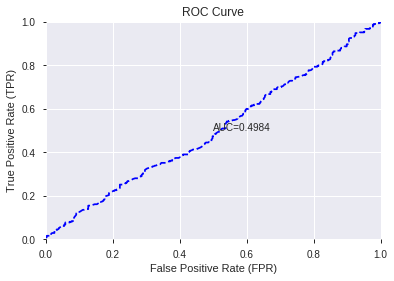

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


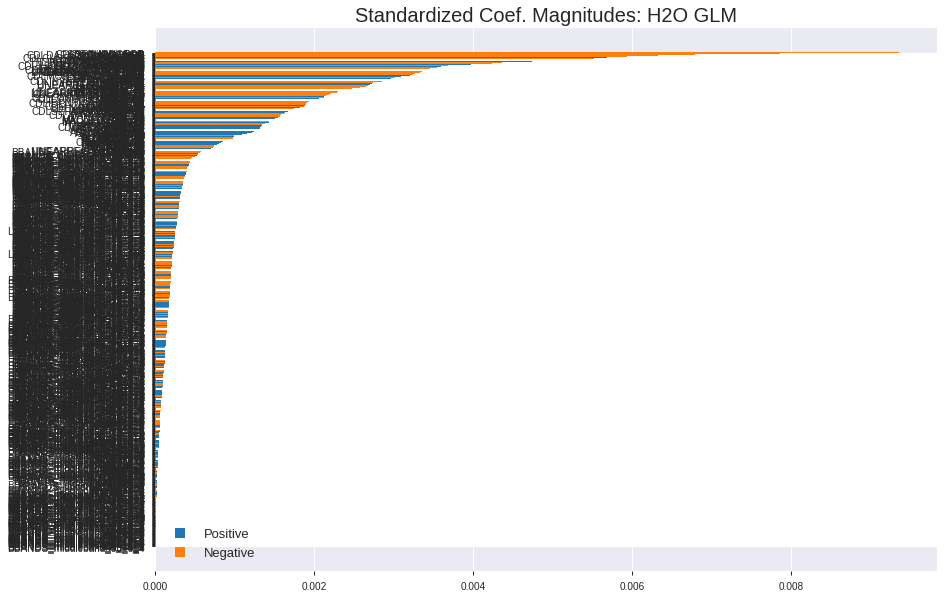

'log_likelihood'
--2019-08-24 14:21:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_142045_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_142045_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

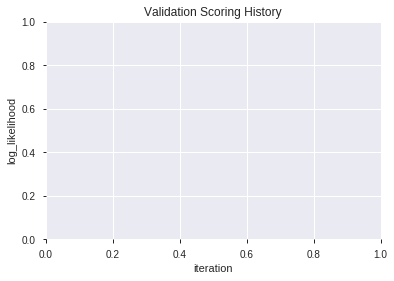

In [17]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [18]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [19]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [20]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_142244_model_6  0.535048  0.698897              0.477025  0.502797  0.252804
1  XGBoost_grid_1_AutoML_20190824_142244_model_1  0.534764  0.698651              0.495114  0.502610  0.252617
2  XGBoost_grid_1_AutoML_20190824_142244_model_5  0.530367  0.716392              0.495098  0.510081  0.260182
3               XGBoost_3_AutoML_20190824_142244  0.526931  0.698824              0.498371  0.502701  0.252708
4  XGBoost_grid_1_AutoML_20190824_142244_model_3  0.509247  0.706312              0.490212  0.506325  0.256365
5  XGBoost_grid_1_AutoML_20190824_142244_model_7  0.507224  0.713599              0.500000  0.509434  0.259523
6  XGBoost_grid_1_AutoML_20190824_142244_model_4  0.506100  0.700330              0.496743  0.503512  0.253524
7  XGBoost_grid_1_AutoML_20190824_142244_model_2  0.494967  0.702759              0.498371  0.504679  0.254701
8               XGBoost_2_AutoML_20190824_142244  0.480566  0.718441              0.500000  0.511775  0.261914
9               XGBoost_1_AutoML_20190824_142244  0.478617  0.723991              0.498371  0.514289  0.264493

variable  relative_importance  scaled_importance  percentage
0                        BOP           268.572754           1.000000    0.027954
1                     Volume           241.911163           0.900729    0.025179
2                     BETA_8           182.530731           0.679632    0.018998
3       HT_PHASOR_quadrature           171.662064           0.639164    0.017867
4             STOCHRSI_fastk           171.054672           0.636903    0.017804
..                       ...                  ...                ...         ...
298                   VAR_12             4.695305           0.017482    0.000489
299   BBANDS_lowerband_8_0_3             4.681326           0.017430    0.000487
300  BBANDS_lowerband_12_7_5             4.590767           0.017093    0.000478
301                    SMA_8             3.413752           0.012711    0.000355
302  BBANDS_upperband_12_5_2             2.890065           0.010761    0.000301

[303 rows x 4 columns]

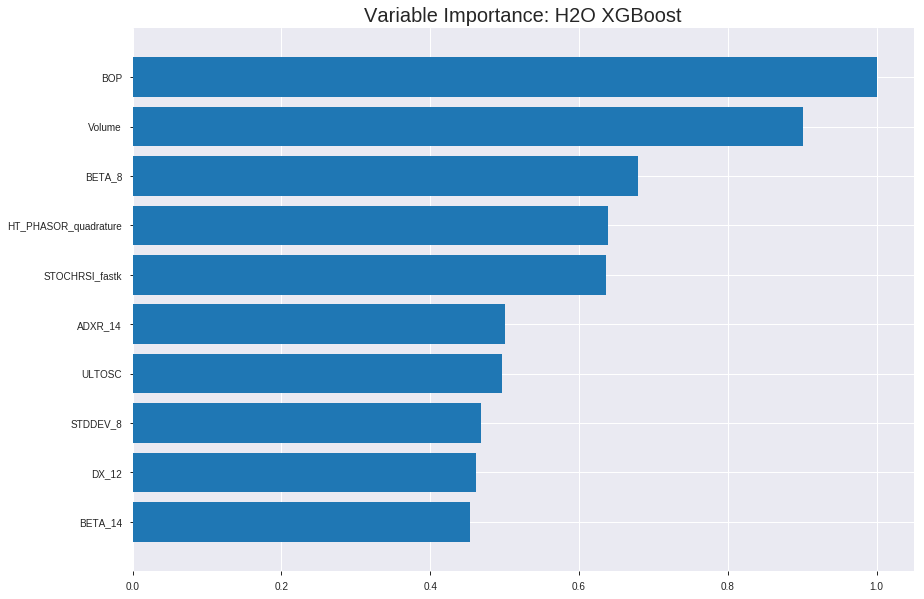

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_142244_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2079648172559258
RMSE: 0.45603159677365096
LogLoss: 0.6077254262414569
Mean Per-Class Error: 0.20073715454216523
AUC: 0.8786767916783366
pr_auc: 0.8861195332537565
Gini: 0.7573535833566731
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997195163193871: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1590  524   0.2479   (524.0/2114.0)
1      364   1835  0.1655   (364.0/2199.0)
Total  1954  2359  0.2059   (888.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49972      0.805178  214
max f2                       0.457299     0.873823  274
max f0point5                 0.524773     0.814088  180
max accuracy                 0.510278     0.79898   198
max precision                0.740259     1         0
max recall                   0.313565     1         392
max specificity              0.740259     1         0
max absolute_mcc             0.510278     0.598495  198
max min_per_class_accuracy   0.5078       0.796271  202
max mean_per_class_accuracy  0.510278     0.799263  198

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.682408           1.96135    1.96135            1                0.697407  1                           0.697407            0.0200091       0.0200091                  96.1346   96.1346
    2        0.0201716                   0.664486           1.96135    1.96135            1                0.671692  1                           0.684697            0.0195543       0.0395634                  96.1346   96.1346
    3        0.0301414                   0.65378            1.91573    1.94626            0.976744         0.658855  0.992308                    0.676149            0.0190996       0.058663                   91.5733   94.6259
    4        0.0401113                   0.64314            1.96135    1.95001            1                0.647737  0.99422                     0.669088            0.0195543       0.0782174                  96.1346   95.0009
    5        0.0500812                   0.635492           1.96135    1.95227            1                0.639173  0.99537                     0.663132            0.0195543       0.0977717                  96.1346   95.2266
    6        0.100162                    0.607385           1.90686    1.92956            0.972222         0.62022   0.983796                    0.641676            0.095498        0.19327                    90.6864   92.9565
    7        0.150012                    0.589866           1.87012    1.90981            0.953488         0.598385  0.973725                    0.62729             0.0932242       0.286494                   87.0121   90.9811
    8        0.200093                    0.574324           1.73434    1.86589            0.884259         0.581501  0.951333                    0.61583             0.0868577       0.373352                   73.4338   86.5892
    9        0.300023                    0.547626           1.6246     1.78552            0.828306         0.560041  0.910355                    0.597248            0.162347        0.535698                   62.4595   78.5522
    10       0.399954                    0.528878           1.35155    1.67709            0.689095         0.538164  0.855072                    0.582485            0.135061        0.670759                   35.1554   67.7093
    11       0.500116                    0.50818            1.2213     1.58581            0.622685         0.518555  0.80853                     0.569681            0.122328        0.793088                   22.1301   58.5808
    12       0.600046                    0.488763           0.805472   1.45585            0.410673         0.4989    0.742272                    0.557894            0.0804911       0.873579                   -19.4528  45.5852
    13       0.699977                    0.467418           0.577937   1.33052            0.294664         0.478492  0.67837                     0.546558            0.0577535       0.931332                   -42.2063  33.0519
    14       0.799907                    0.444088           0.40046    1.21433            0.204176         0.455504  0.61913                     0.535183            0.0400182       0.971351                   -59.954   21.4329
    15       0.899838                    0.412594           0.236636   1.10575            0.12065          0.430215  0.563772                    0.523526            0.0236471       0.994998                   -76.3364  10.5752
    16       1                           0.24417            0.0499417  1                  0.025463         0.381469  0.509854                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25708376404815636
RMSE: 0.5070342829120693
LogLoss: 0.7082779884169452
Mean Per-Class Error: 0.46415385062650816
AUC: 0.5339273773875629
pr_auc: 0.5504992588710247
Gini: 0.06785475477512581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22999826073646545: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    583   1        (583.0/583.0)
1      0    649   0        (0.0/649.0)
Total  0    1232  0.4732   (583.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.229998     0.690058   399
max f2                       0.229998     0.847701   399
max f0point5                 0.286043     0.58359    384
max accuracy                 0.43816      0.536526   228
max precision                0.547197     0.613333   76
max recall                   0.229998     1          399
max specificity              0.71869      0.998285   0
max absolute_mcc             0.509453     0.0809091  124
max min_per_class_accuracy   0.462476     0.523883   195
max mean_per_class_accuracy  0.475686     0.535846   174

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.638515           0.730117  0.730117           0.384615         0.663474  0.384615                    0.663474            0.00770416      0.00770416                 -26.9883  -26.9883
    2        0.0202922                   0.613405           0.949153  0.835254           0.5              0.623358  0.44                        0.644219            0.00924499      0.0169492                  -5.08475  -16.4746
    3        0.0300325                   0.603148           1.10734   0.9235             0.583333         0.607703  0.486486                    0.632376            0.0107858       0.027735                   10.7345   -7.65002
    4        0.0405844                   0.590751           1.31421   1.02508            0.692308         0.596149  0.54                        0.622957            0.0138675       0.0416025                  31.4211   2.50847
    5        0.0503247                   0.579959           0.632768  0.949153           0.333333         0.585026  0.5                         0.615615            0.00616333      0.0477658                  -36.7232  -5.08475
    6        0.100649                    0.556822           1.25533   1.10224            0.66129          0.566455  0.580645                    0.591035            0.0631741       0.11094                    25.5331   10.2242
    7        0.150162                    0.537641           1.15143   1.11846            0.606557         0.546613  0.589189                    0.576388            0.0570108       0.167951                   15.1431   11.8461
    8        0.200487                    0.521668           0.97977   1.08365            0.516129         0.529257  0.57085                     0.564557            0.0493066       0.217257                   -2.02296  8.36478
    9        0.300325                    0.497838           1.12664   1.09794            0.593496         0.510043  0.578378                    0.546435            0.112481        0.329738                   12.6636   9.79386
    10       0.400162                    0.479047           1.00317   1.07429            0.528455         0.488059  0.565923                    0.531871            0.100154        0.429892                   0.316935  7.42944
    11       0.5                         0.462322           0.941436  1.04777            0.495935         0.470232  0.551948                    0.519563            0.0939908       0.523883                   -5.85641  4.77658
    12       0.599838                    0.438644           1.03404   1.04548            0.544715         0.451341  0.550744                    0.508208            0.103236        0.627119                   3.40361   4.54806
    13       0.699675                    0.409979           0.848836  1.01742            0.447154         0.426443  0.535963                    0.496541            0.0847458       0.711864                   -15.1164  1.74211
    14       0.799513                    0.382811           0.879702  1.00022            0.463415         0.396731  0.526904                    0.484077            0.0878274       0.799692                   -12.0298  0.0223694
    15       0.899351                    0.343939           1.0186    1.00226            0.536585         0.361678  0.527978                    0.47049             0.101695        0.901387                   1.86027   0.226397
    16       1                           0.229998           0.97977   1                  0.516129         0.312506  0.526786                    0.454589  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:24:02  44.295 sec  0                  0.5              0.693147            0.5             0                  1                0.490146                         0.5                0.693147              0.5               0                    1                  0.473214
    2019-08-24 14:24:03  45.306 sec  5                  0.493851         0.680909            0.706398        0.713635           1.87219          0.400417                         0.499733           0.692614              0.520672          0.548548             0.876141           0.473214
    2019-08-24 14:24:03  45.643 sec  10                 0.488977         0.671285            0.750089        0.760576           1.96135          0.356364                         0.500498           0.694155              0.525013          0.541459             1.02216            0.472403
    2019-08-24 14:24:03  45.984 sec  15                 0.484898         0.663269            0.770085        0.783733           1.96135          0.318108                         0.50007            0.693316              0.540815          0.55121              0.876141           0.473214
    2019-08-24 14:24:04  46.314 sec  20                 0.480293         0.654281            0.794562        0.806127           1.96135          0.28843                          0.500523           0.694242              0.539651          0.554046             1.02216            0.473214
    2019-08-24 14:24:04  46.671 sec  25                 0.475469         0.644922            0.818828        0.828066           1.96135          0.283793                         0.5013             0.695874              0.537054          0.554906             0.43807            0.473214
    2019-08-24 14:24:04  47.026 sec  30                 0.471761         0.637738            0.82838         0.837998           1.96135          0.267099                         0.501093           0.695483              0.53997           0.558945             0.730117           0.473214
    2019-08-24 14:24:05  47.377 sec  35                 0.46766          0.62986             0.842179        0.851626           1.96135          0.252724                         0.502648           0.698699              0.535147          0.555597             0.876141           0.472403
    2019-08-24 14:24:05  47.747 sec  40                 0.463189         0.621327            0.858731        0.865955           1.96135          0.231162                         0.505027           0.703785              0.534123          0.55372              0.876141           0.472403
    2019-08-24 14:24:05  48.120 sec  45                 0.459279         0.613893            0.869688        0.876809           1.96135          0.210294                         0.506042           0.70605               0.535657          0.552798             0.730117           0.472403
    2019-08-24 14:24:06  48.493 sec  50                 0.456032         0.607725            0.878677        0.88612            1.96135          0.205889                         0.507034           0.708278              0.533927          0.550499             0.730117           0.473214

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      268.57275390625        1.0                   0.02795398307902953
Volume                   241.91116333007812     0.9007286100753222    0.025178952324843344
BETA_8                   182.53073120117188     0.6796323474602618    0.018998431140865274
HT_PHASOR_quadrature     171.6620635986328      0.639164103960279     0.017867182546828713
STOCHRSI_fastk           171.05467224121094     0.6369025515556226    0.017803963149176608
---                      ---                    ---                   ---
VAR_12                   4.695305347442627      0.017482433639123367  0.0004887036541283113
BBANDS_lowerband_8_0_3   4.681326389312744      0.017430384583787092  0.0004872486757161615
BBANDS_lowerband_12_7_5  4.5907673835754395     0.01709319846039903   0.00047782298052848803
SMA_8                    3.4137520790100098     0.01271071629329027   0.00035531514818498114
BBANDS_upperband_12_5_2  2.8900654315948486     0.01076082882407229   0.00030080802686445


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542949756888168)

('F1', 0.6711560044893379)

('auc', 0.5350478091835662)

('logloss', 0.6988970929886354)

('mean_per_class_error', 0.44666911841967005)

('rmse', 0.5027965266073973)

('mse', 0.2528043471684632)

xgboost prediction progress: |████████████████████████████████████████████| 100%


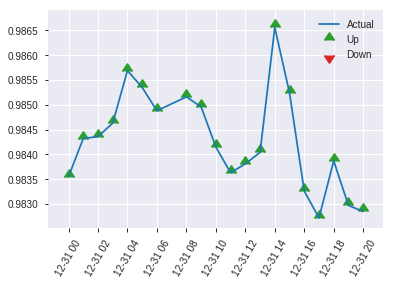


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2528043471684632
RMSE: 0.5027965266073973
LogLoss: 0.6988970929886354
Mean Per-Class Error: 0.44666911841967005
AUC: 0.5350478091835662
pr_auc: 0.5209392057706947
Gini: 0.0700956183671324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36274075508117676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   282  0.9186   (282.0/307.0)
1      11   299  0.0355   (11.0/310.0)
Total  36   581  0.4749   (293.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362741     0.671156  367
max f2                       0.298042     0.83468   399
max f0point5                 0.415766     0.572763  273
max accuracy                 0.415766     0.554295  273
max precision                0.529786     0.577465  59
max recall                   0.298042     1         399
max specificity              0.697705     0.996743  0
max absolute_mcc             0.415766     0.116215  273
max min_per_class_accuracy   0.444399     0.509677  207
max mean_per_class_accuracy  0.415766     0.553331  273

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 45.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.620736           0.852995  0.852995           0.428571         0.638712  0.428571                    0.638712            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.600948           0.995161  0.91861            0.5              0.610321  0.461538                    0.625608            0.00967742      0.0193548                  -0.483871  -8.13896
    3        0.0307942                   0.585259           0.995161  0.942784           0.5              0.591591  0.473684                    0.614866            0.00967742      0.0290323                  -0.483871  -5.72156
    4        0.0405186                   0.580265           1.6586    1.11458            0.833333         0.583058  0.56                        0.607232            0.016129        0.0451613                  65.8602    11.4581
    5        0.0502431                   0.572388           0.995161  1.09147            0.5              0.576136  0.548387                    0.601213            0.00967742      0.0548387                  -0.483871  9.14672
    6        0.100486                    0.535563           1.09147   1.09147            0.548387         0.548218  0.548387                    0.574716            0.0548387       0.109677                   9.14672    9.14672
    7        0.150729                    0.51029            1.15567   1.11287            0.580645         0.523456  0.55914                     0.557629            0.0580645       0.167742                   15.5671    11.2869
    8        0.200972                    0.493343           0.963059  1.07542            0.483871         0.502504  0.540323                    0.543848            0.0483871       0.216129                   -3.69407   7.54162
    9        0.299838                    0.474043           0.880962  1.0113             0.442623         0.483306  0.508108                    0.523885            0.0870968       0.303226                   -11.9038   1.1299
    10       0.400324                    0.456901           1.05937   1.02336            0.532258         0.466723  0.51417                     0.509537            0.106452        0.409677                   5.93652    2.33642
    11       0.50081                     0.443937           1.02726   1.02415            0.516129         0.450454  0.514563                    0.497682            0.103226        0.512903                   2.72633    2.41466
    12       0.599676                    0.43262            1.17462   1.04895            0.590164         0.43887   0.527027                    0.487986            0.116129        0.629032                   17.4617    4.89538
    13       0.700162                    0.415466           1.21988   1.07348            0.612903         0.424581  0.539352                    0.478886            0.122581        0.751613                   21.9875    7.34842
    14       0.799028                    0.398961           0.783078  1.03755            0.393443         0.407885  0.521298                    0.470101            0.0774194       0.829032                   -21.6922   3.75515
    15       0.899514                    0.379009           0.995161  1.03282            0.5              0.390379  0.518919                    0.461195            0.1             0.929032                   -0.483871  3.2816
    16       1                           0.298042           0.706243  1                  0.354839         0.352898  0.502431                   

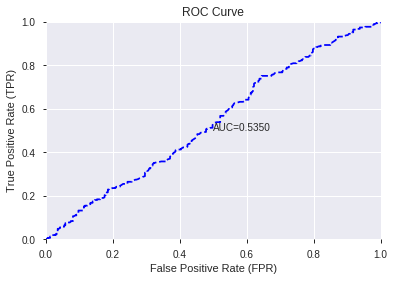

This function is available for GLM models only


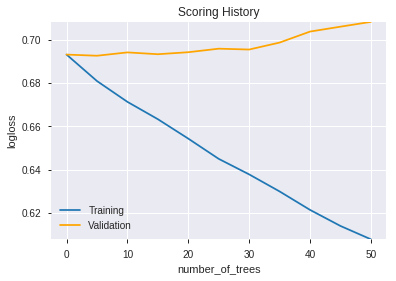

--2019-08-24 14:24:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.120
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_142244_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_142244_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [21]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_142519_model_2  0.527067  0.868471              0.498371  0.523101  0.273634
1  DeepLearning_grid_1_AutoML_20190824_142519_model_4  0.514232  0.719936              0.491794  0.510844  0.260961
2  DeepLearning_grid_1_AutoML_20190824_142519_model_8  0.509320  0.698149              0.496727  0.502092  0.252097
3  DeepLearning_grid_1_AutoML_20190824_142519_model_6  0.507166  0.697482              0.498371  0.502119  0.252123
4  DeepLearning_grid_1_AutoML_20190824_142519_model_9  0.502590  0.695537              0.490149  0.501144  0.251145
5               DeepLearning_1_AutoML_20190824_142519  0.500662  0.722674              0.496743  0.509172  0.259257
6  DeepLearning_grid_1_AutoML_20190824_142519_model_5  0.497657  0.695497              0.493470  0.501267  0.251269
7  DeepLearning_grid_1_AutoML_20190824_142519_model_1  0.495981  0.818752              0.498371  0.527249  0.277992
8  DeepLearning_grid_1_AutoML_20190824_142519_model_3  0.489172  0.783770              0.500000  0.520914  0.271352
9  DeepLearning_grid_1_AutoML_20190824_142519_model_7  0.475265  0.734435              0.495098  0.514504  0.264714

variable  relative_importance  scaled_importance  percentage
0             CORREL_12             1.000000           1.000000    0.052930
1                  DX_8             0.723397           0.723397    0.038289
2              CORREL_8             0.698691           0.698691    0.036982
3                   BOP             0.669966           0.669966    0.035461
4        STOCHRSI_fastk             0.613252           0.613252    0.032459
5       CDLHOMINGPIGEON             0.600555           0.600555    0.031787
6         days_in_month             0.595378           0.595378    0.031513
7      is_quarter_start             0.573992           0.573992    0.030381
8    CDLIDENTICAL3CROWS             0.566901           0.566901    0.030006
9           CDLPIERCING             0.543694           0.543694    0.028778
10    CDL3WHITESOLDIERS             0.517318           0.517318    0.027382
11    CDLDARKCLOUDCOVER             0.512210           0.512210    0.027111
12       CDLMORNINGSTAR             0.498489           0.498489    0.026385
13            CDLONNECK             0.493319           0.493319    0.026111
14     CDLSTICKSANDWICH             0.489056           0.489056    0.025886
15   CDLMORNINGDOJISTAR             0.469271           0.469271    0.024839
16         CDLTHRUSTING             0.456062           0.456062    0.024139
17                  SUB             0.449721           0.449721    0.023804
18   CDLEVENINGDOJISTAR             0.443220           0.443220    0.023460
19            CORREL_24             0.442283           0.442283    0.023410
20      CDLLADDERBOTTOM             0.435783           0.435783    0.023066
21            CDL2CROWS             0.412286           0.412286    0.021822
22                VAR_8             0.405918           0.405918    0.021485
23  CDLGAPSIDESIDEWHITE             0.382381           0.382381    0.020239
24            CORREL_14             0.330180           0.330180    0.017476
25       CDLEVENINGSTAR             0.329097           0.329097    0.017419
26              CDLDOJI             0.315716           0.315716    0.016711
27    CDLLONGLEGGEDDOJI             0.299420           0.299420    0.015848
28         is_month_end             0.279072           0.279072    0.014771
29       CDL3LINESTRIKE             0.269710           0.269710    0.014276
30                 CEIL             0.265715           0.265715    0.014064
31       is_month_start             0.258006           0.258006    0.013656
32    CDLSTALLEDPATTERN             0.251538           0.251538    0.013314
33                FLOOR             0.247741           0.247741    0.013113
34            CORREL_20             0.244492           0.244492    0.012941
35        CDLHIKKAKEMOD             0.240862           0.240862    0.012749
36       CDLRICKSHAWMAN             0.240662           0.240662    0.012738
37        CDLHANGINGMAN             0.225095           0.225095    0.011914
38      CDLADVANCEBLOCK             0.208930           0.208930    0.011059
39            CDLHAMMER             0.203819           0.203819    0.010788
40    CDLGRAVESTONEDOJI             0.203763           0.203763    0.010785
41      CDLSHOOTINGSTAR             0.200919           0.200919    0.010635
42  CDLXSIDEGAP3METHODS             0.183514           0.183514    0.009713
43    CDLINVERTEDHAMMER             0.170193           0.170193    0.009008
44       CDLMATCHINGLOW             0.165790           0.165790    0.008775
45   CDLSEPARATINGLINES             0.162798           0.162798    0.008617
46       CDLHARAMICROSS             0.158787           0.158787    0.008405
47     CDLDRAGONFLYDOJI             0.155080           0.155080    0.008208
48          CDLDOJISTAR             0.151096           0.151096    0.007998
49            CDLTAKURI             0.137693           0.137693    0.007288

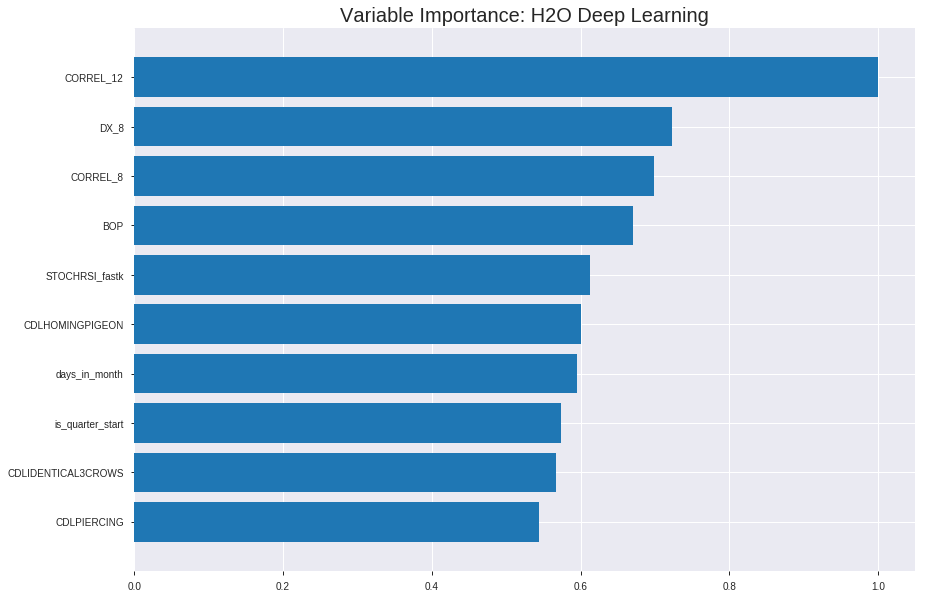

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_142519_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2662412596268975
RMSE: 0.5159857164950378
LogLoss: 0.8131198368074478
Mean Per-Class Error: 0.46862167072587824
AUC: 0.5418725850702758
pr_auc: 0.5317788297985834
Gini: 0.0837451701405516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09704142014098516: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      56   2058  0.9735   (2058.0/2114.0)
1      22   2177  0.01     (22.0/2199.0)
Total  78   4235  0.4823   (2080.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0970414    0.676717   378
max f2                       0.0108959    0.838801   398
max f0point5                 0.370423     0.57097    294
max accuracy                 0.370423     0.533272   294
max precision                0.711706     0.585683   83
max recall                   0.0108959    1          398
max specificity              0.999868     0.983917   0
max absolute_mcc             0.370423     0.0736035  294
max min_per_class_accuracy   0.49873      0.526017   206
max mean_per_class_accuracy  0.47379      0.531378   223

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 51.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.999917           1.1144    1.1144             0.568182         0.999981  0.568182                    0.999981            0.0113688       0.0113688                  11.4401    11.4401
    2        0.0201716                   0.990227           0.729803  0.924313           0.372093         0.998277  0.471264                    0.999139            0.00727603      0.0186448                  -27.0197   -7.56875
    3        0.0301414                   0.947577           1.36838   1.0712             0.697674         0.967212  0.546154                    0.988578            0.0136426       0.0322874                  36.8381    7.11967
    4        0.0401113                   0.905962           1.14032   1.08838            0.581395         0.929505  0.554913                    0.973895            0.0113688       0.0436562                  14.0317    8.8377
    5        0.0500812                   0.854806           1.14032   1.09872            0.581395         0.882296  0.560185                    0.95566             0.0113688       0.055025                   14.0317    9.8717
    6        0.100162                    0.722252           1.1532    1.12596            0.587963         0.775954  0.574074                    0.865807            0.0577535       0.112779                   15.3199    12.5958
    7        0.150012                    0.662186           1.13119   1.1277             0.576744         0.688758  0.574961                    0.806973            0.0563893       0.169168                   13.1195    12.7698
    8        0.200093                    0.627274           0.989753  1.09317            0.50463          0.642543  0.557358                    0.765818            0.049568        0.218736                   -1.02467   9.3172
    9        0.300023                    0.575865           1.01935   1.06858            0.519722         0.600949  0.544822                    0.710904            0.101864        0.3206                     1.93539    6.8585
    10       0.399954                    0.534795           1.05576   1.06538            0.538283         0.554536  0.543188                    0.671835            0.105503        0.426103                   5.57594    6.53804
    11       0.500116                    0.498246           0.998834  1.05205            0.509259         0.51646   0.536393                    0.640717            0.100045        0.526148                   -0.116636  5.20526
    12       0.600046                    0.46289            1.0148    1.04585            0.517401         0.480729  0.53323                     0.614073            0.10141         0.627558                   1.48032    4.58491
    13       0.699977                    0.429372           0.951094  1.03232            0.484919         0.446516  0.526333                    0.590152            0.0950432       0.722601                   -4.89064   3.23216
    14       0.799907                    0.392194           1.0239    1.03127            0.522042         0.411485  0.525797                    0.567831            0.102319        0.82492                    2.39046    3.12701
    15       0.899838                    0.336936           0.932891  1.02034            0.475638         0.367508  0.520227                    0.545585            0.0932242       0.918145                   -6.71092   2.03447
    16       1                           0.00409823         0.817228  1                  0.416667         0.229064  0.509854                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2818143958367746
RMSE: 0.5308619366999056
LogLoss: 0.9546227582374031
Mean Per-Class Error: 0.47921330348576907
AUC: 0.5054603070563766
pr_auc: 0.5054114236881272
Gini: 0.010920614112753135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07971283746612084: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   567   0.9726   (567.0/583.0)
1      5    644   0.0077   (5.0/649.0)
Total  21   1211  0.4643   (572.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0797128    0.692473  384
max f2                       0.0112838    0.847923  398
max f0point5                 0.0797128    0.586201  384
max accuracy                 0.300574     0.538149  338
max precision                0.691989     0.566038  75
max recall                   0.0112838    1         398
max specificity              0.99996      0.958834  0
max absolute_mcc             0.0797128    0.076142  384
max min_per_class_accuracy   0.480819     0.499142  210
max mean_per_class_accuracy  0.395481     0.520787  281

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.999998           1.31421   1.31421            0.692308         0.999999  0.692308                    0.999999            0.0138675       0.0138675                  31.4211   31.4211
    2        0.0202922                   0.999991           1.26554   1.29085            0.666667         0.999995  0.68                        0.999997            0.0123267       0.0261941                  26.5537   29.0847
    3        0.0300325                   0.999968           0.79096   1.12872            0.416667         0.999983  0.594595                    0.999993            0.00770416      0.0338983                  -20.904   12.8722
    4        0.0405844                   0.999754           0.584094  0.987119           0.307692         0.999888  0.52                        0.999965            0.00616333      0.0400616                  -41.5906  -1.28814
    5        0.0503247                   0.970845           1.10734   1.01039            0.583333         0.98779   0.532258                    0.997609            0.0107858       0.0508475                  10.7345   1.03882
    6        0.100649                    0.740115           0.887917  0.949153           0.467742         0.847762  0.5                         0.922686            0.0446841       0.0955316                  -11.2083  -5.08475
    7        0.150162                    0.663436           1.15143   1.01585            0.606557         0.698061  0.535135                    0.84862             0.0570108       0.152542                   15.1431   1.58497
    8        0.200487                    0.623084           0.826681  0.968366           0.435484         0.644216  0.510121                    0.797312            0.0416025       0.194145                   -17.3319  -3.16338
    9        0.300325                    0.563405           1.00317   0.979936           0.528455         0.59144   0.516216                    0.728874            0.100154        0.294299                   0.316935  -2.00641
    10       0.400162                    0.520338           0.972303  0.978031           0.512195         0.539978  0.515213                    0.681746            0.0970724       0.391371                   -2.76974  -2.19686
    11       0.5                         0.481062           1.08034   0.998459           0.569106         0.499941  0.525974                    0.645444            0.107858        0.49923                    8.03362   -0.154083
    12       0.599838                    0.444898           1.08034   1.01209            0.569106         0.463656  0.533153                    0.615187            0.107858        0.607088                   8.03362   1.20869
    13       0.699675                    0.413376           0.956869  1.00421            0.504065         0.429139  0.529002                    0.588639            0.0955316       0.702619                   -4.31308  0.420779
    14       0.799513                    0.381154           1.08034   1.01371            0.569106         0.399189  0.53401                     0.564982            0.107858        0.810478                   8.03362   1.37142
    15       0.899351                    0.326036           0.987736  1.01083            0.520325         0.356248  0.532491                    0.54181             0.0986133       0.909091                   -1.2264   1.08303
    16       1                           0.0096897          0.903226  1                  0.475806         0.213031  0.526786                    0.508719 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:27:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:27:10  1 min 48.802 sec  7063 obs/sec      10        1             43130      0.53091          0.934009            -0.127902      0.513695        0.505398           1.02525          0.48945                          0.545168           1.15426               -0.192254        0.50479           0.503078             1.02216            0.470779
    2019-08-24 14:27:18  1 min 57.169 sec  9057 obs/sec      30        3             129390     0.515986         0.81312             -0.0653788     0.541873        0.531779           1.1144           0.482263                         0.530862           0.954623              -0.130502        0.50546           0.505411             1.31421            0.464286
    2019-08-24 14:27:25  2 min  4.242 sec  10188 obs/sec     50        5             215650     0.516073         0.850505            -0.0657393     0.553491        0.539537           1.06983          0.484118                         0.529694           1.07749               -0.125533        0.513594          0.507177             1.16819            0.466721
    2019-08-24 14:27:31  2 min 10.711 sec  11002 obs/sec     70        7             301910     0.51434          0.821042            -0.0585922     0.546864        0.53934            1.15898          0.481799                         0.530776           1.07533               -0.130136        0.506508          0.503525             1.31421            0.462662
    2019-08-24 14:27:37  2 min 16.751 sec  11660 obs/sec     90        9             388170     0.508808         0.798349            -0.0359461     0.561137        0.549898           1.15898          0.479944                         0.529464           1.03501               -0.124555        0.500468          0.504268             1.31421            0.461851
    2019-08-24 14:27:43  2 min 22.650 sec  12203 obs/sec     110       11            474430     0.505875         0.82827             -0.0240342     0.57395         0.55518            1.15898          0.473452                         0.528416           1.19677               -0.120109        0.508535          0.501466             0.876141           0.463474
    2019-08-24 14:27:49  2 min 28.250 sec  12660 obs/sec     130       13            560690     0.506522         0.818117            -0.0266587     0.572449        0.558447           1.20355          0.472989                         0.531472           1.25144               -0.133104        0.51281           0.506379             1.31421            0.467532
    2019-08-24 14:27:49  2 min 28.452 sec  12659 obs/sec     130       13            560690     0.515986         0.81312             -0.0653788     0.541873        0.531779           1.1144           0.482263                         0.530862           0.954623              -0.130502        0.50546           0.505411             1.31421            0.464286

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CORREL_12           1.0                    1.0                  0.05293012615991215
DX_8                0.7233970761299133     0.7233970761299133   0.038289498503267884
CORREL_8            0.6986908316612244     0.6986908316612244   0.036981793866602546
BOP                 0.6699658036231995     0.6699658036231995   0.03546137450860287
STOCHRSI_fastk      0.613251805305481      0.613251805305481    0.03245949542261299
---                 ---                    ---                  ---
CDLSEPARATINGLINES  0.16279782354831696    0.16279782354831696  0.008616909338971534
CDLHARAMICROSS      0.1587868183851242     0.1587868183851242   0.008404606329655681
CDLDRAGONFLYDOJI    0.15508008003234863    0.15508008003234863  0.008208408201001487
CDLDOJISTAR         0.15109626948833466    0.15109626948833466  0.007997544606309638
CDLTAKURI           0.1376928836107254     0.1376928836107254   0.007288101700837796


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5380875202593193)

('F1', 0.6695464362850972)

('auc', 0.5270673531575076)

('logloss', 0.8684712679460116)

('mean_per_class_error', 0.4632394662183461)

('rmse', 0.5231007894789522)

('mse', 0.27363443595350306)

deeplearning prediction progress: |███████████████████████████████████████| 100%


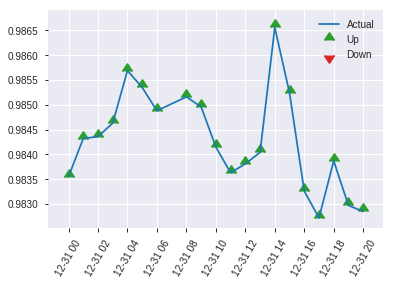


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27363443595350306
RMSE: 0.5231007894789522
LogLoss: 0.8684712679460116
Mean Per-Class Error: 0.4632394662183461
AUC: 0.5270673531575076
pr_auc: 0.5161419824719305
Gini: 0.05413470631501527
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008464628681885614: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    306  0.9967   (306.0/307.0)
1      0    310  0        (0.0/310.0)
Total  1    616  0.4959   (306.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00846463   0.669546   398
max f2                       0.00846463   0.835129   398
max f0point5                 0.399138     0.565825   295
max accuracy                 0.399138     0.538088   295
max precision                0.736032     0.587302   52
max recall                   0.00846463   1          398
max specificity              0.99988      0.986971   0
max absolute_mcc             0.399138     0.0877685  295
max min_per_class_accuracy   0.495569     0.511401   208
max mean_per_class_accuracy  0.399138     0.536761   295

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 51.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.999626           0.852995  0.852995           0.428571         0.99988   0.428571                    0.99988             0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.97616            0.995161  0.91861            0.5              0.988922  0.461538                    0.994822            0.00967742      0.0193548                  -0.483871  -8.13896
    3        0.0307942                   0.941099           1.32688   1.04754            0.666667         0.956056  0.526316                    0.98258             0.0129032       0.0322581                  32.6882    4.75382
    4        0.0405186                   0.90191            0.663441  0.955355           0.333333         0.9196    0.48                        0.967465            0.00645161      0.0387097                  -33.6559   -4.46452
    5        0.0502431                   0.872185           0.995161  0.963059           0.5              0.891594  0.483871                    0.95278             0.00967742      0.0483871                  -0.483871  -3.69407
    6        0.100486                    0.735995           1.34828   1.15567            0.677419         0.796328  0.580645                    0.874554            0.0677419       0.116129                   34.8283    15.5671
    7        0.150729                    0.665621           0.963059  1.09147            0.483871         0.691231  0.548387                    0.813447            0.0483871       0.164516                   -3.69407   9.14672
    8        0.200972                    0.635239           0.963059  1.05937            0.483871         0.649533  0.532258                    0.772468            0.0483871       0.212903                   -3.69407   5.93652
    9        0.299838                    0.579326           1.0441    1.05433            0.52459          0.603941  0.52973                     0.7169              0.103226        0.316129                   4.41036    5.4333
    10       0.400324                    0.533526           0.963059  1.03142            0.483871         0.556945  0.518219                    0.676749            0.0967742       0.412903                   -3.69407   3.14222
    11       0.50081                     0.49538            0.995161  1.02415            0.5              0.512993  0.514563                    0.643892            0.1             0.512903                   -0.483871  2.41466
    12       0.599676                    0.463391           0.978847  1.01668            0.491803         0.479868  0.510811                    0.61685             0.0967742       0.609677                   -2.11528   1.66783
    13       0.700162                    0.431117           1.12357   1.03202            0.564516         0.446534  0.518519                    0.592407            0.112903        0.722581                   12.3569    3.20191
    14       0.799028                    0.387964           0.946219  1.0214             0.47541          0.409851  0.513185                    0.569819            0.0935484       0.816129                   -5.37811   2.14029
    15       0.899514                    0.336552           0.963059  1.01489            0.483871         0.366893  0.50991                     0.547149            0.0967742       0.912903                   -3.69407   1.48852
    16       1                           0.00762914         0.866753  1                  0.435484         0.224029  0.502431                 

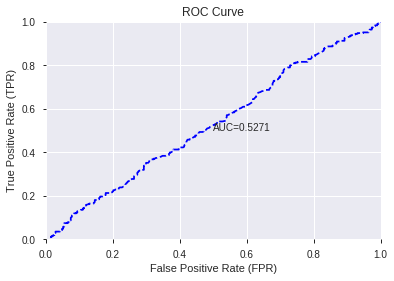

This function is available for GLM models only


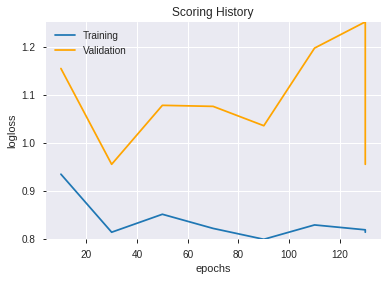

--2019-08-24 14:46:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_142519_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_142519_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_12',
 'DX_8',
 'CORREL_8',
 'BOP',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'days_in_month',
 'is_quarter_start',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDL3WHITESOLDIERS',
 'CDLDARKCLOUDCOVER',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'CDLTHRUSTING',
 'SUB',
 'CDLEVENINGDOJISTAR',
 'CORREL_24',
 'CDLLADDERBOTTOM',
 'CDL2CROWS',
 'VAR_8',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_14',
 'CDLEVENINGSTAR',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'is_month_end',
 'CDL3LINESTRIKE',
 'CEIL',
 'is_month_start',
 'CDLSTALLEDPATTERN',
 'FLOOR',
 'CORREL_20',
 'CDLHIKKAKEMOD',
 'CDLRICKSHAWMAN',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'CDLSEPARATINGLINES',
 'CDLHARAMICROSS',
 'CDLDRAGONFLYDOJI',
 'CDLDOJISTAR',
 'CDLTAKURI']

In [22]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_144719_model_1  0.508028  0.69496              0.495098  0.500836  0.250837

variable  relative_importance  scaled_importance  percentage
0        STOCHRSI_fastk             0.044142           1.000000    0.068195
1                   BOP             0.039460           0.893930    0.060962
2     CDLDARKCLOUDCOVER             0.033135           0.750651    0.051191
3             CDLHAMMER             0.027492           0.622815    0.042473
4           CDLPIERCING             0.026995           0.611548    0.041705
5          is_month_end             0.024216           0.548602    0.037412
6        is_month_start             0.023833           0.539931    0.036821
7          CDLTHRUSTING             0.022989           0.520794    0.035516
8        CDLEVENINGSTAR             0.021896           0.496050    0.033828
9      CDLSTICKSANDWICH             0.021262           0.481680    0.032848
10       CDLRICKSHAWMAN             0.021027           0.476344    0.032484
11                VAR_8             0.019561           0.443152    0.030221
12            CDL2CROWS             0.016907           0.383006    0.026119
13  CDLGAPSIDESIDEWHITE             0.016766           0.379822    0.025902
14      CDLADVANCEBLOCK             0.016222           0.367495    0.025061
15      CDLLADDERBOTTOM             0.015566           0.352638    0.024048
16    CDLSTALLEDPATTERN             0.015344           0.347598    0.023705
17  CDLXSIDEGAP3METHODS             0.015222           0.344838    0.023516
18        days_in_month             0.015182           0.343945    0.023455
19        CDLHANGINGMAN             0.013636           0.308906    0.021066
20            CDLTAKURI             0.013476           0.305288    0.020819
21       CDL3LINESTRIKE             0.013382           0.303165    0.020674
22   CDLMORNINGDOJISTAR             0.012986           0.294183    0.020062
23    CDLGRAVESTONEDOJI             0.012182           0.275986    0.018821
24    CDLINVERTEDHAMMER             0.012069           0.273407    0.018645
25            CORREL_12             0.010718           0.242814    0.016559
26     is_quarter_start             0.009890           0.224041    0.015278
27            CORREL_24             0.009779           0.221535    0.015108
28                 DX_8             0.009747           0.220807    0.015058
29                 CEIL             0.009559           0.216562    0.014768
30      CDLHOMINGPIGEON             0.009064           0.205334    0.014003
31    CDL3WHITESOLDIERS             0.008835           0.200141    0.013649
32   CDLIDENTICAL3CROWS             0.008784           0.199005    0.013571
33   CDLSEPARATINGLINES             0.007583           0.171795    0.011716
34                FLOOR             0.007509           0.170117    0.011601
35     CDLDRAGONFLYDOJI             0.006494           0.147114    0.010032
36        CDLHIKKAKEMOD             0.005013           0.113575    0.007745
37                  SUB             0.004693           0.106311    0.007250
38       CDLMATCHINGLOW             0.004291           0.097200    0.006629
39       CDLMORNINGSTAR             0.004227           0.095751    0.006530
40          CDLDOJISTAR             0.003690           0.083592    0.005701
41      CDLSHOOTINGSTAR             0.003556           0.080550    0.005493
42   CDLEVENINGDOJISTAR             0.002955           0.066937    0.004565
43       CDLHARAMICROSS             0.002100           0.047580    0.003245
44            CDLONNECK             0.001728           0.039155    0.002670
45              CDLDOJI             0.000804           0.018214    0.001242
46             CORREL_8             0.000630           0.014282    0.000974
47            CORREL_20             0.000254           0.005749    0.000392
48    CDLLONGLEGGEDDOJI             0.000249           0.005633    0.000384
49            CORREL_14             0.000188           0.004251    0.000290

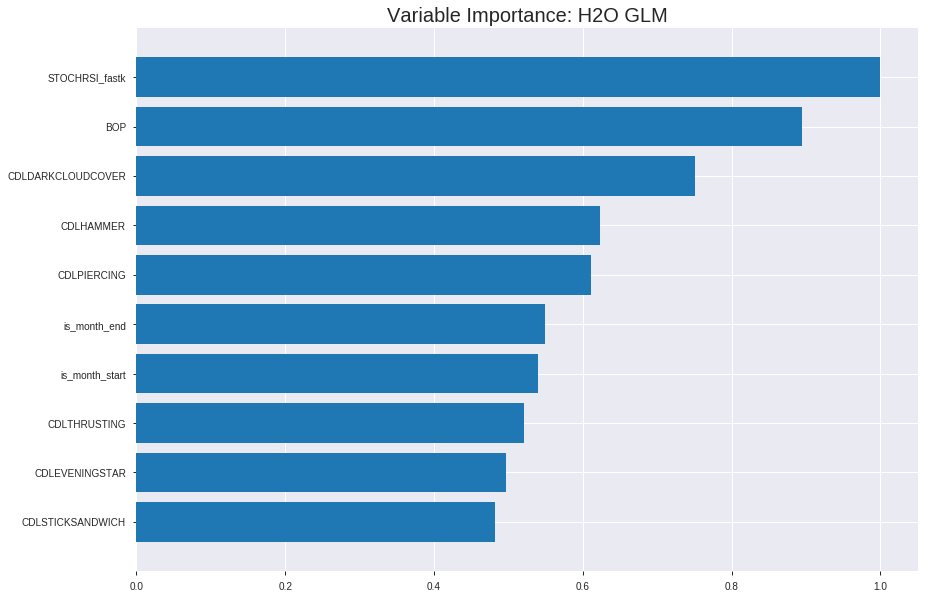

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_144719_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247289876077791
RMSE: 0.4972824912238425
LogLoss: 0.6876365313306579
Null degrees of freedom: 4312
Residual degrees of freedom: 4262
Null deviance: 5977.4123029576585
Residual deviance: 5931.552719258255
AIC: 6033.552719258255
AUC: 0.5603996484167785
pr_auc: 0.563025039633479
Gini: 0.12079929683355695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4141273683144649: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      28   2086  0.9868   (2086.0/2114.0)
1      7    2192  0.0032   (7.0/2199.0)
Total  35   4278  0.4853   (2093.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.414127     0.676857   372
max f2                       0.384511     0.839316   386
max f0point5                 0.483211     0.572563   282
max accuracy                 0.507188     0.543937   200
max precision                0.756906     1          0
max recall                   0.366243     1          390
max specificity              0.756906     1          0
max absolute_mcc             0.531616     0.0962358  122
max min_per_class_accuracy   0.509583     0.541627   193
max mean_per_class_accuracy  0.507188     0.543426   200

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.578467           1.20355   1.20355            0.613636         0.605237  0.613636                    0.605237            0.0122783       0.0122783                  20.3553    20.3553
    2        0.0201716                   0.568862           1.32277   1.26248            0.674419         0.573239  0.643678                    0.589422            0.0131878       0.0254661                  32.2768    26.2476
    3        0.0301414                   0.555886           1.27716   1.26733            0.651163         0.561626  0.646154                    0.580228            0.0127331       0.0381992                  27.7156    26.7331
    4        0.0401113                   0.551754           1.32277   1.28111            0.674419         0.553506  0.653179                    0.573586            0.0131878       0.051387                   32.2768    28.111
    5        0.0500812                   0.549702           0.912254  1.20768            0.465116         0.550488  0.615741                    0.568988            0.00909504      0.060482                   -8.7746    20.7681
    6        0.100162                    0.543212           1.18044   1.19406            0.601852         0.545923  0.608796                    0.557455            0.0591178       0.1196                     18.044     19.406
    7        0.150012                    0.53901            1.12207   1.17014            0.572093         0.541     0.5966                      0.551987            0.0559345       0.175534                   12.2072    17.0138
    8        0.200093                    0.535549           1.1078    1.15454            0.564815         0.537212  0.588644                    0.548289            0.0554798       0.231014                   10.7797    15.4535
    9        0.300023                    0.526604           1.07851   1.12921            0.549884         0.531301  0.575734                    0.542631            0.107776        0.33879                    7.85128    12.9214
    10       0.399954                    0.517844           0.99205   1.09494            0.5058           0.522366  0.558261                    0.537568            0.099136        0.437926                   -0.795025  9.49428
    11       0.500116                    0.509494           1.03061   1.08206            0.525463         0.51379   0.551692                    0.532806            0.103229        0.541155                   3.06147    8.20593
    12       0.600046                    0.501168           0.973847  1.06404            0.49652          0.505259  0.542504                    0.528218            0.097317        0.638472                   -2.6153    6.40378
    13       0.699977                    0.494795           0.960195  1.04921            0.489559         0.497843  0.534945                    0.523882            0.0959527       0.734425                   -3.98051   4.9213
    14       0.799907                    0.488556           0.937442  1.03525            0.477958         0.491671  0.527826                    0.519858            0.0936789       0.828104                   -6.25585   3.52496
    15       0.899838                    0.479572           0.923789  1.02287            0.470998         0.484746  0.521515                    0.515958            0.0923147       0.920418                   -7.62106   2.28715
    16       1                           0.254286           0.794527  1                  0.405093         0.455012  0.509854                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24840574842546398
RMSE: 0.49840319865091554
LogLoss: 0.6898551326273112
Null degrees of freedom: 1231
Residual degrees of freedom: 1181
Null deviance: 1705.7914799426171
Residual deviance: 1699.8030467936949
AIC: 1801.8030467936949
AUC: 0.5322200403312128
pr_auc: 0.55718953708063
Gini: 0.06444008066242568
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4121931074765939: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    576   0.988    (576.0/583.0)
1      0    649   0        (0.0/649.0)
Total  7    1225  0.4675   (576.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412193     0.692636  392
max f2                       0.412193     0.849254  392
max f0point5                 0.412193     0.58479   392
max accuracy                 0.500981     0.535714  225
max precision                0.753077     1         0
max recall                   0.412193     1         392
max specificity              0.753077     1         0
max absolute_mcc             0.412193     0.079757  392
max min_per_class_accuracy   0.505978     0.525424  206
max mean_per_class_accuracy  0.515125     0.534073  169

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.615622           1.46023   1.46023            0.769231         0.653685  0.769231                    0.653685            0.0154083       0.0154083                  46.0235   46.0235
    2        0.0202922                   0.585574           0.949153  1.21492            0.5              0.599192  0.64                        0.627528            0.00924499      0.0246533                  -5.08475  21.4915
    3        0.0300325                   0.5682             0.79096   1.07742            0.416667         0.574501  0.567568                    0.61033             0.00770416      0.0323575                  -20.904   7.74164
    4        0.0405844                   0.559389           1.16819   1.10102            0.615385         0.562827  0.58                        0.597979            0.0123267       0.0446841                  16.8188   10.1017
    5        0.0503247                   0.549145           0.79096   1.04101            0.416667         0.553183  0.548387                    0.589309            0.00770416      0.0523883                  -20.904   4.1006
    6        0.100649                    0.541698           1.13286   1.08693            0.596774         0.544122  0.572581                    0.566716            0.0570108       0.109399                   13.2859   8.69328
    7        0.150162                    0.537565           1.15143   1.1082             0.606557         0.539732  0.583784                    0.557818            0.0570108       0.16641                    15.1431   10.82
    8        0.200487                    0.533622           0.887917  1.05291            0.467742         0.535618  0.554656                    0.552246            0.0446841       0.211094                   -11.2083  5.29061
    9        0.300325                    0.524076           1.09577   1.06716            0.577236         0.528759  0.562162                    0.544438            0.109399        0.320493                   9.57696   6.71553
    10       0.400162                    0.514493           1.09577   1.07429            0.577236         0.519202  0.565923                    0.538142            0.109399        0.429892                   9.57696   7.42944
    11       0.5                         0.505948           0.941436  1.04777            0.495935         0.510379  0.551948                    0.532598            0.0939908       0.523883                   -5.85641  4.77658
    12       0.599838                    0.49785            0.956869  1.03264            0.504065         0.501947  0.543978                    0.527497            0.0955316       0.619414                   -4.31308  3.26369
    13       0.699675                    0.491114           0.895136  1.01302            0.471545         0.494407  0.533643                    0.522775            0.0893683       0.708783                   -10.4864  1.30166
    14       0.799513                    0.485375           1.0186    1.01371            0.536585         0.488247  0.53401                     0.518464            0.101695        0.810478                   1.86027   1.37142
    15       0.899351                    0.473859           0.941436  1.00569            0.495935         0.480137  0.529783                    0.514209            0.0939908       0.904468                   -5.85641  0.569051
    16       1                           0.240805           0.949153  1                  0.5              0.455594  0.526786                    0.508309           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:47:20  0.000 sec   2            2.7       51            1.38327           1.38281
    2019-08-24 14:47:20  0.022 sec   4            1.7       51            1.38208           1.3821
    2019-08-24 14:47:20  0.041 sec   6            1         51            1.38057           1.38128
    2019-08-24 14:47:20  0.060 sec   8            0.65      51            1.37882           1.3805
    2019-08-24 14:47:20  0.078 sec   10           0.4       51            1.37699           1.37993
    2019-08-24 14:47:20  0.098 sec   12           0.25      51            1.37527           1.37971
    2019-08-24 14:47:20  0.118 sec   14           0.16      51            1.37382           1.37991
    2019-08-24 14:47:20  0.136 sec   16           0.097     51            1.37269           1.38046
    2019-08-24 14:47:20  0.159 sec   18           0.06      51            1.37187           1.38125
    2019-08-24 14:47:20  0.171 sec   19           0.037     51            1.37132           1.38216
    2019-08-24 14:47:20  0.183 sec   20           0.023     51            1.37094           1.38304

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6702819956616052)

('auc', 0.5080277398339813)

('logloss', 0.6949600854373283)

('mean_per_class_error', 0.48151728485867396)

('rmse', 0.5008364761630884)

('mse', 0.2508371758554598)

glm prediction progress: |████████████████████████████████████████████████| 100%


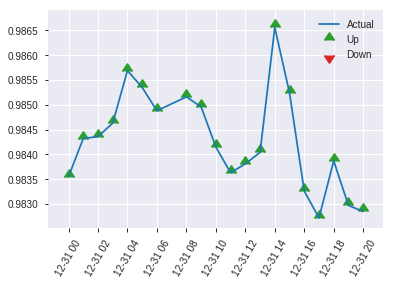


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2508371758554598
RMSE: 0.5008364761630884
LogLoss: 0.6949600854373283
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.4650475313558
Residual deviance: 857.580745429663
AIC: 959.580745429663
AUC: 0.5080277398339813
pr_auc: 0.505748949807053
Gini: 0.016055479667962613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4204468251392232: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    303  0.987    (303.0/307.0)
1      1    309  0.0032   (1.0/310.0)
Total  5    612  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.420447     0.670282   394
max f2                       0.379389     0.83558    397
max f0point5                 0.47955      0.56031    328
max accuracy                 0.480049     0.520259   326
max precision                0.545606     0.6        31
max recall                   0.379389     1          397
max specificity              0.741155     0.996743   0
max absolute_mcc             0.732357     0.0573045  1
max min_per_class_accuracy   0.508156     0.512903   196
max mean_per_class_accuracy  0.480049     0.518483   326

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.57657            0.852995  0.852995           0.428571         0.623855  0.428571                    0.623855            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.565925           1.32688   1.07171            0.666667         0.570389  0.538462                    0.599178            0.0129032       0.0225806                  32.6882    7.17122
    3        0.0307942                   0.55186            0.663441  0.942784           0.333333         0.557562  0.473684                    0.586036            0.00645161      0.0290323                  -33.6559   -5.72156
    4        0.0405186                   0.549307           0.995161  0.955355           0.5              0.550357  0.48                        0.577473            0.00967742      0.0387097                  -0.483871  -4.46452
    5        0.0502431                   0.546616           1.6586    1.09147            0.833333         0.548043  0.548387                    0.571777            0.016129        0.0548387                  65.8602    9.14672
    6        0.100486                    0.540757           0.898855  0.995161           0.451613         0.543677  0.5                         0.557727            0.0451613       0.1                        -10.1145   -0.483871
    7        0.150729                    0.538038           1.21988   1.07007            0.612903         0.539378  0.537634                    0.551611            0.0612903       0.16129                    21.9875    7.00659
    8        0.200972                    0.535031           0.64204   0.963059           0.322581         0.536331  0.483871                    0.547791            0.0322581       0.193548                   -35.796    -3.69407
    9        0.299838                    0.52812            1.17462   1.03282            0.590164         0.531813  0.518919                    0.542522            0.116129        0.309677                   17.4617    3.2816
    10       0.400324                    0.51778            0.995161  1.02336            0.5              0.522526  0.51417                     0.537503            0.1             0.409677                   -0.483871  2.33642
    11       0.50081                     0.507685           1.02726   1.02415            0.516129         0.512587  0.514563                    0.532504            0.103226        0.512903                   2.72633    2.41466
    12       0.599676                    0.499243           0.783078  0.984403           0.393443         0.503796  0.494595                    0.527771            0.0774194       0.590323                   -21.6922   -1.55972
    13       0.700162                    0.492556           1.21988   1.0182             0.612903         0.495733  0.511574                    0.523173            0.122581        0.712903                   21.9875    1.81974
    14       0.799028                    0.486085           0.880962  1.00122            0.442623         0.489235  0.503043                    0.518974            0.0870968       0.8                        -11.9038   0.121704
    15       0.899514                    0.475608           1.09147   1.0113             0.548387         0.481341  0.508108                    0.514769            0.109677        0.909677                   9.14672    1.1299
    16       1                           0.263385           0.898855  1                  0.451613         0.451476  0.502431              

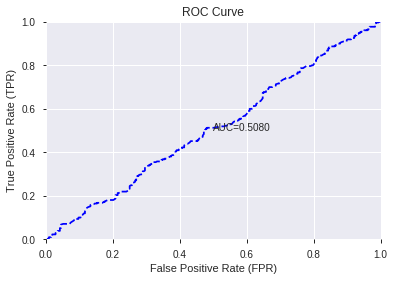

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


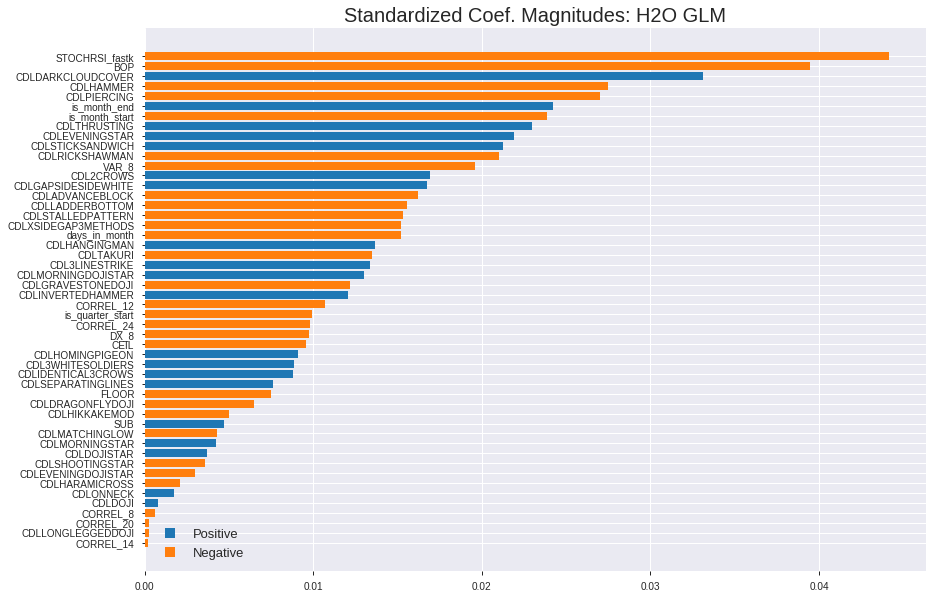

'log_likelihood'
--2019-08-24 14:47:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_144719_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_144719_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['STOCHRSI_fastk',
 'BOP',
 'CDLDARKCLOUDCOVER',
 'CDLHAMMER',
 'CDLPIERCING',
 'is_month_end',
 'is_month_start',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'VAR_8',
 'CDL2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLADVANCEBLOCK',
 'CDLLADDERBOTTOM',
 'CDLSTALLEDPATTERN',
 'CDLXSIDEGAP3METHODS',
 'days_in_month',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CORREL_12',
 'is_quarter_start',
 'CORREL_24',
 'DX_8',
 'CEIL',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLSEPARATINGLINES',
 'FLOOR',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKEMOD',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLMORNINGSTAR',
 'CDLDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLHARAMICROSS',
 'CDLONNECK',
 'CDLDOJI',
 'CORREL_8',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'CORREL_14']

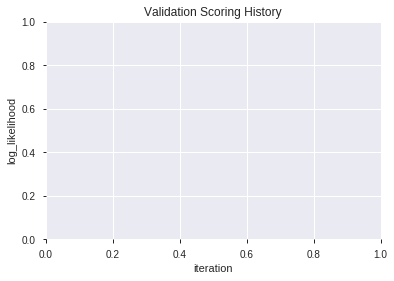

In [23]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_144827_model_4  0.496422  0.701540              0.498371  0.504104  0.254120
1  XGBoost_grid_1_AutoML_20190824_144827_model_3  0.492335  0.702665              0.500000  0.504625  0.254647
2  XGBoost_grid_1_AutoML_20190824_144827_model_7  0.490328  0.711821              0.498371  0.508886  0.258965
3               XGBoost_2_AutoML_20190824_144827  0.489908  0.710462              0.500000  0.508334  0.258403
4  XGBoost_grid_1_AutoML_20190824_144827_model_6  0.488426  0.702902              0.498371  0.504746  0.254769
5               XGBoost_1_AutoML_20190824_144827  0.485846  0.712598              0.500000  0.509250  0.259335
6  XGBoost_grid_1_AutoML_20190824_144827_model_5  0.481953  0.734728              0.500000  0.518473  0.268815
7  XGBoost_grid_1_AutoML_20190824_144827_model_2  0.478980  0.704758              0.498371  0.505687  0.255719
8               XGBoost_3_AutoML_20190824_144827  0.469996  0.705836              0.498356  0.506173  0.256211
9  XGBoost_grid_1_AutoML_20190824_144827_model_1  0.468950  0.707351              0.498356  0.506828  0.256875

variable  relative_importance  scaled_importance  percentage
0             BOP           720.208008           1.000000    0.250062
1            DX_8           589.487549           0.818496    0.204675
2           VAR_8           475.938599           0.660835    0.165250
3  STOCHRSI_fastk           459.283173           0.637709    0.159467
4             SUB           411.436584           0.571275    0.142854
5       CORREL_24           121.291519           0.168412    0.042113
6   days_in_month            51.138550           0.071005    0.017756
7       CORREL_20            27.665525           0.038413    0.009606
8  CDLRICKSHAWMAN            23.670292           0.032866    0.008219

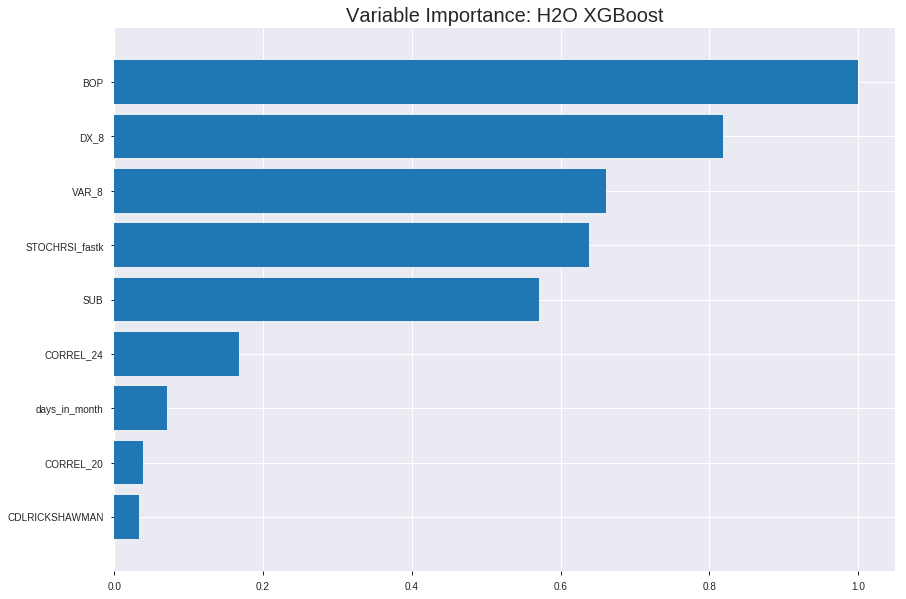

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_144827_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23720116219246185
RMSE: 0.4870330196120812
LogLoss: 0.6673040684320549
Mean Per-Class Error: 0.38318161304076037
AUC: 0.6644649692407704
pr_auc: 0.6578956430819771
Gini: 0.32892993848154073
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4619777624805768: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      631  1483  0.7015   (1483.0/2114.0)
1      238  1961  0.1082   (238.0/2199.0)
Total  869  3444  0.399    (1721.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461978     0.69502   279
max f2                       0.40202      0.840385  361
max f0point5                 0.49748      0.625467  210
max accuracy                 0.49748      0.618131  210
max precision                0.666535     1         0
max recall                   0.363114     1         390
max specificity              0.666535     1         0
max absolute_mcc             0.461978     0.237116  279
max min_per_class_accuracy   0.507586     0.611637  190
max mean_per_class_accuracy  0.499074     0.616818  206

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.623577           1.73847   1.73847            0.886364         0.634712  0.886364                    0.634712            0.0177353       0.0177353                  73.8466    73.8466
    2        0.0201716                   0.61105            1.64206   1.69082            0.837209         0.616918  0.862069                    0.625917            0.0163711       0.0341064                  64.2057    69.0816
    3        0.0301414                   0.604292           1.41399   1.59925            0.72093          0.607739  0.815385                    0.619904            0.0140973       0.0482037                  41.3994    59.9251
    4        0.0401113                   0.598866           1.45961   1.56454            0.744186         0.601487  0.797688                    0.615327            0.0145521       0.0627558                  45.9606    56.4542
    5        0.0500812                   0.592996           1.36838   1.52549            0.697674         0.595669  0.777778                    0.611413            0.0136426       0.0763984                  36.8381    52.5491
    6        0.100162                    0.57744            1.38021   1.45285            0.703704         0.584496  0.740741                    0.597955            0.0691223       0.145521                   38.0206    45.2849
    7        0.150012                    0.564749           1.3775    1.42781            0.702326         0.570841  0.727975                    0.588945            0.0686676       0.214188                   37.7504    42.7811
    8        0.200093                    0.554375           1.20768   1.37271            0.615741         0.55912   0.699884                    0.58148             0.060482        0.27467                    20.7681    37.2715
    9        0.300023                    0.537051           1.20593   1.31716            0.614849         0.545606  0.671561                    0.569531            0.120509        0.39518                    20.5932    31.7164
    10       0.399954                    0.523327           1.14222   1.27345            0.582367         0.530482  0.649275                    0.559775            0.114143        0.509322                   14.2222    27.3454
    11       0.500116                    0.507672           1.01245   1.22118            0.516204         0.51547   0.622624                    0.550901            0.10141         0.610732                   1.24541    22.1181
    12       0.600046                    0.492661           0.9966    1.18378            0.508121         0.500114  0.603555                    0.542443            0.0995907       0.710323                   -0.339956  18.378
    13       0.699977                    0.478131           0.919239  1.14601            0.468677         0.485126  0.584299                    0.53426             0.0918599       0.802183                   -8.07612   14.6013
    14       0.799907                    0.461439           0.901036  1.11541            0.459397         0.469753  0.568696                    0.526202            0.0900409       0.892224                   -9.8964    11.5409
    15       0.899838                    0.438869           0.600691  1.05825            0.306265         0.451243  0.539552                    0.517877            0.0600273       0.952251                   -39.9309   5.82475
    16       1                           0.325206           0.476716  1                  0.243056         0.412406  0.509854                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24851713444904744
RMSE: 0.49851492901321165
LogLoss: 0.6902604348840387
Mean Per-Class Error: 0.434238451027706
AUC: 0.5504060872116225
pr_auc: 0.5555309368037674
Gini: 0.10081217442324508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3398435711860657: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    583   1        (583.0/583.0)
1      0    649   0        (0.0/649.0)
Total  0    1232  0.4732   (583.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339844     0.690058  399
max f2                       0.339844     0.847701  399
max f0point5                 0.51066      0.586449  199
max accuracy                 0.51066      0.565747  199
max precision                0.658489     1         0
max recall                   0.339844     1         399
max specificity              0.658489     1         0
max absolute_mcc             0.51066      0.131337  199
max min_per_class_accuracy   0.51066      0.565485  199
max mean_per_class_accuracy  0.51066      0.565762  199

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.624029           0.730117  0.730117           0.384615         0.63446   0.384615                    0.63446             0.00770416      0.00770416                 -26.9883  -26.9883
    2        0.0202922                   0.616498           1.58192   1.13898            0.833333         0.619403  0.6                         0.627232            0.0154083       0.0231125                  58.1921   13.8983
    3        0.0300325                   0.610641           0.949153  1.07742            0.5              0.613426  0.567568                    0.622755            0.00924499      0.0323575                  -5.08475  7.74164
    4        0.0405844                   0.601985           0.876141  1.02508            0.461538         0.606323  0.54                        0.618482            0.00924499      0.0416025                  -12.3859  2.50847
    5        0.0503247                   0.597885           0.632768  0.949153           0.333333         0.599429  0.5                         0.614795            0.00616333      0.0477658                  -36.7232  -5.08475
    6        0.100649                    0.578782           1.07162   1.01039            0.564516         0.58654   0.532258                    0.600667            0.0539291       0.101695                   7.16238   1.03882
    7        0.150162                    0.568011           1.08919   1.03637            0.57377          0.574153  0.545946                    0.591925            0.0539291       0.155624                   8.91914   3.6372
    8        0.200487                    0.557415           1.1941    1.07596            0.629032         0.5627    0.566802                    0.584589            0.0600924       0.215716                   19.4095   7.59624
    9        0.300325                    0.543393           1.03404   1.06202            0.544715         0.550219  0.559459                    0.573163            0.103236        0.318952                   3.40361   6.20247
    10       0.400162                    0.527183           1.35814   1.1359             0.715447         0.535406  0.598377                    0.563743            0.135593        0.454545                   35.8137   13.5903
    11       0.5                         0.510689           1.0649    1.12173            0.560976         0.518056  0.590909                    0.554621            0.106317        0.560863                   6.49029   12.1726
    12       0.599838                    0.496073           0.787102  1.06603            0.414634         0.503587  0.56157                     0.546126            0.0785824       0.639445                   -21.2898  6.60306
    13       0.699675                    0.480709           0.848836  1.03504            0.447154         0.488702  0.545244                    0.537932            0.0847458       0.724191                   -15.1164  3.50387
    14       0.799513                    0.461401           1.03404   1.03491            0.544715         0.471163  0.545178                    0.529595            0.103236        0.827427                   3.40361   3.49135
    15       0.899351                    0.438454           0.756235  1.00398            0.398374         0.449733  0.528881                    0.520729            0.0755008       0.902928                   -24.3765  0.397724
    16       1                           0.339844           0.964461  1                  0.508065         0.414336  0.526786                    0.510021       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:48:36  2.787 sec   0                  0.5              0.693147            0.5             0                  1                0.490146                         0.5                0.693147              0.5               0                    1                  0.473214
    2019-08-24 14:48:36  2.860 sec   5                  0.497849         0.688851            0.607706        0.602834           1.50231          0.474843                         0.49904            0.691228              0.550073          0.553508             1.00499            0.473214
    2019-08-24 14:48:36  2.931 sec   10                 0.496167         0.685499            0.618368        0.615612           1.47101          0.462787                         0.498901           0.690952              0.545568          0.548284             0.876141           0.473214
    2019-08-24 14:48:36  3.012 sec   15                 0.494605         0.68239             0.626797        0.621776           1.42643          0.455831                         0.498257           0.689668              0.554069          0.55764              1.02216            0.473214
    2019-08-24 14:48:36  3.097 sec   20                 0.493042         0.67928             0.638518        0.63242            1.56016          0.431022                         0.497978           0.689114              0.555738          0.561699             1.02216            0.473214
    2019-08-24 14:48:36  3.176 sec   25                 0.491999         0.677201            0.641448        0.636098           1.60474          0.415952                         0.497963           0.689087              0.553607          0.564025             1.02216            0.473214
    2019-08-24 14:48:36  3.257 sec   30                 0.490861         0.674934            0.645971        0.638182           1.56016          0.411315                         0.49822            0.689618              0.550813          0.556822             0.730117           0.473214
    2019-08-24 14:48:36  3.343 sec   35                 0.489902         0.673027            0.652161        0.643851           1.64931          0.423835                         0.498298           0.689779              0.55001           0.556456             0.730117           0.473214
    2019-08-24 14:48:36  3.436 sec   40                 0.489075         0.671375            0.655444        0.648882           1.69389          0.420589                         0.498494           0.690193              0.549937          0.554151             0.584094           0.473214
    2019-08-24 14:48:36  3.535 sec   45                 0.487738         0.668708            0.661443        0.65799            1.78304          0.394853                         0.498499           0.690213              0.550249          0.55594              0.730117           0.473214
    2019-08-24 14:48:36  3.637 sec   50                 0.487033         0.667304            0.664465        0.657896           1.73847          0.399026                         0.498515           0.69026               0.550406          0.555531             0.730117           0.473214

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
BOP             720.208                1                    0.250062
DX_8            589.488                0.818496             0.204675
VAR_8           475.939                0.660835             0.16525
STOCHRSI_fastk  459.283                0.637709             0.159467
SUB             411.437                0.571275             0.142854
CORREL_24       121.292                0.168412             0.0421134
days_in_month   51.1385                0.0710053            0.0177557
CORREL_20       27.6655                0.0384132            0.00960569
CDLRICKSHAWMAN  23.6703                0.0328659            0.00821851

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5170178282009724)

('F1', 0.6695464362850972)

('auc', 0.49642219186718506)

('logloss', 0.7015395624094499)

('mean_per_class_error', 0.48357675738152783)

('rmse', 0.50410351393626)

('mse', 0.2541203527628851)

xgboost prediction progress: |████████████████████████████████████████████| 100%


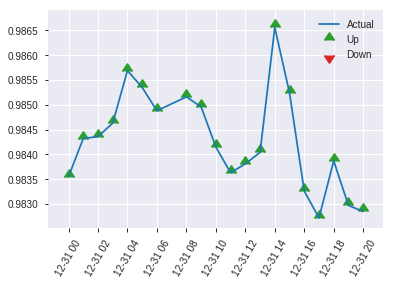


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541203527628851
RMSE: 0.50410351393626
LogLoss: 0.7015395624094499
Mean Per-Class Error: 0.48357675738152783
AUC: 0.49642219186718506
pr_auc: 0.5110303078753867
Gini: -0.007155616265629883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3571642339229584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    306  0.9967   (306.0/307.0)
1      0    310  0        (0.0/310.0)
Total  1    616  0.4959   (306.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357164     0.669546  398
max f2                       0.357164     0.835129  398
max f0point5                 0.357164     0.55876   398
max accuracy                 0.485614     0.517018  241
max precision                0.645316     1         0
max recall                   0.357164     1         398
max specificity              0.645316     1         0
max absolute_mcc             0.429017     0.12467   354
max min_per_class_accuracy   0.506342     0.504886  195
max mean_per_class_accuracy  0.485614     0.516423  241

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.614913           1.42166   1.42166            0.714286         0.626456  0.714286                    0.626456            0.016129        0.016129                   42.1659   42.1659
    2        0.0210697                   0.605027           0.663441  1.07171            0.333333         0.608443  0.538462                    0.618142            0.00645161      0.0225806                  -33.6559  7.17122
    3        0.0307942                   0.602566           1.32688   1.15229            0.666667         0.603477  0.578947                    0.613511            0.0129032       0.0354839                  32.6882   15.2292
    4        0.0405186                   0.599759           1.32688   1.19419            0.666667         0.60152   0.6                         0.610633            0.0129032       0.0483871                  32.6882   19.4194
    5        0.0502431                   0.597526           1.32688   1.21988            0.666667         0.59851   0.612903                    0.608287            0.0129032       0.0612903                  32.6882   21.9875
    6        0.100486                    0.578751           0.706243  0.963059           0.354839         0.587344  0.483871                    0.597815            0.0354839       0.0967742                  -29.3757  -3.69407
    7        0.150729                    0.563245           1.28408   1.07007            0.645161         0.570779  0.537634                    0.588803            0.0645161       0.16129                    28.4079   7.00659
    8        0.200972                    0.554531           0.963059  1.04331            0.483871         0.557461  0.524194                    0.580968            0.0483871       0.209677                   -3.69407  4.33143
    9        0.299838                    0.538178           0.880962  0.989782           0.442623         0.546671  0.497297                    0.569659            0.0870968       0.296774                   -11.9038  -1.0218
    10       0.400324                    0.521192           1.02726   0.99919            0.516129         0.529634  0.502024                    0.559612            0.103226        0.4                        2.72633   -0.0809717
    11       0.50081                     0.506342           1.05937   1.01126            0.532258         0.513575  0.508091                    0.550375            0.106452        0.506452                   5.93652   1.12642
    12       0.599676                    0.490456           0.978847  1.00592            0.491803         0.498189  0.505405                    0.541771            0.0967742       0.603226                   -2.11528  0.591979
    13       0.700162                    0.469738           0.963059  0.999769           0.483871         0.479936  0.502315                    0.532897            0.0967742       0.7                        -3.69407  -0.0231481
    14       0.799028                    0.454118           0.880962  0.985068           0.442623         0.461715  0.494929                    0.524089            0.0870968       0.787097                   -11.9038  -1.49316
    15       0.899514                    0.432873           0.834651  0.968265           0.419355         0.44533   0.486486                    0.515291            0.083871        0.870968                   -16.5349  -3.1735
    16       1                           0.319501           1.28408   1                  0.645161         0.404979  0.502431                    0.504206

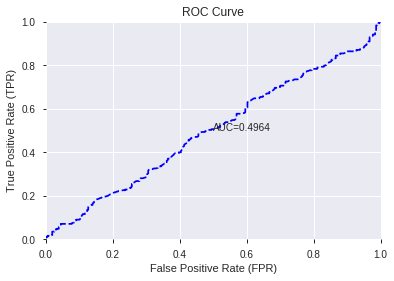

This function is available for GLM models only


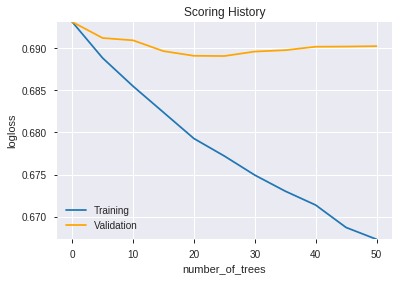

--2019-08-24 14:48:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_144827_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_144827_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DX_8',
 'VAR_8',
 'STOCHRSI_fastk',
 'SUB',
 'CORREL_24',
 'days_in_month',
 'CORREL_20',
 'CDLRICKSHAWMAN']

In [24]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [26]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [27]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [28]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [30]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [31]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [32]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [34]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [35]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [36]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [38]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [39]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [40]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [42]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [43]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [44]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [46]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [47]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [48]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [49]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 893 937 939] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_144951_model_3  0.523547  0.964147              0.491809  0.585794  0.343155
1  DeepLearning_grid_1_AutoML_20190824_144951_model_4  0.506751  0.707800              0.496743  0.506197  0.256236
2  DeepLearning_grid_1_AutoML_20190824_144951_model_7  0.502926  0.700347              0.500000  0.503561  0.253574
3               DeepLearning_1_AutoML_20190824_144951  0.501513  0.717479              0.500000  0.502369  0.252374
4  DeepLearning_grid_1_AutoML_20190824_144951_model_6  0.500000  0.693310              0.500000  0.500081  0.250081
5  DeepLearning_grid_1_AutoML_20190824_144951_model_5  0.500000  0.693229              0.500000  0.500041  0.250041
6  DeepLearning_grid_1_AutoML_20190824_144951_model_8  0.500000  0.693273              0.500000  0.500063  0.250063
7  DeepLearning_grid_1_AutoML_20190824_144951_model_1  0.492886  0.708371              0.485263  0.507112  0.257162
8  DeepLearning_grid_1_AutoML_20190824_144951_model_2  0.486330  0.707546              0.498371  0.506951  0.256999

variable  relative_importance  scaled_importance  percentage
0           CORREL_12             1.000000           1.000000    0.005202
1           CORREL_14             0.948944           0.948944    0.004936
2               FLOOR             0.934746           0.934746    0.004862
3                CEIL             0.930110           0.930110    0.004838
4     CDLSHOOTINGSTAR             0.864008           0.864008    0.004494
...               ...                  ...                ...         ...
1033           ROC_24             0.132086           0.132086    0.000687
1034       MACDFIX_12             0.130105           0.130105    0.000677
1035        CDLHARAMI             0.130100           0.130100    0.000677
1036      CDLMARUBOZU             0.113247           0.113247    0.000589
1037       CDL3INSIDE             0.083850           0.083850    0.000436

[1038 rows x 4 columns]

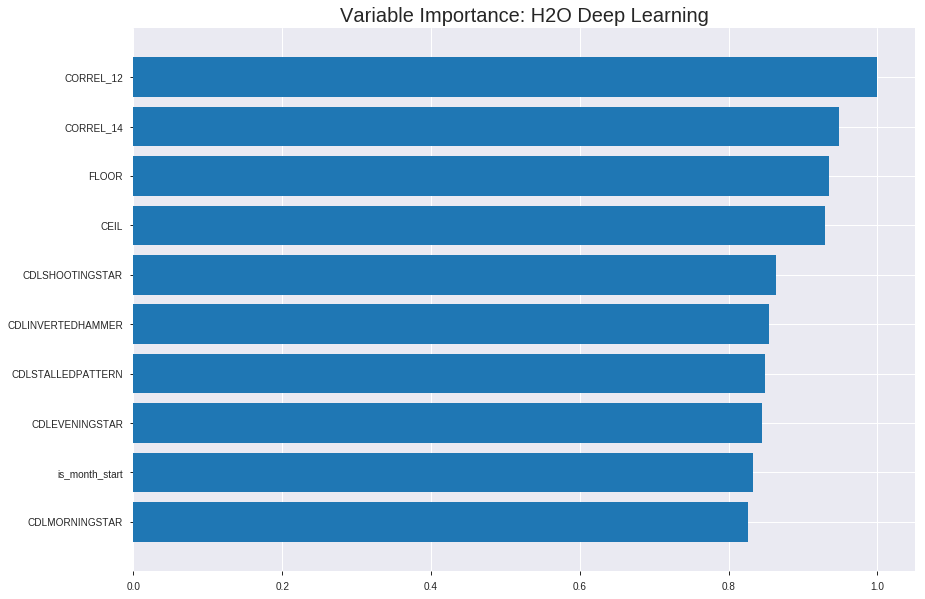

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_144951_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2854299547266414
RMSE: 0.5342564503369532
LogLoss: 0.7897401042527914
Mean Per-Class Error: 0.47967909641563233
AUC: 0.524492297393285
pr_auc: 0.5295382920806799
Gini: 0.04898459478656991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.017129687416442396: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      1    2113  0.9995   (2113.0/2114.0)
1      0    2199  0        (0.0/2199.0)
Total  1    4312  0.4899   (2113.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0171297    0.675472   398
max f2                       0.0171297    0.838801   398
max f0point5                 0.188612     0.567738   317
max accuracy                 0.188612     0.526548   317
max precision                0.734597     0.666667   2
max recall                   0.0171297    1          398
max specificity              0.761676     0.999527   0
max absolute_mcc             0.188612     0.0568233  317
max min_per_class_accuracy   0.376508     0.511141   187
max mean_per_class_accuracy  0.271202     0.520321   264

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 36.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.633713           1.15898   1.15898            0.590909         0.663737  0.590909                    0.663737            0.0118236       0.0118236                  15.8977    15.8977
    2        0.0201716                   0.602443           1.04909   1.10467            0.534884         0.617871  0.563218                    0.641068            0.0104593       0.0222829                  4.90921    10.4666
    3        0.0301414                   0.584767           1.04909   1.08628            0.534884         0.594326  0.553846                    0.625607            0.0104593       0.0327422                  4.90921    8.6284
    4        0.0401113                   0.575109           1.23154   1.12239            0.627907         0.580139  0.572254                    0.614306            0.0122783       0.0450205                  23.1543    12.2389
    5        0.0500812                   0.565863           0.957867  1.08964            0.488372         0.570599  0.555556                    0.605605            0.0095498       0.0545703                  -4.21333   8.96367
    6        0.100162                    0.534152           1.02607   1.05786            0.523148         0.54888   0.539352                    0.577242            0.051387        0.105957                   2.60746    5.78556
    7        0.150012                    0.51643            1.07646   1.06404            0.548837         0.525465  0.542504                    0.560036            0.0536608       0.159618                   7.64597    6.40378
    8        0.200093                    0.499153           1.05332   1.06135            0.537037         0.507803  0.541136                    0.546963            0.0527513       0.212369                   5.33155    6.13541
    9        0.300023                    0.458736           1.0148    1.04585            0.517401         0.479384  0.53323                     0.524454            0.10141         0.313779                   1.48032    4.58491
    10       0.399954                    0.415535           1.0148    1.03809            0.517401         0.436717  0.529275                    0.502532            0.10141         0.415189                   1.48032    3.80921
    11       0.500116                    0.37483            0.971593  1.02477            0.49537          0.395349  0.522485                    0.481066            0.097317        0.512506                   -2.84073   2.47738
    12       0.600046                    0.330829           1.03301   1.02614            0.526682         0.353064  0.523184                    0.459749            0.103229        0.615734                   3.30059    2.61447
    13       0.699977                    0.280052           0.9966    1.02193            0.508121         0.306158  0.521033                    0.437822            0.0995907       0.715325                   -0.339956  2.19269
    14       0.799907                    0.227937           1.0057    1.0199             0.512761         0.254313  0.52                        0.414897            0.1005          0.815825                   0.570181   1.99
    15       0.899838                    0.16275            0.978398  1.01529            0.49884          0.198404  0.51765                     0.390854            0.0977717       0.913597                   -2.16023   1.5291
    16       1                           0.0117645          0.862629  1                  0.439815         0.106693  0.509854                    0.362



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3499918743856268
RMSE: 0.5916011108725429
LogLoss: 1.0558515612394557
Mean Per-Class Error: 0.47400936128150706
AUC: 0.5211064918452191
pr_auc: 0.550609427281103
Gini: 0.04221298369043813
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.000860713026511675: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    583   1        (583.0/583.0)
1      0    649   0        (0.0/649.0)
Total  0    1232  0.4732   (583.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000860713  0.690058   399
max f2                       0.000860713  0.847701   399
max f0point5                 0.000860713  0.581854   399
max accuracy                 0.0399294    0.530844   373
max precision                0.602423     0.733333   13
max recall                   0.000860713  1          399
max specificity              0.696674     0.998285   0
max absolute_mcc             0.403499     0.0624823  113
max min_per_class_accuracy   0.231744     0.511556   227
max mean_per_class_accuracy  0.37496      0.525991   130

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 24.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.611076           1.31421   1.31421            0.692308         0.649789   0.692308                    0.649789            0.0138675       0.0138675                  31.4211   31.4211
    2        0.0202922                   0.58655            1.26554   1.29085            0.666667         0.596951   0.68                        0.624426            0.0123267       0.0261941                  26.5537   29.0847
    3        0.0300325                   0.555306           0.949153  1.18003            0.5              0.573048   0.621622                    0.607763            0.00924499      0.0354391                  -5.08475  18.0027
    4        0.0405844                   0.543813           1.16819   1.17695            0.615385         0.549787   0.62                        0.592689            0.0123267       0.0477658                  16.8188   17.6949
    5        0.0503247                   0.537117           1.10734   1.16348            0.583333         0.540844   0.612903                    0.582655            0.0107858       0.0585516                  10.7345   16.3477
    6        0.100649                    0.500255           0.949153  1.05631            0.5              0.518283   0.556452                    0.550469            0.0477658       0.106317                   -5.08475  5.63149
    7        0.150162                    0.459629           1.24479   1.11846            0.655738         0.478192   0.589189                    0.526637            0.0616333       0.167951                   24.479    11.8461
    8        0.200487                    0.415127           1.04101   1.09902            0.548387         0.437145   0.578947                    0.504173            0.0523883       0.220339                   4.1006    9.90187
    9        0.300325                    0.334054           1.00317   1.06716            0.528455         0.369905   0.562162                    0.459538            0.100154        0.320493                   0.316935  6.71553
    10       0.400162                    0.280253           0.910569  1.02809            0.479675         0.305546   0.541582                    0.421118            0.0909091       0.411402                   -8.94309  2.80881
    11       0.5                         0.231381           1.00317   1.02311            0.528455         0.256157   0.538961                    0.38818             0.100154        0.511556                   0.316935  2.31125
    12       0.599838                    0.171863           1.0186    1.02236            0.536585         0.203196   0.538566                    0.357391            0.101695        0.613251                   1.86027   2.23619
    13       0.699675                    0.105653           0.926002  1.00861            0.487805         0.138085   0.531323                    0.326098            0.0924499       0.705701                   -7.39975  0.861221
    14       0.799513                    0.0685094          0.972303  1.00408            0.512195         0.0850659  0.528934                    0.295999            0.0970724       0.802773                   -2.76974  0.407812
    15       0.899351                    0.043734           0.987736  1.00226            0.520325         0.055035   0.527978                    0.26925             0.0986133       0.901387                   -1.2264   0.226397
    16       1                           0.000643839        0.97977   1                  0.516129         0.0294723  0.526786                


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:05:22  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:05:23  15 min 31.161 sec  479 obs/sec       0.214468  1             925        0.694195         6.15563             -0.928377      0.498604        0.377759           0.936097         0.490146                         0.701919           7.94946               -0.976434        0.520341          0.545825             1.16819            0.473214
    2019-08-24 15:05:54  16 min  1.310 sec  576 obs/sec       3.89311   18            16791      0.608413         1.17115             -0.48124       0.527322        0.528765           1.24813          0.490146                         0.632468           1.28459               -0.60467         0.503625          0.529627             1.31421            0.473214
    2019-08-24 15:06:24  16 min 32.012 sec  590 obs/sec       7.78623   36            33582      0.563722         0.883415            -0.271625      0.508143        0.514751           1.06983          0.488523                         0.572004           0.934588              -0.312522        0.509004          0.540051             1.46023            0.471591
    2019-08-24 15:06:55  17 min  2.614 sec  608 obs/sec       11.9277   55            51444      0.529458         0.769937            -0.121737      0.531524        0.528919           0.980673         0.489914                         0.557995           0.866708              -0.249019        0.532132          0.551521             0.730117           0.473214
    2019-08-24 15:07:25  17 min 33.076 sec  626 obs/sec       16.2664   75            70157      0.55168          0.851762            -0.217876      0.511193        0.519971           1.06983          0.488987                         0.543288           0.81176               -0.184045        0.504317          0.534124             1.31421            0.470779
    2019-08-24 15:07:55  18 min  2.413 sec  642 obs/sec       20.6485   95            89057      0.535801         0.794149            -0.148776      0.520699        0.520132           1.1144           0.48945                          0.559333           0.906141              -0.255016        0.50273           0.530282             1.46023            0.473214
    2019-08-24 15:08:23  18 min 30.994 sec  658 obs/sec       25.0538   115           108057     0.502949         0.699892            -0.0122256     0.552639        0.554279           1.33728          0.487827                         0.516693           0.730123              -0.070961        0.512917          0.53945              1.02216            0.473214
    2019-08-24 15:08:53  19 min  1.007 sec  672 obs/sec       29.8347   137           128677     0.530525         0.785702            -0.126266      0.521094        0.532524           1.29271          0.488291                         0.519658           0.748989              -0.0832882       0.507351          0.530924             1.16819            0.472403
    2019-08-

Variable Importances: 


variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  ---------------------
CORREL_12        1.0                    1.0                  0.005201619412961134
CORREL_14        0.9489443898200989     0.9489443898200989   0.004936047559908785
FLOOR            0.9347460865974426     0.9347460865974426   0.004862193390234707
CEIL             0.9301095604896545     0.9301095604896545   0.004838075946023736
CDLSHOOTINGSTAR  0.8640077114105225     0.8640077114105225   0.004494239284621095
---              ---                    ---                  ---
ROC_24           0.1320863515138626     0.1320863515138626   0.0006870629302217161
MACDFIX_12       0.13010479509830475    0.13010479509830475  0.0006767556279026726
CDLHARAMI        0.1300995945930481     0.1300995945930481   0.0006767285768535724
CDLMARUBOZU      0.1132471114397049     0.1132471114397049   0.000589068373326542
CDL3INSIDE       0.08384986221790314    0.08384986221790314  0.0004361550710867613


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5299837925445705)

('F1', 0.6703056768558951)

('auc', 0.523547336345487)

('logloss', 0.9641466106681139)

('mean_per_class_error', 0.4708153829988442)

('rmse', 0.585793938807753)

('mse', 0.3431545387439014)

deeplearning prediction progress: |███████████████████████████████████████| 100%


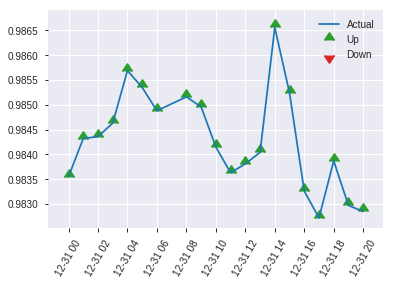


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3431545387439014
RMSE: 0.585793938807753
LogLoss: 0.9641466106681139
Mean Per-Class Error: 0.4708153829988442
AUC: 0.523547336345487
pr_auc: 0.52115739695982
Gini: 0.047094672690974004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02685927979104368: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    299  0.9739   (299.0/307.0)
1      3    307  0.0097   (3.0/310.0)
Total  11   606  0.4895   (302.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0268593    0.670306   390
max f2                       0.0144507    0.83558    397
max f0point5                 0.0366345    0.562546   384
max accuracy                 0.167317     0.529984   264
max precision                0.460237     1          0
max recall                   0.0144507    1          397
max specificity              0.460237     1          0
max absolute_mcc             0.347535     0.0861144  25
max min_per_class_accuracy   0.195808     0.525806   210
max mean_per_class_accuracy  0.167317     0.529185   264

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 20.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.417482           1.13733   1.13733            0.571429         0.431542   0.571429                    0.431542            0.0129032       0.0129032                  13.7327    13.7327
    2        0.0210697                   0.386066           0.995161  1.07171            0.5              0.396383   0.538462                    0.415315            0.00967742      0.0225806                  -0.483871  7.17122
    3        0.0307942                   0.361521           1.32688   1.15229            0.666667         0.372817   0.578947                    0.401894            0.0129032       0.0354839                  32.6882    15.2292
    4        0.0405186                   0.351114           1.99032   1.35342            1                0.358228   0.68                        0.391415            0.0193548       0.0548387                  99.0323    35.3419
    5        0.0502431                   0.340534           0.663441  1.21988            0.333333         0.345375   0.612903                    0.382504            0.00645161      0.0612903                  -33.6559   21.9875
    6        0.100486                    0.312081           1.02726   1.12357            0.516129         0.327035   0.564516                    0.354769            0.0516129       0.112903                   2.72633    12.3569
    7        0.150729                    0.295094           0.898855  1.04866            0.451613         0.304308   0.526882                    0.337949            0.0451613       0.158065                   -10.1145   4.86646
    8        0.200972                    0.27991            0.963059  1.02726            0.483871         0.288223   0.516129                    0.325518            0.0483871       0.206452                   -3.69407   2.72633
    9        0.299838                    0.245962           1.01148   1.02206            0.508197         0.261907   0.513514                    0.304543            0.1             0.306452                   1.14754    2.20575
    10       0.400324                    0.221124           1.05937   1.03142            0.532258         0.235037   0.518219                    0.287096            0.106452        0.412903                   5.93652    3.14222
    11       0.50081                     0.195349           1.12357   1.04991            0.564516         0.208484   0.527508                    0.271323            0.112903        0.525806                   12.3569    4.99113
    12       0.599676                    0.177445           0.946219  1.03282            0.47541          0.186523   0.518919                    0.257343            0.0935484       0.619355                   -5.37811   3.2816
    13       0.700162                    0.159249           0.995161  1.02741            0.5              0.16922    0.516204                    0.244695            0.1             0.719355                   -0.483871  2.74119
    14       0.799028                    0.136358           0.946219  1.01737            0.47541          0.147805   0.511156                    0.232707            0.0935484       0.812903                   -5.37811   1.73657
    15       0.899514                    0.0934153          0.930957  1.00771            0.467742         0.11795    0.506306                    0.219887            0.0935484       0.906452                   -6.90427   0.771287
    16       1                           0.00423051         0.930957  1                  0.467742         0.0514539  0.502431  

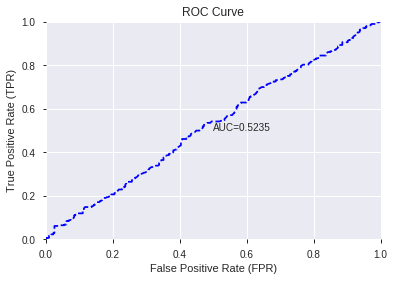

This function is available for GLM models only


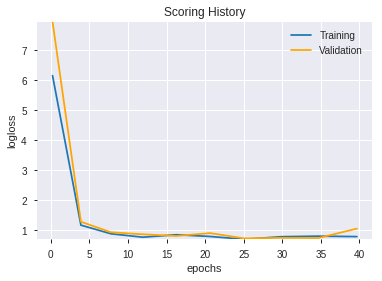

--2019-08-24 15:44:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_144951_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_144951_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_12',
 'CORREL_14',
 'FLOOR',
 'CEIL',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'is_month_start',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'is_month_end',
 'CORREL_8',
 'CDLTHRUSTING',
 'CDLIDENTICAL3CROWS',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'days_in_month',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CDLTAKURI',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLPIERCING',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CORREL_20',
 'CDLRICKSHAWMAN',
 'CORREL_24',
 'CDLGAPSIDESIDEWHITE',
 'HT_TRENDMODE',
 'CDL2CROWS',
 'CDLLONGLEGGEDDOJI',
 'CDLLADDERBOTTOM',
 'CDLDOJI',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'CDL3LINESTRIKE',
 'hour',
 'VAR_8',
 'CORREL_30',
 'CDLSEPARATINGLINES',
 'SAREXT',
 'BOP',
 'day',
 'week',
 'TRANGE',
 'weekofyear',
 'aroondown_12',
 'CDLHARAMICROSS',
 'DIV',
 'SUB',
 'HT_DCPERIOD',
 'dayofyear',
 'aroonup_14',
 'VAR_1

In [50]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_154509_model_1  0.498419  0.694098              0.495067  0.500475  0.250475

variable  relative_importance  scaled_importance  percentage
0               STOCHRSI_fastk             0.009363           1.000000    0.015115
1                          BOP             0.008705           0.929676    0.014052
2               CDLSPINNINGTOP             0.007856           0.839044    0.012682
3            CDLDARKCLOUDCOVER             0.006929           0.740060    0.011186
4                 CDLSHORTLINE             0.006792           0.725436    0.010965
...                        ...                  ...                ...         ...
1033                   MA_14_1             0.000000           0.000000    0.000000
1034  BBANDS_middleband_14_1_2             0.000000           0.000000    0.000000
1035                   MA_14_2             0.000000           0.000000    0.000000
1036  BBANDS_middleband_30_5_3             0.000000           0.000000    0.000000
1037  BBANDS_middleband_30_5_4             0.000000           0.000000    0.000000

[1038 rows x 4 columns]

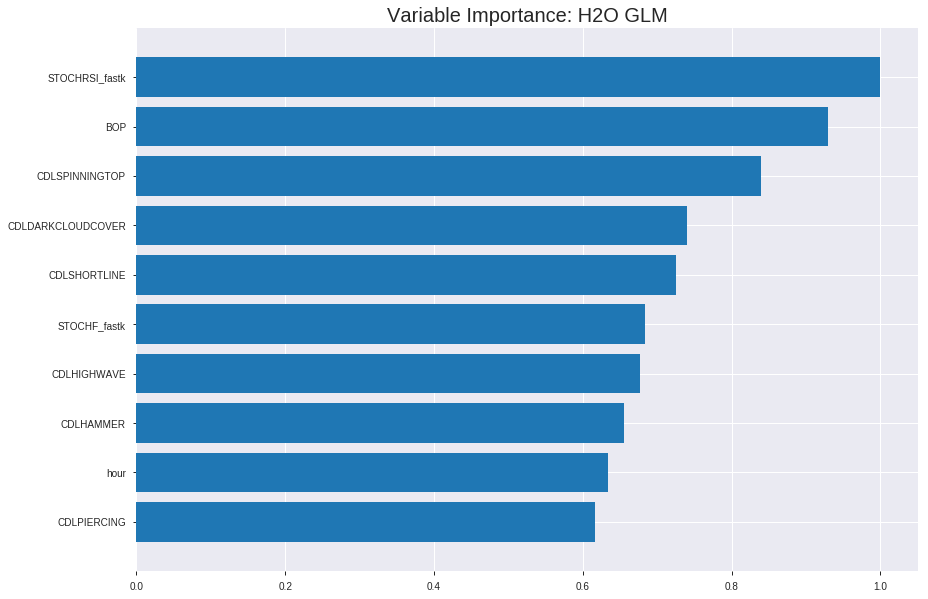

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_154509_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24778917866880512
RMSE: 0.497784269205853
LogLoss: 0.6887150663290209
Null degrees of freedom: 4312
Residual degrees of freedom: 3282
Null deviance: 5977.4123029576585
Residual deviance: 5940.856162154133
AIC: 8002.856162154133
AUC: 0.5712485205496779
pr_auc: 0.5707556257790918
Gini: 0.1424970410993558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4382638445421154: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      18   2096  0.9915   (2096.0/2114.0)
1      5    2194  0.0023   (5.0/2199.0)
Total  23   4290  0.4871   (2101.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438264     0.676221  381
max f2                       0.398919     0.838993  395
max f0point5                 0.503256     0.575526  221
max accuracy                 0.507828     0.55553   199
max precision                0.578844     1         0
max recall                   0.398919     1         395
max specificity              0.578844     1         0
max absolute_mcc             0.516594     0.111596  151
max min_per_class_accuracy   0.511134     0.554798  181
max mean_per_class_accuracy  0.511829     0.5553    177

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.549572           1.33728   1.33728            0.681818         0.555754  0.681818                    0.555754            0.0136426       0.0136426                  33.7281    33.7281
    2        0.0201716                   0.546446           1.36838   1.35265            0.697674         0.547672  0.689655                    0.55176             0.0136426       0.0272851                  36.8381    35.2652
    3        0.0301414                   0.544516           1.0947    1.26733            0.55814          0.545439  0.646154                    0.549669            0.0109141       0.0381992                  9.47048    26.7331
    4        0.0401113                   0.542237           0.957867  1.19041            0.488372         0.543541  0.606936                    0.548146            0.0095498       0.047749                   -4.21333   19.0412
    5        0.0500812                   0.539742           1.27716   1.20768            0.651163         0.540983  0.615741                    0.54672             0.0127331       0.060482                   27.7156    20.7681
    6        0.100162                    0.534608           1.13504   1.17136            0.578704         0.53694   0.597222                    0.54183             0.056844        0.117326                   13.5038    17.1359
    7        0.150012                    0.530543           1.23154   1.19136            0.627907         0.532446  0.607419                    0.538712            0.0613915       0.178718                   23.1543    19.1359
    8        0.200093                    0.527022           1.17136   1.18635            0.597222         0.528889  0.604867                    0.536253            0.058663        0.237381                   17.1359    18.6353
    9        0.300023                    0.520853           1.09672   1.1565             0.559165         0.523688  0.589645                    0.532068            0.109595        0.346976                   9.67155    15.6497
    10       0.399954                    0.516058           1.05121   1.13019            0.535963         0.518351  0.576232                    0.528641            0.105048        0.452024                   5.12087    13.019
    11       0.500116                    0.511116           1.01245   1.10661            0.516204         0.513554  0.56421                     0.525619            0.10141         0.553433                   1.24541    10.661
    12       0.600046                    0.506269           0.923789  1.07616            0.470998         0.508812  0.548686                    0.52282             0.0923147       0.645748                   -7.62106   7.61636
    13       0.699977                    0.501076           0.9966    1.0648             0.508121         0.503794  0.542895                    0.520104            0.0995907       0.745339                   -0.339956  6.4805
    14       0.799907                    0.494798           0.869181  1.04037            0.443155         0.498086  0.530435                    0.517353            0.0868577       0.832196                   -13.0819   4.03662
    15       0.899838                    0.484582           0.869181  1.02136            0.443155         0.490384  0.520742                    0.514358            0.0868577       0.919054                   -13.0819   2.13554
    16       1                           0.377778           0.808147  1                  0.412037         0.469388  0.509854                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24905459135946756
RMSE: 0.4990536958679572
LogLoss: 0.6912547772697669
Null degrees of freedom: 1231
Residual degrees of freedom: 201
Null deviance: 1705.7914799426171
Residual deviance: 1703.2517711927057
AIC: 3765.2517711927057
AUC: 0.5326085520143141
pr_auc: 0.5468294414573177
Gini: 0.06521710402862824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4485647679607355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    578   0.9914   (578.0/583.0)
1      0    649   0        (0.0/649.0)
Total  5    1227  0.4692   (578.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.448565     0.691898   395
max f2                       0.448565     0.84881    395
max f0point5                 0.453509     0.584133   389
max accuracy                 0.491333     0.539773   277
max precision                0.562639     1          0
max recall                   0.448565     1          395
max specificity              0.562639     1          0
max absolute_mcc             0.544341     0.0715337  10
max min_per_class_accuracy   0.506652     0.528505   188
max mean_per_class_accuracy  0.507053     0.532096   186

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 50.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.543753           0.43807   0.43807            0.230769         0.549981  0.230769                    0.549981            0.0046225       0.0046225                  -56.193   -56.193
    2        0.0202922                   0.541065           1.42373   0.911186           0.75             0.542348  0.48                        0.546317            0.0138675       0.01849                    42.3729   -8.88136
    3        0.0300325                   0.539544           1.42373   1.07742            0.75             0.540314  0.567568                    0.54437             0.0138675       0.0323575                  42.3729   7.74164
    4        0.0405844                   0.538194           0.876141  1.02508            0.461538         0.538978  0.54                        0.542968            0.00924499      0.0416025                  -12.3859  2.50847
    5        0.0503247                   0.53675            0.949153  1.01039            0.5              0.537304  0.532258                    0.541872            0.00924499      0.0508475                  -5.08475  1.03882
    6        0.100649                    0.530008           1.31657   1.16348            0.693548         0.533252  0.612903                    0.537562            0.0662558       0.117103                   31.6566   16.3477
    7        0.150162                    0.526365           0.964712  1.09794            0.508197         0.528275  0.578378                    0.5345              0.0477658       0.164869                   -3.52876  9.79386
    8        0.200487                    0.522726           1.07162   1.09133            0.564516         0.524528  0.574899                    0.531997            0.0539291       0.218798                   7.16238   9.13333
    9        0.300325                    0.516255           0.910569  1.03124            0.479675         0.519491  0.543243                    0.527839            0.0909091       0.309707                   -8.94309  3.12414
    10       0.400162                    0.511248           1.12664   1.05504            0.593496         0.513461  0.555781                    0.524252            0.112481        0.422188                   12.6636   5.50418
    11       0.5                         0.50661            1.0649    1.05701            0.560976         0.508804  0.556818                    0.521167            0.106317        0.528505                   6.49029   5.70108
    12       0.599838                    0.501645           0.956869  1.04034            0.504065         0.504097  0.548038                    0.518326            0.0955316       0.624037                   -4.31308  4.03431
    13       0.699675                    0.495147           0.956869  1.02843            0.504065         0.498573  0.541763                    0.515508            0.0955316       0.719569                   -4.31308  2.84321
    14       0.799513                    0.489188           0.941436  1.01757            0.495935         0.492442  0.536041                    0.512627            0.0939908       0.813559                   -5.85641  1.75686
    15       0.899351                    0.479334           0.956869  1.01083            0.504065         0.484363  0.532491                    0.50949             0.0955316       0.909091                   -4.31308  1.08303
    16       1                           0.44138            0.903226  1                  0.475806         0.46811   0.526786                    0.505325        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 15:45:16  0.000 sec   2            2.7       1030          1.37894           1.38256
    2019-08-24 15:45:21  4.367 sec   4            2         1031          1.37743           1.38251
    2019-08-24 15:45:25  8.868 sec   6            1.4       1032          1.37566           1.3826
    2019-08-24 15:45:30  13.409 sec  8            1         1033          1.37365           1.38293
    2019-08-24 15:45:34  17.889 sec  10           0.76      1035          1.37141           1.38356
    2019-08-24 15:45:40  23.263 sec  12           0.56      1039          1.36899           1.38456
    2019-08-24 15:45:44  27.999 sec  14           0.4       1039          1.36643           1.38596

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.513776337115073)

('F1', 0.6688453159041394)

('auc', 0.4984186193128086)

('logloss', 0.6940978858640193)

('mean_per_class_error', 0.48432804455185463)

('rmse', 0.5004746399619295)

('mse', 0.250474865245023)

glm prediction progress: |████████████████████████████████████████████████| 100%


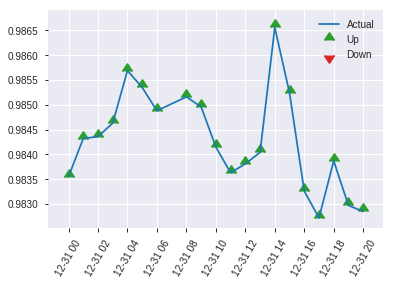


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.250474865245023
RMSE: 0.5004746399619295
LogLoss: 0.6940978858640193
Null degrees of freedom: 616
Residual degrees of freedom: -414
Null deviance: 855.4650475313558
Residual deviance: 856.5167911561998
AIC: 2918.5167911562
AUC: 0.4984186193128086
pr_auc: 0.5126763573991836
Gini: -0.003162761374382761
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44188315999179956: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    301  0.9805   (301.0/307.0)
1      3    307  0.0097   (3.0/310.0)
Total  9    608  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.441883     0.668845   390
max f2                       0.419453     0.83468    399
max f0point5                 0.461262     0.560641   362
max accuracy                 0.526316     0.513776   48
max precision                0.558742     1          0
max recall                   0.419453     1          399
max specificity              0.558742     1          0
max absolute_mcc             0.5508       0.0695608  2
max min_per_class_accuracy   0.501227     0.488599   185
max mean_per_class_accuracy  0.526316     0.515672   48

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 49.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.542736           1.42166   1.42166            0.714286         0.549628  0.714286                    0.549628            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.538717           0.995161  1.22481            0.5              0.540421  0.615385                    0.545378            0.00967742      0.0258065                  -0.483871  22.4814
    3        0.0307942                   0.535902           0.995161  1.15229            0.5              0.536712  0.578947                    0.542641            0.00967742      0.0354839                  -0.483871  15.2292
    4        0.0405186                   0.534285           0.995161  1.11458            0.5              0.534805  0.56                        0.540761            0.00967742      0.0451613                  -0.483871  11.4581
    5        0.0502431                   0.533574           0.995161  1.09147            0.5              0.533842  0.548387                    0.539422            0.00967742      0.0548387                  -0.483871  9.14672
    6        0.100486                    0.526713           1.15567   1.12357            0.580645         0.530247  0.564516                    0.534834            0.0580645       0.112903                   15.5671    12.3569
    7        0.150729                    0.522168           0.898855  1.04866            0.451613         0.524452  0.526882                    0.531374            0.0451613       0.158065                   -10.1145   4.86646
    8        0.200972                    0.519695           1.09147   1.05937            0.548387         0.520837  0.532258                    0.528739            0.0548387       0.212903                   9.14672    5.93652
    9        0.299838                    0.513181           0.946219  1.02206            0.47541          0.516498  0.513514                    0.524703            0.0935484       0.306452                   -5.37811   2.20575
    10       0.400324                    0.507432           0.834651  0.975016           0.419355         0.510268  0.489879                    0.52108             0.083871        0.390323                   -16.5349   -2.49837
    11       0.50081                     0.501207           0.995161  0.979058           0.5              0.504363  0.491909                    0.517726            0.1             0.490323                   -0.483871  -2.09416
    12       0.599676                    0.494891           1.10936   1.00054            0.557377         0.498214  0.502703                    0.514509            0.109677        0.6                        10.936     0.0540541
    13       0.700162                    0.488633           0.995161  0.999769           0.5              0.491874  0.502315                    0.51126             0.1             0.7                        -0.483871  -0.0231481
    14       0.799028                    0.480694           0.946219  0.993143           0.47541          0.485142  0.498986                    0.508029            0.0935484       0.793548                   -5.37811   -0.685729
    15       0.899514                    0.467329           1.02726   0.996954           0.516129         0.474562  0.500901                    0.50429             0.103226        0.896774                   2.72633    -0.304563
    16       1                           0.419453           1.02726   1                  0.516129         0.453796  0.502431         

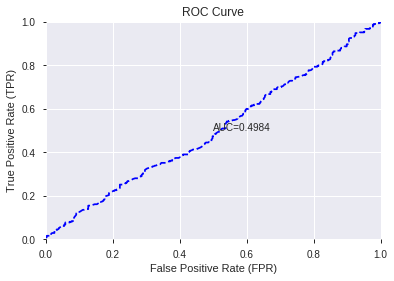

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


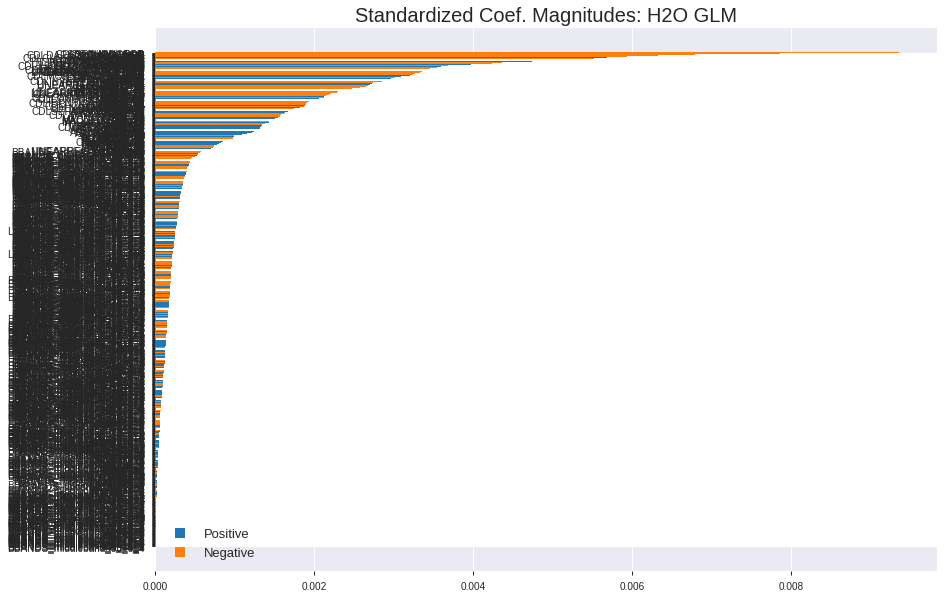

'log_likelihood'
--2019-08-24 15:46:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_154509_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_154509_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['STOCHRSI_fastk',
 'BOP',
 'CDLSPINNINGTOP',
 'CDLDARKCLOUDCOVER',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'CDLHIGHWAVE',
 'CDLHAMMER',
 'hour',
 'CDLPIERCING',
 'is_month_end',
 'CDLCLOSINGMARUBOZU',
 'is_month_start',
 'BETA_24',
 'CDLTHRUSTING',
 'ULTOSC',
 'CDLEVENINGSTAR',
 'Volume',
 'HT_PHASOR_quadrature',
 'CDLSTICKSANDWICH',
 'MFI_30',
 'CDLRICKSHAWMAN',
 'CDLMARUBOZU',
 'CDLTAKURI',
 'MFI_24',
 'BETA_20',
 'CDLHIKKAKE',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN',
 'CDL2CROWS',
 'aroonup_20',
 'day',
 'CDLBELTHOLD',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'LINEARREG_SLOPE_12',
 'CDLGAPSIDESIDEWHITE',
 'LINEARREG_ANGLE_12',
 'CDLDRAGONFLYDOJI',
 'CDLLADDERBOTTOM',
 'CDLADVANCEBLOCK',
 'ATR_8',
 'days_in_month',
 'DIV',
 'ADX_24',
 'SUB',
 'NATR_8',
 'CDLLONGLINE',
 'CDLMORNINGDOJISTAR',
 'CDL3LINESTRIKE',
 'aroondown_12',
 'STOCH_slowd',
 'ATR_12',
 'MFI_20',
 'CDLENGULFING',
 'aroonup_14',
 'CEIL',
 'NATR_12',
 'VAR_24',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'CDL3OUTSIDE',
 'ATR_14',
 '

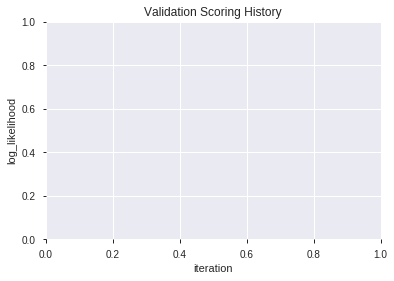

In [51]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_154704_model_6  0.535048  0.698897              0.477025  0.502797  0.252804
1  XGBoost_grid_1_AutoML_20190824_154704_model_1  0.534764  0.698651              0.495114  0.502610  0.252617
2  XGBoost_grid_1_AutoML_20190824_154704_model_5  0.530367  0.716392              0.495098  0.510081  0.260182
3               XGBoost_3_AutoML_20190824_154704  0.526931  0.698824              0.498371  0.502701  0.252708
4  XGBoost_grid_1_AutoML_20190824_154704_model_3  0.509247  0.706312              0.490212  0.506325  0.256365
5  XGBoost_grid_1_AutoML_20190824_154704_model_7  0.507224  0.713599              0.500000  0.509434  0.259523
6  XGBoost_grid_1_AutoML_20190824_154704_model_4  0.506100  0.700330              0.496743  0.503512  0.253524
7  XGBoost_grid_1_AutoML_20190824_154704_model_2  0.494967  0.702759              0.498371  0.504679  0.254701
8               XGBoost_2_AutoML_20190824_154704  0.480566  0.718441              0.500000  0.511775  0.261914
9               XGBoost_1_AutoML_20190824_154704  0.478617  0.723991              0.498371  0.514289  0.264493

variable  relative_importance  scaled_importance  percentage
0                        BOP           268.572754           1.000000    0.027954
1                     Volume           241.911163           0.900729    0.025179
2                     BETA_8           182.530731           0.679632    0.018998
3       HT_PHASOR_quadrature           171.662064           0.639164    0.017867
4             STOCHRSI_fastk           171.054672           0.636903    0.017804
..                       ...                  ...                ...         ...
298                   VAR_12             4.695305           0.017482    0.000489
299   BBANDS_lowerband_8_0_3             4.681326           0.017430    0.000487
300  BBANDS_lowerband_12_7_5             4.590767           0.017093    0.000478
301                    SMA_8             3.413752           0.012711    0.000355
302  BBANDS_upperband_12_5_2             2.890065           0.010761    0.000301

[303 rows x 4 columns]

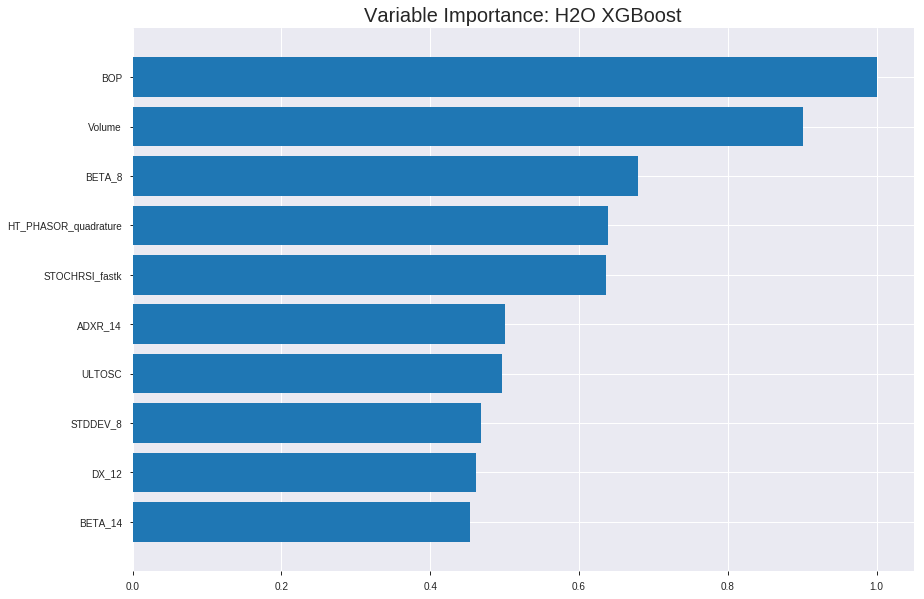

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_154704_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2079648172559258
RMSE: 0.45603159677365096
LogLoss: 0.6077254262414569
Mean Per-Class Error: 0.20073715454216523
AUC: 0.8786767916783366
pr_auc: 0.8861195332537565
Gini: 0.7573535833566731
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997195163193871: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1590  524   0.2479   (524.0/2114.0)
1      364   1835  0.1655   (364.0/2199.0)
Total  1954  2359  0.2059   (888.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49972      0.805178  214
max f2                       0.457299     0.873823  274
max f0point5                 0.524773     0.814088  180
max accuracy                 0.510278     0.79898   198
max precision                0.740259     1         0
max recall                   0.313565     1         392
max specificity              0.740259     1         0
max absolute_mcc             0.510278     0.598495  198
max min_per_class_accuracy   0.5078       0.796271  202
max mean_per_class_accuracy  0.510278     0.799263  198

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.682408           1.96135    1.96135            1                0.697407  1                           0.697407            0.0200091       0.0200091                  96.1346   96.1346
    2        0.0201716                   0.664486           1.96135    1.96135            1                0.671692  1                           0.684697            0.0195543       0.0395634                  96.1346   96.1346
    3        0.0301414                   0.65378            1.91573    1.94626            0.976744         0.658855  0.992308                    0.676149            0.0190996       0.058663                   91.5733   94.6259
    4        0.0401113                   0.64314            1.96135    1.95001            1                0.647737  0.99422                     0.669088            0.0195543       0.0782174                  96.1346   95.0009
    5        0.0500812                   0.635492           1.96135    1.95227            1                0.639173  0.99537                     0.663132            0.0195543       0.0977717                  96.1346   95.2266
    6        0.100162                    0.607385           1.90686    1.92956            0.972222         0.62022   0.983796                    0.641676            0.095498        0.19327                    90.6864   92.9565
    7        0.150012                    0.589866           1.87012    1.90981            0.953488         0.598385  0.973725                    0.62729             0.0932242       0.286494                   87.0121   90.9811
    8        0.200093                    0.574324           1.73434    1.86589            0.884259         0.581501  0.951333                    0.61583             0.0868577       0.373352                   73.4338   86.5892
    9        0.300023                    0.547626           1.6246     1.78552            0.828306         0.560041  0.910355                    0.597248            0.162347        0.535698                   62.4595   78.5522
    10       0.399954                    0.528878           1.35155    1.67709            0.689095         0.538164  0.855072                    0.582485            0.135061        0.670759                   35.1554   67.7093
    11       0.500116                    0.50818            1.2213     1.58581            0.622685         0.518555  0.80853                     0.569681            0.122328        0.793088                   22.1301   58.5808
    12       0.600046                    0.488763           0.805472   1.45585            0.410673         0.4989    0.742272                    0.557894            0.0804911       0.873579                   -19.4528  45.5852
    13       0.699977                    0.467418           0.577937   1.33052            0.294664         0.478492  0.67837                     0.546558            0.0577535       0.931332                   -42.2063  33.0519
    14       0.799907                    0.444088           0.40046    1.21433            0.204176         0.455504  0.61913                     0.535183            0.0400182       0.971351                   -59.954   21.4329
    15       0.899838                    0.412594           0.236636   1.10575            0.12065          0.430215  0.563772                    0.523526            0.0236471       0.994998                   -76.3364  10.5752
    16       1                           0.24417            0.0499417  1                  0.025463         0.381469  0.509854                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25708376404815636
RMSE: 0.5070342829120693
LogLoss: 0.7082779884169452
Mean Per-Class Error: 0.46415385062650816
AUC: 0.5339273773875629
pr_auc: 0.5504992588710247
Gini: 0.06785475477512581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22999826073646545: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    583   1        (583.0/583.0)
1      0    649   0        (0.0/649.0)
Total  0    1232  0.4732   (583.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.229998     0.690058   399
max f2                       0.229998     0.847701   399
max f0point5                 0.286043     0.58359    384
max accuracy                 0.43816      0.536526   228
max precision                0.547197     0.613333   76
max recall                   0.229998     1          399
max specificity              0.71869      0.998285   0
max absolute_mcc             0.509453     0.0809091  124
max min_per_class_accuracy   0.462476     0.523883   195
max mean_per_class_accuracy  0.475686     0.535846   174

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.638515           0.730117  0.730117           0.384615         0.663474  0.384615                    0.663474            0.00770416      0.00770416                 -26.9883  -26.9883
    2        0.0202922                   0.613405           0.949153  0.835254           0.5              0.623358  0.44                        0.644219            0.00924499      0.0169492                  -5.08475  -16.4746
    3        0.0300325                   0.603148           1.10734   0.9235             0.583333         0.607703  0.486486                    0.632376            0.0107858       0.027735                   10.7345   -7.65002
    4        0.0405844                   0.590751           1.31421   1.02508            0.692308         0.596149  0.54                        0.622957            0.0138675       0.0416025                  31.4211   2.50847
    5        0.0503247                   0.579959           0.632768  0.949153           0.333333         0.585026  0.5                         0.615615            0.00616333      0.0477658                  -36.7232  -5.08475
    6        0.100649                    0.556822           1.25533   1.10224            0.66129          0.566455  0.580645                    0.591035            0.0631741       0.11094                    25.5331   10.2242
    7        0.150162                    0.537641           1.15143   1.11846            0.606557         0.546613  0.589189                    0.576388            0.0570108       0.167951                   15.1431   11.8461
    8        0.200487                    0.521668           0.97977   1.08365            0.516129         0.529257  0.57085                     0.564557            0.0493066       0.217257                   -2.02296  8.36478
    9        0.300325                    0.497838           1.12664   1.09794            0.593496         0.510043  0.578378                    0.546435            0.112481        0.329738                   12.6636   9.79386
    10       0.400162                    0.479047           1.00317   1.07429            0.528455         0.488059  0.565923                    0.531871            0.100154        0.429892                   0.316935  7.42944
    11       0.5                         0.462322           0.941436  1.04777            0.495935         0.470232  0.551948                    0.519563            0.0939908       0.523883                   -5.85641  4.77658
    12       0.599838                    0.438644           1.03404   1.04548            0.544715         0.451341  0.550744                    0.508208            0.103236        0.627119                   3.40361   4.54806
    13       0.699675                    0.409979           0.848836  1.01742            0.447154         0.426443  0.535963                    0.496541            0.0847458       0.711864                   -15.1164  1.74211
    14       0.799513                    0.382811           0.879702  1.00022            0.463415         0.396731  0.526904                    0.484077            0.0878274       0.799692                   -12.0298  0.0223694
    15       0.899351                    0.343939           1.0186    1.00226            0.536585         0.361678  0.527978                    0.47049             0.101695        0.901387                   1.86027   0.226397
    16       1                           0.229998           0.97977   1                  0.516129         0.312506  0.526786                    0.454589  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:48:20  42.546 sec  0                  0.5              0.693147            0.5             0                  1                0.490146                         0.5                0.693147              0.5               0                    1                  0.473214
    2019-08-24 15:48:21  43.480 sec  5                  0.493851         0.680909            0.706398        0.713635           1.87219          0.400417                         0.499733           0.692614              0.520672          0.548548             0.876141           0.473214
    2019-08-24 15:48:21  43.813 sec  10                 0.488977         0.671285            0.750089        0.760576           1.96135          0.356364                         0.500498           0.694155              0.525013          0.541459             1.02216            0.472403
    2019-08-24 15:48:21  44.122 sec  15                 0.484898         0.663269            0.770085        0.783733           1.96135          0.318108                         0.50007            0.693316              0.540815          0.55121              0.876141           0.473214
    2019-08-24 15:48:22  44.437 sec  20                 0.480293         0.654281            0.794562        0.806127           1.96135          0.28843                          0.500523           0.694242              0.539651          0.554046             1.02216            0.473214
    2019-08-24 15:48:22  44.775 sec  25                 0.475469         0.644922            0.818828        0.828066           1.96135          0.283793                         0.5013             0.695874              0.537054          0.554906             0.43807            0.473214
    2019-08-24 15:48:22  45.101 sec  30                 0.471761         0.637738            0.82838         0.837998           1.96135          0.267099                         0.501093           0.695483              0.53997           0.558945             0.730117           0.473214
    2019-08-24 15:48:23  45.444 sec  35                 0.46766          0.62986             0.842179        0.851626           1.96135          0.252724                         0.502648           0.698699              0.535147          0.555597             0.876141           0.472403
    2019-08-24 15:48:23  45.790 sec  40                 0.463189         0.621327            0.858731        0.865955           1.96135          0.231162                         0.505027           0.703785              0.534123          0.55372              0.876141           0.472403
    2019-08-24 15:48:23  46.128 sec  45                 0.459279         0.613893            0.869688        0.876809           1.96135          0.210294                         0.506042           0.70605               0.535657          0.552798             0.730117           0.472403
    2019-08-24 15:48:24  46.557 sec  50                 0.456032         0.607725            0.878677        0.88612            1.96135          0.205889                         0.507034           0.708278              0.533927          0.550499             0.730117           0.473214

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      268.57275390625        1.0                   0.02795398307902953
Volume                   241.91116333007812     0.9007286100753222    0.025178952324843344
BETA_8                   182.53073120117188     0.6796323474602618    0.018998431140865274
HT_PHASOR_quadrature     171.6620635986328      0.639164103960279     0.017867182546828713
STOCHRSI_fastk           171.05467224121094     0.6369025515556226    0.017803963149176608
---                      ---                    ---                   ---
VAR_12                   4.695305347442627      0.017482433639123367  0.0004887036541283113
BBANDS_lowerband_8_0_3   4.681326389312744      0.017430384583787092  0.0004872486757161615
BBANDS_lowerband_12_7_5  4.5907673835754395     0.01709319846039903   0.00047782298052848803
SMA_8                    3.4137520790100098     0.01271071629329027   0.00035531514818498114
BBANDS_upperband_12_5_2  2.8900654315948486     0.01076082882407229   0.00030080802686445


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542949756888168)

('F1', 0.6711560044893379)

('auc', 0.5350478091835662)

('logloss', 0.6988970929886354)

('mean_per_class_error', 0.44666911841967005)

('rmse', 0.5027965266073973)

('mse', 0.2528043471684632)

xgboost prediction progress: |████████████████████████████████████████████| 100%


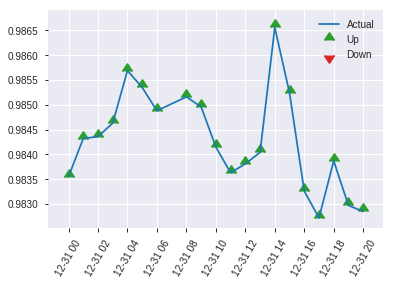


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2528043471684632
RMSE: 0.5027965266073973
LogLoss: 0.6988970929886354
Mean Per-Class Error: 0.44666911841967005
AUC: 0.5350478091835662
pr_auc: 0.5209392057706947
Gini: 0.0700956183671324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36274075508117676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   282  0.9186   (282.0/307.0)
1      11   299  0.0355   (11.0/310.0)
Total  36   581  0.4749   (293.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362741     0.671156  367
max f2                       0.298042     0.83468   399
max f0point5                 0.415766     0.572763  273
max accuracy                 0.415766     0.554295  273
max precision                0.529786     0.577465  59
max recall                   0.298042     1         399
max specificity              0.697705     0.996743  0
max absolute_mcc             0.415766     0.116215  273
max min_per_class_accuracy   0.444399     0.509677  207
max mean_per_class_accuracy  0.415766     0.553331  273

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 45.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.620736           0.852995  0.852995           0.428571         0.638712  0.428571                    0.638712            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.600948           0.995161  0.91861            0.5              0.610321  0.461538                    0.625608            0.00967742      0.0193548                  -0.483871  -8.13896
    3        0.0307942                   0.585259           0.995161  0.942784           0.5              0.591591  0.473684                    0.614866            0.00967742      0.0290323                  -0.483871  -5.72156
    4        0.0405186                   0.580265           1.6586    1.11458            0.833333         0.583058  0.56                        0.607232            0.016129        0.0451613                  65.8602    11.4581
    5        0.0502431                   0.572388           0.995161  1.09147            0.5              0.576136  0.548387                    0.601213            0.00967742      0.0548387                  -0.483871  9.14672
    6        0.100486                    0.535563           1.09147   1.09147            0.548387         0.548218  0.548387                    0.574716            0.0548387       0.109677                   9.14672    9.14672
    7        0.150729                    0.51029            1.15567   1.11287            0.580645         0.523456  0.55914                     0.557629            0.0580645       0.167742                   15.5671    11.2869
    8        0.200972                    0.493343           0.963059  1.07542            0.483871         0.502504  0.540323                    0.543848            0.0483871       0.216129                   -3.69407   7.54162
    9        0.299838                    0.474043           0.880962  1.0113             0.442623         0.483306  0.508108                    0.523885            0.0870968       0.303226                   -11.9038   1.1299
    10       0.400324                    0.456901           1.05937   1.02336            0.532258         0.466723  0.51417                     0.509537            0.106452        0.409677                   5.93652    2.33642
    11       0.50081                     0.443937           1.02726   1.02415            0.516129         0.450454  0.514563                    0.497682            0.103226        0.512903                   2.72633    2.41466
    12       0.599676                    0.43262            1.17462   1.04895            0.590164         0.43887   0.527027                    0.487986            0.116129        0.629032                   17.4617    4.89538
    13       0.700162                    0.415466           1.21988   1.07348            0.612903         0.424581  0.539352                    0.478886            0.122581        0.751613                   21.9875    7.34842
    14       0.799028                    0.398961           0.783078  1.03755            0.393443         0.407885  0.521298                    0.470101            0.0774194       0.829032                   -21.6922   3.75515
    15       0.899514                    0.379009           0.995161  1.03282            0.5              0.390379  0.518919                    0.461195            0.1             0.929032                   -0.483871  3.2816
    16       1                           0.298042           0.706243  1                  0.354839         0.352898  0.502431                   

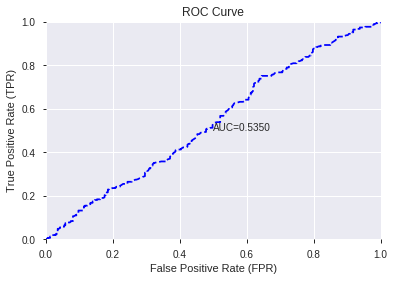

This function is available for GLM models only


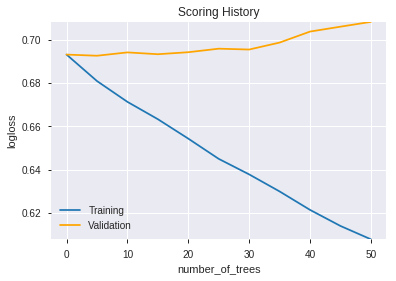

--2019-08-24 15:48:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_154704_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_154704_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'Volume',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'ADXR_14',
 'ULTOSC',
 'STDDEV_8',
 'DX_12',
 'BETA_14',
 'hour',
 'HT_DCPERIOD',
 'MFI_24',
 'AD',
 'STOCH_slowk',
 'MFI_14',
 'MINUS_DI_30',
 'MFI_30',
 'ADX_24',
 'MOM_8',
 'ADOSC',
 'PLUS_DM_12',
 'BETA_24',
 'LINEARREG_ANGLE_8',
 'MACDEXT_hist',
 'HT_PHASOR_inphase',
 'DX_8',
 'STDDEV_20',
 'CCI_8',
 'TRANGE',
 'ATR_8',
 'MACDFIX_hist_24',
 'ADX_12',
 'CCI_30',
 'ADX_14',
 'BETA_12',
 'BETA_30',
 'ROC_12',
 'STDDEV_30',
 'STOCHRSI_fastd',
 'BETA_20',
 'CCI_12',
 'MACDFIX_hist_8',
 'MOM_20',
 'ADXR_12',
 'STOCHF_fastk',
 'ADXR_8',
 'MACDFIX_signal_24',
 'aroondown_12',
 'TRIX_8',
 'CCI_24',
 'LINEARREG_ANGLE_12',
 'MACDFIX_hist_14',
 'STOCH_slowd',
 'PLUS_DI_8',
 'STDDEV_14',
 'CMO_12',
 'DX_14',
 'NATR_30',
 'MINUS_DM_8',
 'SAREXT',
 'MFI_8',
 'PLUS_DM_20',
 'STDDEV_12',
 'STDDEV_24',
 'VAR_8',
 'CCI_20',
 'PLUS_DM_8',
 'aroondown_24',
 'MFI_20',
 'MINUS_DI_8',
 'dayofyear',
 'MOM_14',
 'OBV',
 'DX_20',
 'D

In [52]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [53]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

424

['BBANDS_upperband_8_3_3',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_8_3_3',
 'BBANDS_upperband_8_3_4',
 'BBANDS_middleband_8_3_4',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_middleband_8_3_5',
 'BBANDS_lowerband_8_3_5',
 'MA_8_4',
 'MAVP_8_4',
 'BBANDS_upperband_8_4_2',
 'BBANDS_middleband_8_4_2',
 'BBANDS_upperband_8_4_3',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_8_4_3',
 'BBANDS_upperband_8_4_4',
 'BBANDS_middleband_8_4_4',
 'BBANDS_upperband_8_4_5',
 'BBANDS_lowerband_8_4_5',
 'MA_8_5',
 'MAVP_8_5',
 'T3_8_5',
 'BBANDS_upperband_8_5_2',
 'BBANDS_middleband_8_5_2',
 'BBANDS_lowerband_8_5_2',
 'BBANDS_upperband_8_5_3',
 'BBANDS_upperband_8_5_4',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_upperband_8_5_5',
 'BBANDS_middleband_8_5_5',
 'MA_8_6',
 'MAVP_8_6',
 'BBANDS_upperband_8_6_2',
 'BBANDS_upperband_8_6_3',
 'BBANDS_middleband_8_6_3',
 'BBANDS_upperband_8_6_4',
 'BBANDS_upperband_8_6_5',
 'BBANDS_middleband_8_6_5',
 'BBANDS_lowerband_8_6_5',
 'MAVP_8_7',
 'T

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_155346_model_1  0.548019  0.724956              0.500000  0.511982  0.262125
1  DeepLearning_grid_1_AutoML_20190824_155346_model_4  0.530561  0.697872              0.500000  0.502156  0.252160
2  DeepLearning_grid_1_AutoML_20190824_155346_model_2  0.509704  0.740051              0.498371  0.518989  0.269350
3               DeepLearning_1_AutoML_20190824_155346  0.508301  0.715846              0.500000  0.508618  0.258693
4  DeepLearning_grid_1_AutoML_20190824_155346_model_7  0.507187  0.734654              0.500000  0.514573  0.264786
5  DeepLearning_grid_1_AutoML_20190824_155346_model_6  0.502112  0.693776              0.500000  0.500314  0.250314
6  DeepLearning_grid_1_AutoML_20190824_155346_model_9  0.500000  0.693546              0.500000  0.500199  0.250199
7  DeepLearning_grid_1_AutoML_20190824_155346_model_8  0.500000  0.693264              0.500000  0.500059  0.250059
8  DeepLearning_grid_1_AutoML_20190824_155346_model_5  0.500000  0.695697              0.500000  0.501269  0.251271
9  DeepLearning_grid_1_AutoML_20190824_155346_model_3  0.496301  0.723779              0.498371  0.513316  0.263493

variable  relative_importance  scaled_importance  percentage
0                  CDLHAMMER             1.000000           1.000000    0.006818
1             CDLMATCHINGLOW             0.967846           0.967846    0.006599
2                  CDLTAKURI             0.843270           0.843270    0.005750
3           CDLDRAGONFLYDOJI             0.818716           0.818716    0.005582
4                  CORREL_20             0.763853           0.763853    0.005208
..                       ...                  ...                ...         ...
419               PLUS_DM_24             0.303130           0.303130    0.002067
420   BBANDS_lowerband_8_7_3             0.301881           0.301881    0.002058
421       LINEARREG_ANGLE_14             0.301105           0.301105    0.002053
422  BBANDS_lowerband_12_0_2             0.300872           0.300872    0.002051
423                   RSI_12             0.294819           0.294819    0.002010

[424 rows x 4 columns]

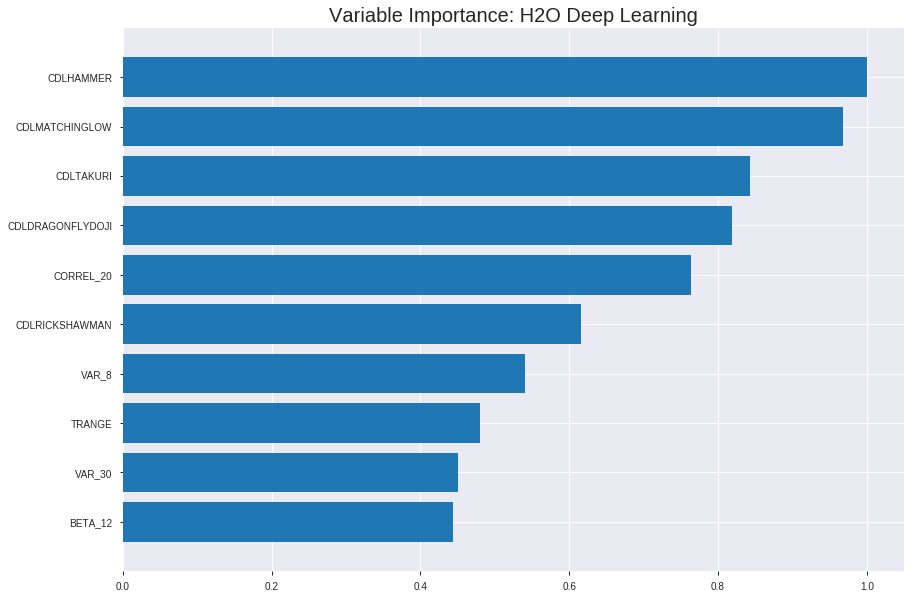

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_155346_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23004191816878328
RMSE: 0.47962685305222774
LogLoss: 0.6535776355314471
Mean Per-Class Error: 0.37496359186230266
AUC: 0.6690976762035552
pr_auc: 0.6745811630163459
Gini: 0.3381953524071104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38472160921897225: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      733   1381  0.6533   (1381.0/2114.0)
1      331   1868  0.1505   (331.0/2199.0)
Total  1064  3249  0.3969   (1712.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384722     0.685756  272
max f2                       0.0463117    0.838993  397
max f0point5                 0.550062     0.631651  181
max accuracy                 0.550062     0.623464  181
max precision                0.984132     1         0
max recall                   0.0463117    1         397
max specificity              0.984132     1         0
max absolute_mcc             0.552176     0.253081  180
max min_per_class_accuracy   0.516425     0.618918  201
max mean_per_class_accuracy  0.550062     0.625036  181

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 51.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.923408           1.78304   1.78304            0.909091         0.944732  0.909091                    0.944732            0.0181901       0.0181901                  78.3042   78.3042
    2        0.0201716                   0.885121           1.73328   1.75845            0.883721         0.900159  0.896552                    0.922702            0.0172806       0.0354707                  73.3283   75.8448
    3        0.0301414                   0.864089           1.59644   1.70486            0.813953         0.873971  0.869231                    0.906583            0.0159163       0.051387                   59.6444   70.4862
    4        0.0401113                   0.845954           1.45961   1.6439             0.744186         0.854956  0.83815                     0.893751            0.0145521       0.0659391                  45.9606   64.3903
    5        0.0500812                   0.823466           1.55083   1.62537            0.790698         0.834846  0.828704                    0.882024            0.0154616       0.0814006                  55.0832   62.5375
    6        0.100162                    0.765452           1.40745   1.51641            0.717593         0.794658  0.773148                    0.838341            0.0704866       0.151887                   40.7447   51.6411
    7        0.150012                    0.717119           1.30452   1.446              0.665116         0.738796  0.737249                    0.805262            0.0650296       0.216917                   30.4523   44.6
    8        0.200093                    0.673925           1.36205   1.42499            0.694444         0.695642  0.726535                    0.777825            0.0682128       0.28513                    36.2046   42.4987
    9        0.300023                    0.612767           1.17408   1.34142            0.598608         0.643537  0.683926                    0.733097            0.117326        0.402456                   17.4077   34.1415
    10       0.399954                    0.560094           1.14677   1.29278            0.584687         0.586551  0.65913                     0.696482            0.114598        0.517053                   14.6773   29.2783
    11       0.500116                    0.515667           1.00337   1.23482            0.511574         0.536376  0.629578                    0.664416            0.1005          0.617553                   0.33738   23.4821
    12       0.600046                    0.466391           0.969296  1.1906             0.4942           0.492005  0.607032                    0.635703            0.0968622       0.714416                   -3.07037  19.0601
    13       0.699977                    0.412423           0.869181  1.14471            0.443155         0.440181  0.583637                    0.60779             0.0868577       0.801273                   -13.0819  14.4714
    14       0.799907                    0.354121           0.778167  1.09892            0.396752         0.384528  0.56029                     0.579898            0.0777626       0.879036                   -22.1833  9.89223
    15       0.899838                    0.260609           0.59614   1.04309            0.303944         0.311559  0.531822                    0.550098            0.0595725       0.938608                   -40.386   4.30864
    16       1                           0.0328176          0.612921  1                  0.3125           0.182315  0.509854                    0.51326             



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2779768029545817
RMSE: 0.5272350547474833
LogLoss: 0.7677783933792387
Mean Per-Class Error: 0.4714364624821932
AUC: 0.5216007209931098
pr_auc: 0.5314678577553947
Gini: 0.04320144198621967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05855303696527518: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    574   0.9846   (574.0/583.0)
1      2    647   0.0031   (2.0/649.0)
Total  11   1221  0.4675   (576.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.058553     0.691979   392
max f2                       0.0294753    0.847701   399
max f0point5                 0.199436     0.587139   367
max accuracy                 0.273063     0.543019   335
max precision                0.55621      0.56338    147
max recall                   0.0294753    1          399
max specificity              0.956625     0.998285   0
max absolute_mcc             0.199436     0.0714672  367
max min_per_class_accuracy   0.458351     0.519726   211
max mean_per_class_accuracy  0.48954      0.528564   188

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 47.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.91034            0.876141  0.876141           0.461538         0.934431  0.461538                    0.934431            0.00924499      0.00924499                 -12.3859  -12.3859
    2        0.0202922                   0.874761           0.949153  0.911186           0.5              0.890096  0.48                        0.91315             0.00924499      0.01849                    -5.08475  -8.88136
    3        0.0300325                   0.84118            0.79096   0.872194           0.416667         0.858221  0.459459                    0.895335            0.00770416      0.0261941                  -20.904   -12.7806
    4        0.0405844                   0.824633           1.02216   0.911186           0.538462         0.832302  0.48                        0.878946            0.0107858       0.03698                    2.21643   -8.88136
    5        0.0503247                   0.801309           0.632768  0.857299           0.333333         0.812443  0.451613                    0.866075            0.00616333      0.0431433                  -36.7232  -14.2701
    6        0.100649                    0.729572           1.10224   0.97977            0.580645         0.759657  0.516129                    0.812866            0.05547         0.0986133                  10.2242   -2.02296
    7        0.150162                    0.66802            0.933593  0.964544           0.491803         0.699596  0.508108                    0.775517            0.046225        0.144838                   -6.64073  -3.54558
    8        0.200487                    0.616494           1.10224   0.999108           0.580645         0.63897   0.526316                    0.741242            0.05547         0.200308                   10.2242   -0.0892061
    9        0.300325                    0.54788            1.2038    1.06716            0.634146         0.578998  0.562162                    0.687307            0.120185        0.320493                   20.3803   6.71553
    10       0.400162                    0.500411           1.00317   1.05119            0.528455         0.522974  0.553753                    0.646307            0.100154        0.420647                   0.316935  5.11913
    11       0.5                         0.458357           1.00317   1.0416             0.528455         0.478381  0.548701                    0.612776            0.100154        0.520801                   0.316935  4.16025
    12       0.599838                    0.426055           0.926002  1.02236            0.487805         0.442166  0.538566                    0.58438             0.0924499       0.613251                   -7.39975  2.23619
    13       0.699675                    0.382773           1.00317   1.01962            0.528455         0.403955  0.537123                    0.558635            0.100154        0.713405                   0.316935  1.96233
    14       0.799513                    0.330713           0.941436  1.00986            0.495935         0.356687  0.53198                     0.533417            0.0939908       0.807396                   -5.85641  0.985976
    15       0.899351                    0.256739           1.08034   1.01768            0.569106         0.297609  0.536101                    0.50724             0.107858        0.915254                   8.03362   1.76834
    16       1                           0.029074           0.84199   1                  0.443548         0.182875  0.526786                    0.4745


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:53:49  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:53:54  6.450 sec         551 obs/sec       0.660329  1             2848       0.618887         1.61972             -0.53268       0.542088        0.549062           1.29271          0.490146                         0.674721           2.39363               -0.826232        0.531706          0.53793              0.876141           0.473214
    2019-08-24 15:54:09  21.467 sec        594 obs/sec       2.61048   4             11259      0.667331         2.83626             -0.782014      0.526847        0.502753           1.20355          0.490146                         0.701868           4.41205               -0.976143        0.520244          0.529235             1.02216            0.473214
    2019-08-24 15:54:23  35.797 sec        618 obs/sec       4.58521   7             19776      0.598384         1.69289             -0.43281       0.559293        0.481512           1.20355          0.490146                         0.617773           1.44557               -0.530967        0.52084           0.516282             1.02216            0.473214
    2019-08-24 15:54:37  49.555 sec        632 obs/sec       6.53489   10            28185      0.605404         1.39215             -0.466627      0.572412        0.566215           1.56016          0.477394                         0.675389           2.05953               -0.829852        0.524298          0.536677             1.02216            0.473214
    2019-08-24 15:54:51  1 min  3.468 sec  642 obs/sec       8.5182    13            36739      0.544871         1.03391             -0.188001      0.61178         0.56845            1.38186          0.45815                          0.558208           0.928813              -0.24997         0.523312          0.528787             0.292047           0.471591
    2019-08-24 15:55:04  1 min 16.819 sec  650 obs/sec       10.4658   16            45139      0.585778         2.13719             -0.373078      0.56662         0.604814           1.69389          0.490146                         0.594579           1.23029               -0.418169        0.508365          0.532466             0.876141           0.473214
    2019-08-24 15:55:17  1 min 29.905 sec  660 obs/sec       12.4394   19            53651      0.592549         1.44256             -0.405003      0.598808        0.545985           1.47101          0.430327                         0.585017           1.06993               -0.372918        0.523883          0.532151             0.730117           0.472403
    2019-08-24 15:55:30  1 min 42.911 sec  667 obs/sec       14.4032   22            62121      0.527186         0.887077            -0.112131      0.62084         0.597428           1.29271          0.442152                         0.554614           0.913292              -0.233929        0.5168            0.527959             1.16819            0.462662
    2019-08-24 15:55:43

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLHAMMER                1.0                    1.0                  0.006818470809819295
CDLMATCHINGLOW           0.9678457975387573     0.9678457975387573   0.006599228318924292
CDLTAKURI                0.8432695865631104     0.8432695865631104   0.005749809060788953
CDLDRAGONFLYDOJI         0.8187162280082703     0.8187162280082703   0.005582392702199749
CORREL_20                0.7638529539108276     0.7638529539108276   0.005208309069235221
---                      ---                    ---                  ---
PLUS_DM_24               0.303129643201828      0.303129643201828    0.002066880623762602
BBANDS_lowerband_8_7_3   0.3018808960914612     0.3018808960914612   0.0020583660780417196
LINEARREG_ANGLE_14       0.30110546946525574    0.30110546946525574  0.002053078854225781
BBANDS_lowerband_12_0_2  0.3008722960948944     0.3008722960948944   0.0020514889684063453
RSI_12                   0.29481905698776245    0.29481905698776245  0.0020102151342495096


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5445705024311183)

('F1', 0.6688241639697952)

('auc', 0.548019333823684)

('logloss', 0.7249564661944043)

('mean_per_class_error', 0.4567720920458127)

('rmse', 0.5119818520763502)

('mse', 0.26212541685552965)

deeplearning prediction progress: |███████████████████████████████████████| 100%


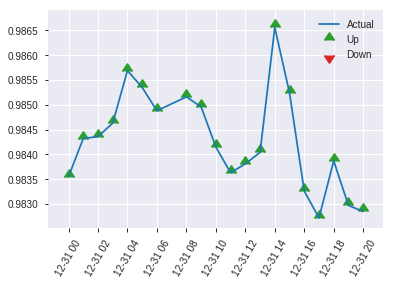


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26212541685552965
RMSE: 0.5119818520763502
LogLoss: 0.7249564661944043
Mean Per-Class Error: 0.4567720920458127
AUC: 0.548019333823684
pr_auc: 0.5585247472724624
Gini: 0.0960386676473679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08519887996747044: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    307  1        (307.0/307.0)
1      0    310  0        (0.0/310.0)
Total  0    617  0.4976   (307.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0851989    0.668824  399
max f2                       0.0851989    0.83468   399
max f0point5                 0.37526      0.57053   301
max accuracy                 0.37526      0.544571  301
max precision                0.965631     1         0
max recall                   0.0851989    1         399
max specificity              0.965631     1         0
max absolute_mcc             0.909037     0.12773   8
max min_per_class_accuracy   0.474276     0.535484  213
max mean_per_class_accuracy  0.37526      0.543228  301

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 49.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.9206             1.99032   1.99032            1                0.933046  1                           0.933046            0.0225806       0.0225806                  99.0323   99.0323
    2        0.0210697                   0.891425           1.6586    1.83722            0.833333         0.904028  0.923077                    0.919653            0.016129        0.0387097                  65.8602   83.7221
    3        0.0307942                   0.851227           0.663441  1.46655            0.333333         0.865702  0.736842                    0.902616            0.00645161      0.0451613                  -33.6559  46.6553
    4        0.0405186                   0.8191             0.33172   1.19419            0.166667         0.840372  0.6                         0.887678            0.00322581      0.0483871                  -66.828   19.4194
    5        0.0502431                   0.791152           1.6586    1.28408            0.833333         0.803896  0.645161                    0.871462            0.016129        0.0645161                  65.8602   28.4079
    6        0.100486                    0.720881           1.15567   1.21988            0.580645         0.748443  0.612903                    0.809952            0.0580645       0.122581                   15.5671   21.9875
    7        0.150729                    0.66968            1.02726   1.15567            0.516129         0.69729   0.580645                    0.772398            0.0516129       0.174194                   2.72633   15.5671
    8        0.200972                    0.622904           1.09147   1.13962            0.548387         0.643537  0.572581                    0.740183            0.0548387       0.229032                   9.14672   13.962
    9        0.299838                    0.558239           0.913591  1.06509            0.459016         0.588068  0.535135                    0.690026            0.0903226       0.319355                   -8.64093  6.50915
    10       0.400324                    0.512947           1.05937   1.06365            0.532258         0.535686  0.534413                    0.651285            0.106452        0.425806                   5.93652   6.36542
    11       0.50081                     0.472717           1.09147   1.06923            0.548387         0.492481  0.537217                    0.619421            0.109677        0.535484                   9.14672   6.92348
    12       0.599676                    0.437674           0.913591  1.04357            0.459016         0.455955  0.524324                    0.592472            0.0903226       0.625806                   -8.64093  4.35745
    13       0.700162                    0.402366           1.02726   1.04123            0.516129         0.421252  0.523148                    0.567898            0.103226        0.729032                   2.72633   4.12336
    14       0.799028                    0.366297           1.07673   1.04563            0.540984         0.384377  0.525355                    0.545191            0.106452        0.835484                   7.67319   4.56259
    15       0.899514                    0.307679           0.802549  1.01847            0.403226         0.341555  0.511712                    0.522442            0.0806452       0.916129                   -19.7451  1.84714
    16       1                           0.0851989          0.834651  1                  0.419355         0.232211  0.502431                    0.493278          

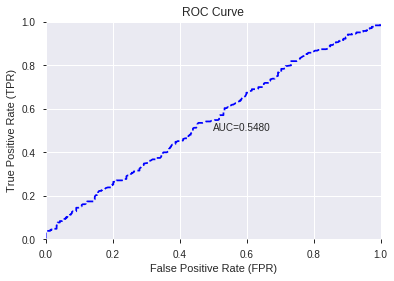

This function is available for GLM models only


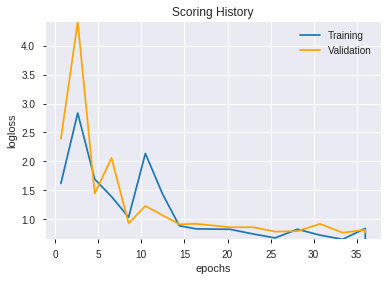

--2019-08-24 16:26:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_155346_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_155346_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHAMMER',
 'CDLMATCHINGLOW',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CORREL_20',
 'CDLRICKSHAWMAN',
 'VAR_8',
 'TRANGE',
 'VAR_30',
 'BETA_12',
 'BETA_14',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'MINUS_DM_8',
 'CDLDOJISTAR',
 'AROONOSC_8',
 'aroonup_8',
 'MINUS_DM_30',
 'PLUS_DI_8',
 'VAR_14',
 'BETA_20',
 'VAR_20',
 'aroonup_14',
 'HT_DCPERIOD',
 'aroonup_24',
 'CDLSPINNINGTOP',
 'ULTOSC',
 'MACDEXT_hist',
 'NATR_30',
 'CDLCLOSINGMARUBOZU',
 'aroondown_24',
 'MINUS_DM_14',
 'PLUS_DM_8',
 'BETA_30',
 'BOP',
 'STDDEV_30',
 'aroondown_8',
 'CCI_14',
 'VAR_24',
 'STOCH_slowd',
 'WILLR_14',
 'MINUS_DM_24',
 'CDLBELTHOLD',
 'aroonup_20',
 'BETA_8',
 'MFI_30',
 'STDDEV_12',
 'ADOSC',
 'STOCHF_fastk',
 'WILLR_30',
 'CCI_8',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_24_6_3',
 'ATR_8',
 'DX_24',
 'MFI_20',
 'aroondown_14',
 'aroondown_12',
 'CDLHIGHWAVE',
 'CDLMARUBOZU',
 'aroonup_12',
 'BBANDS_upperband_30_7_2',
 'BBANDS_lowerband_24_1_4',
 'MOM_24',
 'STOCH_slowk',
 'ADXR_14',
 'AROONOSC_

In [54]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_162724_model_1  0.502128  0.693973              0.495067  0.500412  0.250412

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk             0.011800           1.000000    0.024397
1                        BOP             0.010603           0.898596    0.021923
2             CDLSPINNINGTOP             0.009897           0.838714    0.020462
3               CDLSHORTLINE             0.008612           0.729837    0.017805
4                  CDLHAMMER             0.008180           0.693201    0.016912
..                       ...                  ...                ...         ...
419  BBANDS_middleband_8_4_4             0.000005           0.000447    0.000011
420                 TYPPRICE             0.000003           0.000293    0.000007
421  BBANDS_lowerband_14_0_4             0.000003           0.000248    0.000006
422  BBANDS_middleband_8_4_2             0.000002           0.000192    0.000005
423  BBANDS_lowerband_14_3_2             0.000001           0.000106    0.000003

[424 rows x 4 columns]

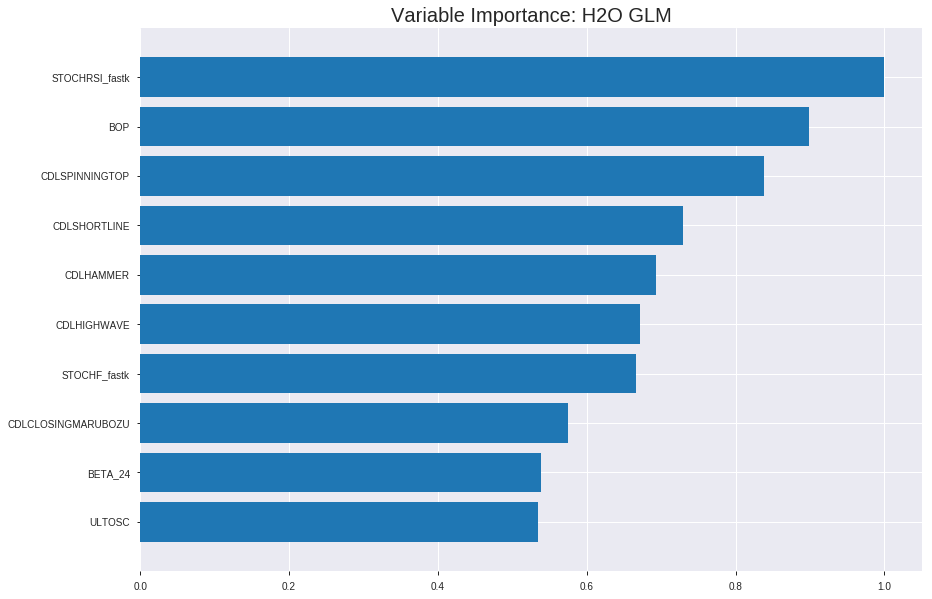

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_162724_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24813732714647818
RMSE: 0.49813384461054055
LogLoss: 0.6894124660325373
Null degrees of freedom: 4312
Residual degrees of freedom: 3888
Null deviance: 5977.4123029576585
Residual deviance: 5946.871931996667
AIC: 6796.871931996667
AUC: 0.5595996374029134
pr_auc: 0.5615660043251949
Gini: 0.11919927480582682
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43667219130835977: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      14   2100  0.9934   (2100.0/2114.0)
1      5    2194  0.0023   (5.0/2199.0)
Total  19   4294  0.4881   (2105.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.436672     0.675805   384
max f2                       0.402123     0.838929   396
max f0point5                 0.492043     0.572824   268
max accuracy                 0.510165     0.547415   186
max precision                0.569033     1          0
max recall                   0.402123     1          396
max specificity              0.569033     1          0
max absolute_mcc             0.510165     0.0941929  186
max min_per_class_accuracy   0.51091      0.543992   182
max mean_per_class_accuracy  0.510165     0.547074   186

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.553621           1.33728   1.33728            0.681818         0.559032  0.681818                    0.559032            0.0136426       0.0136426                  33.7281   33.7281
    2        0.0201716                   0.549002           1.18593   1.26248            0.604651         0.550932  0.643678                    0.555029            0.0118236       0.0254661                  18.593    26.2476
    3        0.0301414                   0.546711           1.18593   1.23716            0.604651         0.547812  0.630769                    0.552642            0.0118236       0.0372897                  18.593    23.7157
    4        0.0401113                   0.54447            1.36838   1.26977            0.697674         0.545478  0.647399                    0.550861            0.0136426       0.0509322                  36.8381   26.9773
    5        0.0500812                   0.542365           1.04909   1.22584            0.534884         0.543452  0.625                       0.549386            0.0104593       0.0613915                  4.90921   22.5841
    6        0.100162                    0.536299           1.09872   1.16228            0.560185         0.538881  0.592593                    0.544134            0.055025        0.116417                   9.8717    16.2279
    7        0.150012                    0.531966           1.13119   1.15195            0.576744         0.53413   0.587326                    0.540809            0.0563893       0.172806                   13.1195   15.195
    8        0.200093                    0.528308           1.16228   1.15454            0.592593         0.530159  0.588644                    0.538144            0.0582083       0.231014                   16.2279   15.4535
    9        0.300023                    0.521475           1.07396   1.1277             0.547564         0.52489   0.574961                    0.533729            0.107322        0.338336                   7.39621   12.7698
    10       0.399954                    0.516226           1.01935   1.10063            0.519722         0.518788  0.561159                    0.529996            0.101864        0.4402                     1.93539   10.0628
    11       0.500116                    0.510934           1.03061   1.08661            0.525463         0.51373   0.55401                     0.526738            0.103229        0.543429                   3.06147   8.66057
    12       0.600046                    0.505702           0.946543  1.06328            0.482599         0.508352  0.542117                    0.523676            0.0945884       0.638017                   -5.34571  6.328
    13       0.699977                    0.499972           1.01025   1.05571            0.515081         0.502951  0.538258                    0.520717            0.100955        0.738972                   1.02525   5.57096
    14       0.799907                    0.493121           0.941992  1.0415             0.480278         0.496656  0.531014                    0.517711            0.0941337       0.833106                   -5.80078  4.15032
    15       0.899838                    0.4834             0.787269  1.01327            0.401392         0.488899  0.516619                    0.514512            0.0786721       0.911778                   -21.2731  1.32695
    16       1                           0.367901           0.88079   1                  0.449074         0.468009  0.509854                    0.509854            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2489356005743724
RMSE: 0.49893446520998364
LogLoss: 0.6910180862073632
Null degrees of freedom: 1231
Residual degrees of freedom: 807
Null deviance: 1705.7914799426171
Residual deviance: 1702.668564414943
AIC: 2552.668564414943
AUC: 0.5342392439086918
pr_auc: 0.5431766530427669
Gini: 0.06847848781738364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45037673948730794: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    578   0.9914   (578.0/583.0)
1      1    648   0.0015   (1.0/649.0)
Total  6    1226  0.47     (579.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450377     0.6912    393
max f2                       0.446105     0.848366  396
max f0point5                 0.481442     0.585201  328
max accuracy                 0.496405     0.543019  264
max precision                0.528392     0.574074  89
max recall                   0.446105     1         396
max specificity              0.563499     0.998285  0
max absolute_mcc             0.550783     0.088087  8
max min_per_class_accuracy   0.508435     0.526587  195
max mean_per_class_accuracy  0.496405     0.530846  264

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.550151           0.292047  0.292047           0.153846         0.554504  0.153846                    0.554504            0.00308166      0.00308166                 -70.7953  -70.7953
    2        0.0202922                   0.548063           1.10734   0.68339            0.583333         0.548997  0.36                        0.551861            0.0107858       0.0138675                  10.7345   -31.661
    3        0.0300325                   0.545406           1.42373   0.9235             0.75             0.546628  0.486486                    0.550164            0.0138675       0.027735                   42.3729   -7.65002
    4        0.0405844                   0.543171           1.02216   0.949153           0.538462         0.544131  0.5                         0.548595            0.0107858       0.0385208                  2.21643   -5.08475
    5        0.0503247                   0.541698           1.26554   1.01039            0.666667         0.54245   0.532258                    0.547406            0.0123267       0.0508475                  26.5537   1.03882
    6        0.100649                    0.534635           1.10224   1.05631            0.580645         0.538149  0.556452                    0.542777            0.05547         0.106317                   10.2242   5.63149
    7        0.150162                    0.53067            1.08919   1.06716            0.57377          0.532478  0.562162                    0.539381            0.0539291       0.160247                   8.91914   6.71553
    8        0.200487                    0.526816           1.13286   1.08365            0.596774         0.528436  0.57085                     0.536634            0.0570108       0.217257                   13.2859   8.36478
    9        0.300325                    0.519672           0.987736  1.05176            0.520325         0.523063  0.554054                    0.532122            0.0986133       0.315871                   -1.2264   5.17636
    10       0.400162                    0.514328           1.08034   1.05889            0.569106         0.516765  0.557809                    0.528291            0.107858        0.423729                   8.03362   5.88923
    11       0.5                         0.508502           1.00317   1.04777            0.528455         0.511338  0.551948                    0.524906            0.100154        0.523883                   0.316935  4.77658
    12       0.599838                    0.502897           0.972303  1.03521            0.512195         0.505834  0.545332                    0.521731            0.0970724       0.620955                   -2.76974  3.52056
    13       0.699675                    0.497872           1.04947   1.03724            0.552846         0.500473  0.546404                    0.518698            0.104777        0.725732                   4.94695   3.72409
    14       0.799513                    0.491289           0.926002  1.02335            0.487805         0.494916  0.539086                    0.515728            0.0924499       0.818182                   -7.39975  2.33503
    15       0.899351                    0.480339           0.941436  1.01426            0.495935         0.48609   0.534296                    0.512438            0.0939908       0.912173                   -5.85641  1.42569
    16       1                           0.443961           0.872608  1                  0.459677         0.469095  0.526786                    0.508076      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 16:27:26  0.000 sec   2            2.7       425           1.38088           1.38231
    2019-08-24 16:27:26  0.422 sec   3            2         425           1.37991           1.38212
    2019-08-24 16:27:27  1.275 sec   5            1.4       425           1.37882           1.38204
    2019-08-24 16:27:28  2.100 sec   7            1         425           1.37765           1.38208
    2019-08-24 16:27:29  2.953 sec   9            0.76      425           1.37639           1.38231
    2019-08-24 16:27:30  3.813 sec   11           0.56      425           1.37506           1.38279
    2019-08-24 16:27:31  4.647 sec   13           0.4       425           1.37366           1.38356
    2019-08-24 16:27:31  5.504 sec   15           0.29      425           1.37219           1.38462

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5170178282009724)

('F1', 0.6688453159041394)

('auc', 0.5021277713565199)

('logloss', 0.6939726202639681)

('mean_per_class_error', 0.4825680361458442)

('rmse', 0.5004118318384333)

('mse', 0.2504120014438964)

glm prediction progress: |████████████████████████████████████████████████| 100%


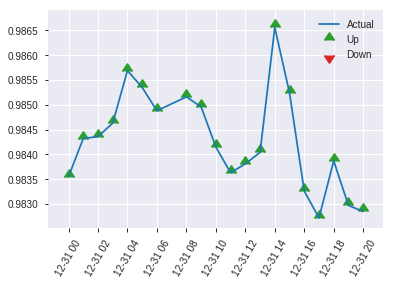


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2504120014438964
RMSE: 0.5004118318384333
LogLoss: 0.6939726202639681
Null degrees of freedom: 616
Residual degrees of freedom: 192
Null deviance: 855.4650475313558
Residual deviance: 856.3622134057366
AIC: 1706.3622134057366
AUC: 0.5021277713565199
pr_auc: 0.5103494865631799
Gini: 0.004255542713039739
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44130518321757295: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    301  0.9805   (301.0/307.0)
1      3    307  0.0097   (3.0/310.0)
Total  9    608  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441305     0.668845  391
max f2                       0.423054     0.83468   399
max f0point5                 0.441305     0.55981   391
max accuracy                 0.508979     0.517018  160
max precision                0.563101     1         0
max recall                   0.423054     1         399
max specificity              0.563101     1         0
max absolute_mcc             0.557965     0.05675   1
max min_per_class_accuracy   0.504058     0.496774  188
max mean_per_class_accuracy  0.508979     0.517432  160

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.547626           1.13733   1.13733            0.571429         0.554152  0.571429                    0.554152            0.0129032       0.0129032                  13.7327    13.7327
    2        0.0210697                   0.54283            1.32688   1.22481            0.666667         0.544999  0.615385                    0.549928            0.0129032       0.0258065                  32.6882    22.4814
    3        0.0307942                   0.541891           0.995161  1.15229            0.5              0.542326  0.578947                    0.547527            0.00967742      0.0354839                  -0.483871  15.2292
    4        0.0405186                   0.539519           0.995161  1.11458            0.5              0.540481  0.56                        0.545836            0.00967742      0.0451613                  -0.483871  11.4581
    5        0.0502431                   0.538834           0.33172   0.963059           0.166667         0.539253  0.483871                    0.544562            0.00322581      0.0483871                  -66.828    -3.69407
    6        0.100486                    0.530117           1.21988   1.09147            0.612903         0.53349   0.548387                    0.539026            0.0612903       0.109677                   21.9875    9.14672
    7        0.150729                    0.52687            0.706243  0.963059           0.354839         0.528317  0.483871                    0.535456            0.0354839       0.145161                   -29.3757   -3.69407
    8        0.200972                    0.522834           1.09147   0.995161           0.548387         0.524728  0.5                         0.532774            0.0548387       0.2                        9.14672    -0.483871
    9        0.299838                    0.516262           1.07673   1.02206            0.540984         0.519388  0.513514                    0.52836             0.106452        0.306452                   7.67319    2.20575
    10       0.400324                    0.509495           1.05937   1.03142            0.532258         0.512546  0.518219                    0.524391            0.106452        0.412903                   5.93652    3.14222
    11       0.50081                     0.503916           0.866753  0.998382           0.435484         0.506724  0.501618                    0.520846            0.0870968       0.5                        -13.3247   -0.161812
    12       0.599676                    0.497954           0.946219  0.989782           0.47541          0.50096   0.497297                    0.517567            0.0935484       0.593548                   -5.37811   -1.0218
    13       0.700162                    0.490307           1.02726   0.995161           0.516129         0.494525  0.5                         0.51426             0.103226        0.696774                   2.72633    -0.483871
    14       0.799028                    0.481528           1.0441    1.00122            0.52459          0.486164  0.503043                    0.510784            0.103226        0.8                        4.41036    0.121704
    15       0.899514                    0.468411           0.930957  0.993368           0.467742         0.475724  0.499099                    0.506867            0.0935484       0.893548                   -6.90427   -0.663179
    16       1                           0.423054           1.05937   1                  0.532258         0.455136  0.502431         

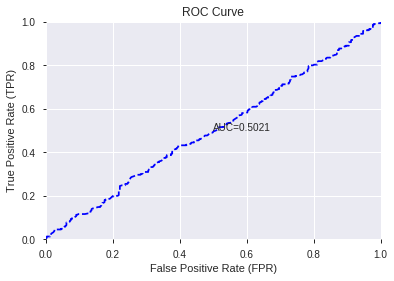

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


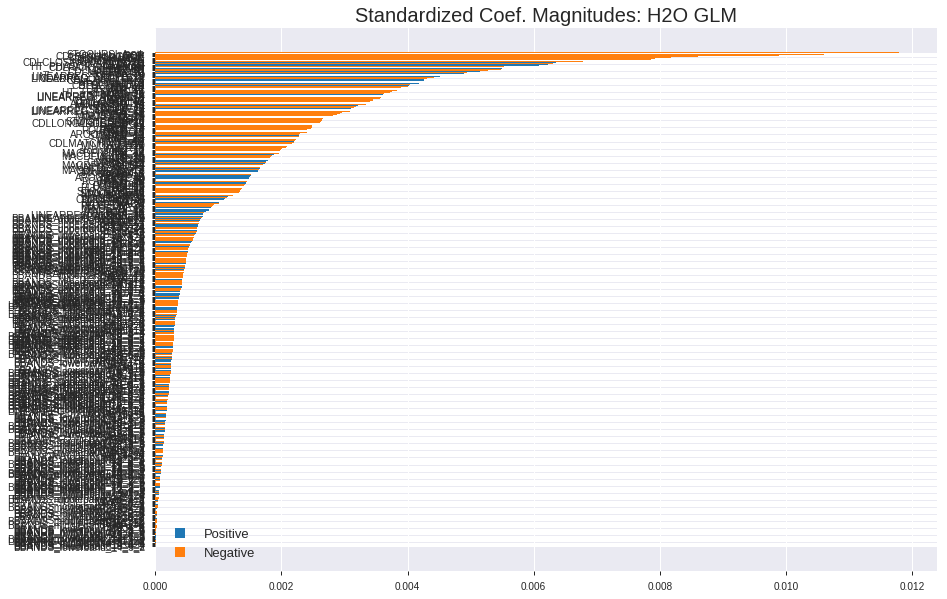

'log_likelihood'
--2019-08-24 16:27:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_162724_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_162724_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHRSI_fastk',
 'BOP',
 'CDLSPINNINGTOP',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'CDLHIGHWAVE',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'BETA_24',
 'ULTOSC',
 'MFI_30',
 'HT_PHASOR_quadrature',
 'CDLRICKSHAWMAN',
 'MFI_24',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'TRANGE',
 'aroonup_20',
 'BETA_20',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'CDLDRAGONFLYDOJI',
 'ATR_8',
 'CDLENGULFING',
 'aroondown_12',
 'NATR_8',
 'STOCH_slowd',
 'CDLBELTHOLD',
 'MFI_20',
 'aroonup_14',
 'VAR_24',
 'ATR_12',
 'HT_TRENDMODE',
 'aroondown_24',
 'NATR_12',
 'STDDEV_24',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'ATR_14',
 'VAR_30',
 'NATR_14',
 'CDLLONGLINE',
 'AROONOSC_14',
 'MINUS_DM_24',
 'MINUS_DM_30',
 'BETA_14',
 'STDDEV_8',
 'STDDEV_20',
 'LINEARREG_SLOPE_14',
 'LINEARREG_ANGLE_14',
 'VAR_14',
 'ADXR_14',
 'MINUS_DM_14',
 'MINUS_DI_30',
 'ATR_20',
 'RSI_8',
 'CMO_8',
 'STOCHRSI_fastd',
 'STDDEV_30',
 'MINUS_DM_12',
 'CDLLONGLEGGEDDOJI',
 'ROC_14',
 'ROCP_14',
 'MOM_14',
 'ROCR_14',
 'ROCR100_14',
 'A

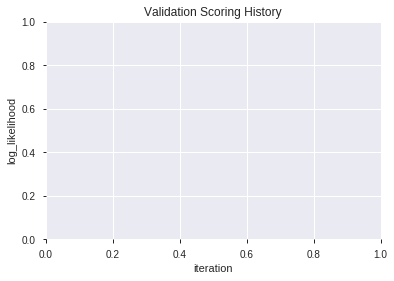

In [55]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_162843_model_3  0.536493  0.695393              0.500000  0.501036  0.251037
1  XGBoost_grid_1_AutoML_20190824_162843_model_5  0.507198  0.724988              0.498371  0.514135  0.264335
2  XGBoost_grid_1_AutoML_20190824_162843_model_1  0.505716  0.705165              0.498371  0.505702  0.255735
3               XGBoost_2_AutoML_20190824_162843  0.497058  0.709119              0.496727  0.507664  0.257722
4  XGBoost_grid_1_AutoML_20190824_162843_model_4  0.496722  0.700651              0.486876  0.503657  0.253671
5               XGBoost_1_AutoML_20190824_162843  0.493648  0.716131              0.500000  0.510612  0.260725
6  XGBoost_grid_1_AutoML_20190824_162843_model_7  0.491888  0.721289              0.500000  0.512990  0.263159
7               XGBoost_3_AutoML_20190824_162843  0.483214  0.707643              0.496711  0.507018  0.257067
8  XGBoost_grid_1_AutoML_20190824_162843_model_2  0.481980  0.703106              0.498371  0.504870  0.254894
9  XGBoost_grid_1_AutoML_20190824_162843_model_6  0.469392  0.707495              0.498371  0.506956  0.257004

variable  relative_importance  scaled_importance  percentage
0                        BOP           233.079483           1.000000    0.033351
1       HT_PHASOR_quadrature           122.142120           0.524036    0.017477
2             STOCHRSI_fastk           116.877380           0.501449    0.016724
3                     BETA_8           111.476379           0.478276    0.015951
4                  STDDEV_20           107.894592           0.462909    0.015438
..                       ...                  ...                ...         ...
248   BBANDS_lowerband_8_5_4             2.460983           0.010559    0.000352
249  BBANDS_lowerband_14_7_3             2.340952           0.010044    0.000335
250                    DX_20             1.703902           0.007310    0.000244
251  BBANDS_lowerband_14_6_3             1.522264           0.006531    0.000218
252  BBANDS_middleband_8_3_3             1.516233           0.006505    0.000217

[253 rows x 4 columns]

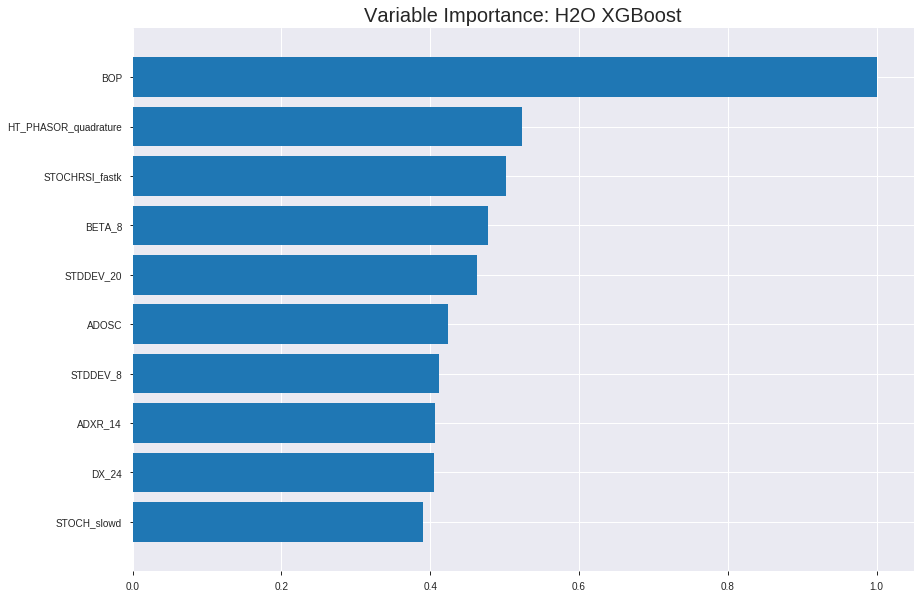

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_162843_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21316592703989842
RMSE: 0.4616989571570402
LogLoss: 0.6183000352797925
Mean Per-Class Error: 0.230744020998622
AUC: 0.8503595424599554
pr_auc: 0.853901618838751
Gini: 0.7007190849199108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49768938045752675: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1463  651   0.3079   (651.0/2114.0)
1      357   1842  0.1623   (357.0/2199.0)
Total  1820  2493  0.2337   (1008.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497689     0.785166  215
max f2                       0.45547      0.86799   274
max f0point5                 0.518692     0.784187  185
max accuracy                 0.51318      0.768838  193
max precision                0.763841     1         0
max recall                   0.368087     1         365
max specificity              0.763841     1         0
max absolute_mcc             0.51318      0.538679  193
max min_per_class_accuracy   0.50983      0.767266  197
max mean_per_class_accuracy  0.51318      0.769256  193

Gains/Lift Table: Avg response rate: 50.99 %, avg score: 50.95 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.673939           1.96135    1.96135            1                0.697557  1                           0.697557            0.0200091       0.0200091                  96.1346   96.1346
    2        0.0201716                   0.660441           1.96135    1.96135            1                0.667037  1                           0.682472            0.0195543       0.0395634                  96.1346   96.1346
    3        0.0301414                   0.646794           1.91573    1.94626            0.976744         0.652756  0.992308                    0.672643            0.0190996       0.058663                   91.5733   94.6259
    4        0.0401113                   0.636064           1.87012    1.92733            0.953488         0.641044  0.982659                    0.664789            0.0186448       0.0773079                  87.0121   92.7334
    5        0.0500812                   0.626816           1.87012    1.91594            0.953488         0.631529  0.976852                    0.658168            0.0186448       0.0959527                  87.0121   91.5945
    6        0.100162                    0.59896            1.83422    1.87508            0.935185         0.612815  0.956019                    0.635491            0.0918599       0.187813                   83.4222   87.5083
    7        0.150012                    0.581347           1.75153    1.83403            0.893023         0.58952   0.935085                    0.620215            0.0873124       0.275125                   75.1528   83.4025
    8        0.200093                    0.56754            1.67986    1.79544            0.856481         0.574737  0.915411                    0.608832            0.0841291       0.359254                   67.9857   79.5438
    9        0.300023                    0.545885           1.56544    1.71883            0.798144         0.556025  0.876352                    0.591243            0.156435        0.515689                   56.5436   71.883
    10       0.399954                    0.527763           1.30605    1.61569            0.665893         0.536653  0.823768                    0.577604            0.130514        0.646203                   30.6047   61.5694
    11       0.500116                    0.510196           1.16682    1.52579            0.594907         0.518956  0.777932                    0.565858            0.116871        0.763074                   16.6819   52.5794
    12       0.600046                    0.493261           0.905587   1.42251            0.461717         0.501929  0.72527                     0.555211            0.0904957       0.85357                    -9.44133  42.2506
    13       0.699977                    0.473382           0.646198   1.31168            0.329466         0.483251  0.668764                    0.544938            0.0645748       0.918145                   -35.3802  31.1679
    14       0.799907                    0.449868           0.459619   1.20523            0.234339         0.461686  0.614493                    0.534538            0.04593         0.964075                   -54.0381  20.5233
    15       0.899838                    0.419045           0.268491   1.1012             0.136891         0.436343  0.561453                    0.523633            0.0268304       0.990905                   -73.1509  10.1204
    16       1                           0.25474            0.0908031  1                  0.0462963        0.382518  0.509854                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2581698153999771
RMSE: 0.5081041383417154
LogLoss: 0.7108949209955342
Mean Per-Class Error: 0.46174084949268823
AUC: 0.5230199779579086
pr_auc: 0.5491148225416211
Gini: 0.04603995591581711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22247056663036346: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    582   0.9983   (582.0/583.0)
1      0    649   0        (0.0/649.0)
Total  1    1231  0.4724   (582.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.222471     0.690426   398
max f2                       0.222471     0.847923   398
max f0point5                 0.256413     0.582568   394
max accuracy                 0.510988     0.528409   131
max precision                0.549907     0.616667   78
max recall                   0.222471     1          398
max specificity              0.729311     0.998285   0
max absolute_mcc             0.537946     0.0844417  93
max min_per_class_accuracy   0.478399     0.511556   183
max mean_per_class_accuracy  0.510988     0.538259   131

Gains/Lift Table: Avg response rate: 52.68 %, avg score: 46.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.655934           1.02216   1.02216            0.538462         0.689595  0.538462                    0.689595            0.0107858       0.0107858                  2.21643   2.21643
    2        0.0202922                   0.638698           0.632768  0.835254           0.333333         0.646007  0.44                        0.668673            0.00616333      0.0169492                  -36.7232  -16.4746
    3        0.0300325                   0.617195           1.10734   0.9235             0.583333         0.627974  0.486486                    0.655473            0.0107858       0.027735                   10.7345   -7.65002
    4        0.0405844                   0.600547           1.02216   0.949153           0.538462         0.608969  0.5                         0.643382            0.0107858       0.0385208                  2.21643   -5.08475
    5        0.0503247                   0.595696           1.58192   1.07162            0.833333         0.597197  0.564516                    0.634443            0.0154083       0.0539291                  58.1921   7.16238
    6        0.100649                    0.568709           1.1941    1.13286            0.629032         0.580443  0.596774                    0.607443            0.0600924       0.114022                   19.4095   13.2859
    7        0.150162                    0.54877            1.18255   1.14924            0.622951         0.557864  0.605405                    0.591095            0.0585516       0.172573                   18.2551   14.9244
    8        0.200487                    0.53648            1.1941    1.1605             0.629032         0.541934  0.611336                    0.578755            0.0600924       0.232666                   19.4095   16.0502
    9        0.300325                    0.513911           0.956869  1.09281            0.504065         0.525097  0.575676                    0.560918            0.0955316       0.328197                   -4.31308  9.28081
    10       0.400162                    0.496801           0.941436  1.05504            0.495935         0.505202  0.555781                    0.547017            0.0939908       0.422188                   -5.85641  5.50418
    11       0.5                         0.478062           0.895136  1.02311            0.471545         0.487784  0.538961                    0.535189            0.0893683       0.511556                   -10.4864  2.31125
    12       0.599838                    0.455937           1.00317   1.01979            0.528455         0.467213  0.537212                    0.523875            0.100154        0.61171                    0.316935  1.97931
    13       0.699675                    0.431805           0.956869  1.01081            0.504065         0.444867  0.532483                    0.512601            0.0955316       0.707242                   -4.31308  1.08144
    14       0.799513                    0.395903           0.910569  0.998296           0.479675         0.414773  0.525888                    0.500385            0.0909091       0.798151                   -8.94309  -0.170352
    15       0.899351                    0.34395            0.941436  0.991984           0.495935         0.371504  0.522563                    0.486078            0.0939908       0.892142                   -5.85641  -0.801566
    16       1                           0.220504           1.07162   1                  0.564516         0.306786  0.526786                    0.468033  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:29:04  4.927 sec   0                  0.5              0.693147            0.5             0                  1                0.490146                         0.5                0.693147              0.5               0                    1                  0.473214
    2019-08-24 16:29:05  5.465 sec   5                  0.494278         0.681751            0.684002        0.690434           1.787            0.424762                         0.499537           0.692223              0.530303          0.561568             1.02216            0.473214
    2019-08-24 16:29:05  5.729 sec   10                 0.490127         0.67354             0.722892        0.726628           1.87219          0.362393                         0.500652           0.694471              0.520147          0.544342             1.02216            0.473214
    2019-08-24 16:29:05  6.012 sec   15                 0.486033         0.665479            0.751681        0.754193           1.87219          0.336657                         0.501726           0.696685              0.517819          0.54499              0.730117           0.473214
    2019-08-24 16:29:06  6.303 sec   20                 0.482081         0.657725            0.770966        0.77374            1.96135          0.31463                          0.50274            0.698816              0.517381          0.538682             0.876141           0.473214
    2019-08-24 16:29:06  6.597 sec   25                 0.478387         0.650513            0.790173        0.792357           1.91677          0.290749                         0.503255           0.699919              0.517586          0.537663             0.876141           0.473214
    2019-08-24 16:29:06  6.903 sec   30                 0.474682         0.643299            0.803765        0.804941           1.91677          0.28588                          0.50328            0.70001               0.522211          0.543238             0.876141           0.473214
    2019-08-24 16:29:07  7.212 sec   35                 0.470954         0.636082            0.815873        0.820121           1.96135          0.277765                         0.503969           0.701508              0.522655          0.542566             0.730117           0.472403
    2019-08-24 16:29:07  7.544 sec   40                 0.467477         0.629407            0.833191        0.836021           1.96135          0.259912                         0.505103           0.703988              0.523689          0.545982             0.876141           0.471591
    2019-08-24 16:29:07  7.871 sec   45                 0.464086         0.622912            0.845672        0.848071           1.96135          0.250406                         0.506408           0.707007              0.525932          0.549323             1.02216            0.472403
    2019-08-24 16:29:08  8.187 sec   50                 0.461699         0.6183              0.85036         0.853902           1.96135          0.233712                         0.508104           0.710895              0.52302           0.549115             1.02216            0.472403

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      233.07948303222656     1.0                   0.03335097030452402
HT_PHASOR_quadrature     122.14212036132812     0.5240363449083171    0.01747712057752859
STOCHRSI_fastk           116.87738037109375     0.5014485996390072    0.016723797355805682
BETA_8                   111.47637939453125     0.47827624269750957   0.015950976767563962
STDDEV_20                107.89459228515625     0.4629090080409964    0.01543846458087194
---                      ---                    ---                   ---
BBANDS_lowerband_8_5_4   2.4609832763671875     0.01055855815514625   0.00035213815949087244
BBANDS_lowerband_14_7_3  2.340951919555664      0.010043577792010093  0.0003349630646925055
DX_20                    1.703902244567871      0.007310391384093993  0.00024380864596536698
BBANDS_lowerband_14_6_3  1.5222644805908203     0.006531096005478722  0.00021781838893471627
BBANDS_middleband_8_3_3  1.5162334442138672     0.006505220556046224  0.00021695541758907683


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5478119935170178)

('F1', 0.6688241639697952)

('auc', 0.5364925922034255)

('logloss', 0.6953933940004279)

('mean_per_class_error', 0.4524745192812861)

('rmse', 0.5010357237848625)

('mse', 0.251036796508621)

xgboost prediction progress: |████████████████████████████████████████████| 100%


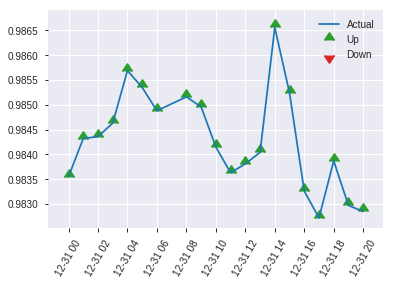


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.251036796508621
RMSE: 0.5010357237848625
LogLoss: 0.6953933940004279
Mean Per-Class Error: 0.4524745192812861
AUC: 0.5364925922034255
pr_auc: 0.5264105336212799
Gini: 0.07298518440685098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2504867613315582: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    307  1        (307.0/307.0)
1      0    310  0        (0.0/310.0)
Total  0    617  0.4976   (307.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250487     0.668824  399
max f2                       0.250487     0.83468   399
max f0point5                 0.438929     0.560224  283
max accuracy                 0.46295      0.547812  221
max precision                0.692024     1         0
max recall                   0.250487     1         399
max specificity              0.692024     1         0
max absolute_mcc             0.46261      0.095767  222
max min_per_class_accuracy   0.471846     0.522581  201
max mean_per_class_accuracy  0.46295      0.547525  221

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 47.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.611642           1.70599   1.70599            0.857143         0.643923  0.857143                    0.643923            0.0193548       0.0193548                  70.5991   70.5991
    2        0.0210697                   0.592605           0.663441  1.22481            0.333333         0.601747  0.615385                    0.624457            0.00645161      0.0258065                  -33.6559  22.4814
    3        0.0307942                   0.582067           0.663441  1.04754            0.333333         0.587544  0.526316                    0.6128              0.00645161      0.0322581                  -33.6559  4.75382
    4        0.0405186                   0.577417           0.663441  0.955355           0.333333         0.579794  0.48                        0.604879            0.00645161      0.0387097                  -33.6559  -4.46452
    5        0.0502431                   0.567966           1.32688   1.02726            0.666667         0.573677  0.516129                    0.59884             0.0129032       0.0516129                  32.6882   2.72633
    6        0.100486                    0.544873           0.963059  0.995161           0.483871         0.554723  0.5                         0.576781            0.0483871       0.1                        -3.69407  -0.483871
    7        0.150729                    0.530425           0.963059  0.984461           0.483871         0.53754   0.494624                    0.563701            0.0483871       0.148387                   -3.69407  -1.55394
    8        0.200972                    0.517092           0.963059  0.97911            0.483871         0.523856  0.491935                    0.55374             0.0483871       0.196774                   -3.69407  -2.08897
    9        0.299838                    0.498563           1.33776   1.09737            0.672131         0.506983  0.551351                    0.538323            0.132258        0.329032                   33.7758   9.7367
    10       0.400324                    0.486834           1.02726   1.07977            0.516129         0.492892  0.54251                     0.526919            0.103226        0.432258                   2.72633   7.97701
    11       0.50081                     0.471486           0.898855  1.04347            0.451613         0.479159  0.524272                    0.517336            0.0903226       0.522581                   -10.1145  4.34701
    12       0.599676                    0.45917            1.17462   1.06509            0.590164         0.464966  0.535135                    0.508702            0.116129        0.63871                    17.4617   6.50915
    13       0.700162                    0.445731           0.834651  1.03202            0.419355         0.452535  0.518519                    0.500641            0.083871        0.722581                   -16.5349  3.20191
    14       0.799028                    0.430076           0.946219  1.0214             0.47541          0.437591  0.513185                    0.49284             0.0935484       0.816129                   -5.37811  2.14029
    15       0.899514                    0.40936            0.866753  1.00413            0.435484         0.420461  0.504505                    0.484754            0.0870968       0.903226                   -13.3247  0.412671
    16       1                           0.250487           0.963059  1                  0.483871         0.380193  0.502431                    0.474247    

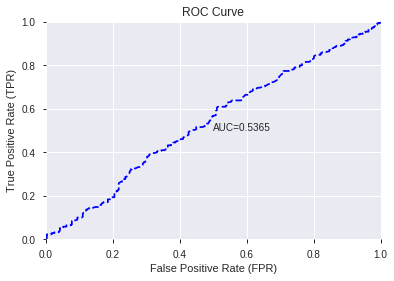

This function is available for GLM models only


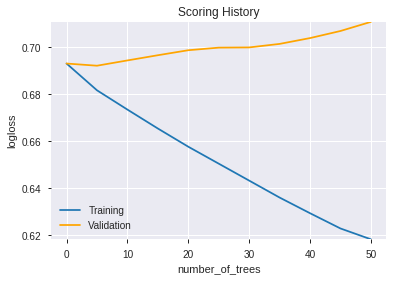

--2019-08-24 16:29:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_162843_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_162843_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a66a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'BETA_8',
 'STDDEV_20',
 'ADOSC',
 'STDDEV_8',
 'ADXR_14',
 'DX_24',
 'STOCH_slowd',
 'TRANGE',
 'BETA_24',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'LINEARREG_ANGLE_8',
 'ULTOSC',
 'BETA_12',
 'BETA_14',
 'BETA_20',
 'DX_8',
 'MACDEXT_hist',
 'MFI_20',
 'AD',
 'DX_14',
 'MFI_24',
 'PLUS_DI_8',
 'HT_PHASOR_inphase',
 'PLUS_DM_12',
 'DX_12',
 'MOM_20',
 'MACDFIX_signal_24',
 'ADX_12',
 'MFI_14',
 'NATR_8',
 'OBV',
 'ATR_20',
 'BETA_30',
 'STDDEV_24',
 'WILLR_14',
 'CCI_30',
 'STDDEV_12',
 'MFI_30',
 'aroondown_12',
 'STOCH_slowk',
 'CMO_12',
 'APO',
 'ATR_24',
 'WILLR_20',
 'PLUS_DI_24',
 'PLUS_DI_12',
 'WILLR_24',
 'STDDEV_30',
 'MACDFIX_hist_20',
 'CMO_14',
 'DX_30',
 'PLUS_DM_8',
 'CMO_30',
 'MINUS_DI_14',
 'NATR_12',
 'MINUS_DM_30',
 'PLUS_DM_30',
 'LINEARREG_ANGLE_14',
 'ATR_8',
 'MFI_12',
 'aroonup_24',
 'CMO_24',
 'PLUS_DM_20',
 'MINUS_DM_8',
 'VAR_14',
 'MOM_30',
 'CCI_20',
 'MOM_14',
 'CCI_12',
 'ATR_12',
 'MINUS_DI_30',
 'MOM_8',
 

In [56]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [57]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.545
GLM             0.520
XGBoost         0.554
dtype: float64

DeepLearning    GLM  XGBoost
All          0.535  0.514    0.554
DLF          0.543  0.520    0.517
Fwe          0.530  0.514    0.554
RFE          0.545  0.517    0.548
XGBF         0.538  0.520    0.517





F1


DeepLearning    0.675
GLM             0.670
XGBoost         0.671
dtype: float64

DeepLearning    GLM  XGBoost
All          0.675  0.669    0.671
DLF          0.670  0.670    0.670
Fwe          0.670  0.669    0.671
RFE          0.669  0.669    0.669
XGBF         0.670  0.670    0.670





auc


DeepLearning    0.548
GLM             0.508
XGBoost         0.536
dtype: float64

DeepLearning    GLM  XGBoost
All          0.528  0.498    0.535
DLF          0.535  0.508    0.496
Fwe          0.524  0.498    0.535
RFE          0.548  0.502    0.536
XGBF         0.527  0.508    0.496





logloss


DeepLearning    0.964
GLM             0.695
XGBoost         0.702
dtype: float64

DeepLearning    GLM  XGBoost
All          0.755  0.694    0.699
DLF          0.728  0.695    0.702
Fwe          0.964  0.694    0.699
RFE          0.725  0.694    0.695
XGBF         0.868  0.695    0.702





mean_per_class_error


DeepLearning    0.471
GLM             0.484
XGBoost         0.484
dtype: float64

DeepLearning    GLM  XGBoost
All          0.466  0.484    0.447
DLF          0.457  0.482    0.484
Fwe          0.471  0.484    0.447
RFE          0.457  0.483    0.452
XGBF         0.463  0.482    0.484





rmse


DeepLearning    0.586
GLM             0.501
XGBoost         0.504
dtype: float64

DeepLearning    GLM  XGBoost
All          0.521  0.500    0.503
DLF          0.513  0.501    0.504
Fwe          0.586  0.500    0.503
RFE          0.512  0.500    0.501
XGBF         0.523  0.501    0.504





mse


DeepLearning    0.343
GLM             0.251
XGBoost         0.254
dtype: float64

DeepLearning    GLM  XGBoost
All          0.271  0.250    0.253
DLF          0.264  0.251    0.254
Fwe          0.343  0.250    0.253
RFE          0.262  0.250    0.251
XGBF         0.274  0.251    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.675    NaN      NaN
 DLF          0.670    NaN      NaN
 DLF            NaN  0.670      NaN
 DLF            NaN    NaN    0.670
 All            NaN  0.669      NaN
 All            NaN    NaN    0.671
 XGBF         0.670    NaN      NaN
 XGBF           NaN  0.670      NaN
 XGBF           NaN    NaN    0.670
 Fwe          0.670    NaN      NaN
 Fwe            NaN  0.669      NaN
 Fwe            NaN    NaN    0.671
 RFE          0.669    NaN      NaN
 RFE            NaN  0.669      NaN
 RFE            NaN    NaN    0.669,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.535    NaN      NaN
 DLF          0.543    NaN      NaN
 DLF            NaN  0.520      NaN
 DLF            NaN    NaN    0.517
 All            NaN  0.514      NaN
 All            NaN    NaN    0.554
 XGBF         0.538    NaN      NaN
 XGBF           NaN  0.520      NaN
 XGBF           NaN    NaN    0.517
 Fwe          0.530    NaN      NaN
 Fwe     